In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
drive_dir = '/content/drive/MyDrive/AIF/'
original_file_path = 'Dataset_2.0_Akkodis.xlsx'
cleaned_file_path = 'Dataset_2.0_Akkodis_cleaned.xlsx'
job_file_path = 'Dataset_2.0_Akkodis_Job_Offers.xlsx'
candidates_file_path = 'Dataset_2.0_Akkodis_candidates.xlsx'
final_file_path = 'Dataset_2.0_Akkodis_final.xlsx'
it_csv_path = 'it.csv'
countries_csv_path = 'countries.csv'

####Imports

In [3]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
from google.colab import files
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from geopy.distance import geodesic
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(42)

####Utils

In [4]:
#percentage of candidates that have no value (i.e. 'not specified') for that column, in each row of the candidate
def null_percentage(df, col, n_candidates):
  null_counts = df.groupby('Id')[col].apply(lambda x: (x == 'not specified').all())
  total_null_ids = null_counts.sum()
  return total_null_ids / n_candidates * 100


In [5]:
#percentage of candidates that have more than n value specified for the same column 'col' (other than 'Not Specified')
def multiple_percentage(df, col, n, n_candidates):
  multiple_counts = df.groupby('Id')[col].apply(lambda x: x[x != 'not specified'].nunique())
  ids_with_multiple_values = multiple_counts[multiple_counts > n-1]
  return len(ids_with_multiple_values) / n_candidates * 100

In [6]:
def getHist(df, col, order):
  counts = Counter(df.groupby('Id')[col].first())
  counts_df = pd.DataFrame(counts.items(), columns=[col, 'Count'])
  prefix = ''
  counts_df[col] = counts_df[col].astype(str)
  if order is not None and len(order):
    counts_df[col] = pd.Categorical(counts_df[col], categories=order, ordered=True)
    counts_df = counts_df.sort_values(by=col, ascending=True)
  else:
    counts_df = counts_df.sort_values(by='Count', ascending=False)
  if counts_df.shape[0] > 20:
    counts_df = counts_df.head(20)
    prefix = 'Top 20 '
  counts_df.plot(x=col, y='Count', kind='bar', legend=False)
  plt.title(f'{prefix}{col} Distribution')
  plt.ylabel('Frequency')
  plt.xlabel(col)
  plt.show()

In [7]:
def getPie(df, col):
  counts = Counter(df.groupby('Id')[col].first())
  counts_df = pd.DataFrame(counts.items(), columns=[col, 'Count'])
  labels = counts_df[col]
  sizes = counts_df['Count']

  patches, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
  plt.show()

In [8]:
def plot_graphs(filtered_df, statCol, value,):
    filtered_count = (filtered_df.groupby('Id')[statCol].last()).value_counts() #keeps most recent value of statCol

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    filtered_count.plot(kind='bar', ax=axes[0], legend=False, color='skyblue')
    axes[0].set_title(f'{statCol} Counts for {value}', fontsize=10)
    axes[0].set_ylabel('Frequency', fontsize=8)
    axes[0].set_xlabel('Candidate State', fontsize=8)
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0].tick_params(axis='y', labelsize=8)

    wedges, texts, autotexts = axes[1].pie(
        filtered_count,
        labels=filtered_count.index,
        autopct='%1.0f%%',
        textprops={'fontsize': 8},
        colors=plt.cm.Paired.colors,
        labeldistance=1.2,
        pctdistance=0.8
    )
    axes[1].set_title(f'{statCol} Distribution for {value}', fontsize=10)

    plt.tight_layout(pad=2)
    fig.subplots_adjust(wspace=0.2)
    plt.show()

In [9]:
def getStats(col, value):
    filtered_df = df[df[col] == value]
    filtered_candidates = filtered_df['Id'].unique()
    print(f"{len(filtered_candidates)} ({len(filtered_candidates)/len(candidates)*100:.2f}%) candidates have '{value}' as {col} \n(in at least one row)\n\n")
    filtered_df = df[df['Id'].isin(filtered_candidates)]

    ids = filtered_df[filtered_df['Job Family Hiring'] == 'not specified']['Id'].unique().tolist()
    null_counts = len(ids) / len(filtered_candidates) * 100
    print(f"{null_counts:.2f}% of candidates ({len(ids)}) with '{value}' (in at least one row) have no Job Position specified\n \n\n")

    plot_graphs(filtered_df, 'Candidate State', value)
    print("\n\n")
    plot_graphs(filtered_df, 'Event_Type__Val', value)


In [10]:
def getJStats(df, col):
  filtered_count = df[col].value_counts()
  num = df[df[col] == 'not specified'].shape[0]
  print(f"There are {num} ({num/df.shape[0]*100:.2f}%) 'not specified' for <{col}>\n\n")
  filtered_count = filtered_count[filtered_count.index != 'not specified']

  fig, axes = plt.subplots(1, 2, figsize=(14, 4))

  filtered_count.plot(kind='bar', ax=axes[0], legend=False)
  axes[0].set_title(f'{col} Distribution')
  axes[0].set_ylabel('Frequency')
  axes[0].set_xlabel(f'{col}')

  axes[1].pie(filtered_count, labels=filtered_count.index, autopct='%1.0f%%', textprops={'fontsize': 8})
  axes[1].set_title(f'{col} Distribution')

  plt.show()

In [11]:
def getJobStats():
  for col in job_offer_columns:
    if col not in descr_job_offer_col:
      getJStats(job_offers_df, col)
      print("\n\n")

In [12]:
def custom_mean(x):
  numeric_values = x[x != 'not specified'].astype(float)
  if numeric_values.empty:
    return 'not specified'
  return int(round(numeric_values.mean()))

In [13]:
def check_values(val):
  if isinstance(val, str):
    for n in values:
      if n in val:
        return n
  return np.nan

In [14]:
def map_residence(value):
    for region in italy_list:
        if region in value:
          return region
    for country in country_list:
        if country in value:
          return country
    return 'not specified'

In [15]:
def check_order(group):
    return (group['Age Range Numeric'].astype(int).diff() >= 0).all()

In [16]:
def tokenize_and_filter(text):
    if pd.isnull(text):
        return []
    if text == 'not specified':
        return text
    words = re.findall(r'\b\w+(?:[-&]\w+)*\b', text.lower())
    filtered_words = [word for word in words if word not in ENGLISH_STOP_WORDS and len(word) > 1]
    return filtered_words

In [17]:
def job_id_finder(row, job_df):
  for col in job_df.columns:
    if col != 'ID':
      job_df = job_df[job_df[col] == row[col]]
      if job_df.shape[0] == 0:
        return None
      elif job_df.shape[0] == 1:
        return job_df.iloc[0]['ID']
  print(job_df)
  return job_df.iloc[0]['ID']

In [18]:
def calculate_distance(row):
    residence_coords = row['Residence_coord']
    job_coords = row['Assumption_coord']
    if residence_coords and job_coords:
        return geodesic(residence_coords, job_coords).km
    return None

In [19]:
def clean_text(text):
    if text == 'not specified':
        return ''
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'[^a-z0-9, ]', '', text)
    text = " ".join(dict.fromkeys(text.split()))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [20]:
def check_study_title(job_st, st):
  if st == 'not specified' and job_st == 'not specified':
    return 0
  if st == 'not specified':
    return -1
  if job_st == 'not specified':
    return 0
  return round((study_title_order[st] - study_title_order[job_st]) / len(list(study_title_order.keys())), 2)

In [21]:
def check_years_exp(job_ye, ye):
  if ye == 'not specified' and job_ye == 'not specified':
    return 0
  if ye == 'not specified':
    return -1
  if job_ye == 'not specified':
    return 0
  return round((years_exp_order[ye] - years_exp_order[job_ye]) / len(list(years_exp_order.keys())), 2)

In [22]:
def check_ral(job_ral, ral):
  if ral == 'not specified' or job_ral == 'not specified':
    return 0
  return round((ral_order[job_ral] - ral_order[ral]) / len(list(ral_order.keys())), 2)

# Dataset Analysis for AKKODIS


## Overview

The Akkodis Dataset consists of 40 columns and 21,277 entries. Each candidate is identified by its `ID` and can appear in more than one row, each one specific for an `Event_type__val`.

In [218]:
#dataset load
df = pd.read_excel(drive_dir + original_file_path)

In [219]:
#column names cleaning
df.columns = df.columns.str.lstrip()
df.columns = df.columns.str.title()
df.rename(columns={'Comunication': 'Communication'}, inplace=True)

In [220]:
#candidates list
candidates = df['Id'].unique().tolist()
print(f"There are {len(candidates)} candidates in the dataset")

There are 12263 candidates in the dataset


In [221]:
original_df = df.copy()


## Dataset Description

### Features

The features can be divided in:
* **CANDIDATE FEATURES**
  * **ID**: unique identifier for the candidate
  * **Candidate State**: status of the candidate's application
    * `Hired`: the candidate has been selected
    * `Vivier`: the candidate's skills do not correspond to the requested skills, but will be taken in consideration for future opportunities (**by who?** Akkodis | the company)
    * `QM`: Qualification Meeting
    * `In selection`: selection phase
    * `First contact`: the candidate has been contacted from the company for the first time
    * `Economic proposal`: the company has made a proposal to the candidate
    * `Imported`: the candidate has been transfered from another DB **??**
  
   Possible chronological orders for candidate status:
    * `In selection` > `First contact` > `QM` > `Economic Proposal` > `Hired`  (complete cycle with positive outcome)
    * `In selection` > `First contact` > `QM` > `Vivier`
    * `In selection` > `First contact` > `QM` (end of the selection process)
    * `In selection` > `First contact` (end of the selection process **WHY?**)
  * **Age Range**: range of age for the candidate
    * `< 20`
    * `20 - 25`
    * `26 - 30`
    * `31 - 35`
    * `36 - 40`
    * `40 - 45`
    * `> 45`
  * **Residence**: current place of residence for the candidate
  * **Sex**: gender identification (`Male|Female`)
  * **Protected Category**: indicates if the candidate falls into a protected category
    * `Article 1`
    * `Article 18`
    * Not Specified
  * **TAG**: keywords used by recruiter
  * **Study Area**: Field of study or academic discipline of the candidate
  * **Study Title**: Academic degree or title obtained by the candidate
    * `Five-year degree`
    * `Doctorate`
    * `High school graduation`
    * `Three-year degree`
    * `master's degree`
    * `Professional qualification`
    * `Middle school diploma`
  * **Years Experience**: number of years of professional experience of the candidate
    * `0`
    * `0-1`
    * `1-3`
    * `3-5`
    * `5-7`
    * `7-10`
    * `+10`
  * **Sector**: industry or sector in which the candidate has experience
  * **Last Role**: candidate's most recent job role
  * **Year of Insertion**: year when the candidate's information was entered into the portal
  * **Year of Recruitment**: year in which the candidate was hired
  * **Current Ral**: current or existing salary
  * **Expected Ral**: expected salary
  
  Values present only if the candidate have moved forward in the recruiting process:
  * **Technical Skills**: skills related to technical or specialized expertise from 1 to 4
  * **Standing/Position**: standing or position within the organization from 1 to 4 **??**
  * **Comunication**: communication skills from 1 to 4
  * **Maturity**: level of maturity from 1 to 4
  * **Dynamism**: level of Dynamism from 1 to 4
  * **Mobility**: mobility from 1 to 4
  * **English**: proficiency in the English language from 1 to 4
* **HIRING PROCESS FEATURES**
  * **Event_type__val**: It specifies the stage of the recruitment process for the candidate
  * **Event_feedback**: feedback received from an event (`OK|KO`)
  * **Overall**: overall assessment, interview score
    * `1 - Low` or `~ 1 - Low`
    * `2 - Medium` or `~ 2 - Medium`
    * `3 - High` or `~ 3 - High`
    * `4 - Top` or `~ 4 - Top`
  * **Akkodis headquarters**: headquarters location for Akkodis
* **JOB POSITION FEATURES**: these features are present only if the candidate has been hired
  * **Recruitment Request**: represents the application request for a candidacy
  * **Assumption Headquarters**: headquarters location associated with the hiring assumption
  * **Job Family Hiring**: Job family or category for the hiring position
  * **Job Title Hiring**: specific job title for the hiring position
  * **Job Description**: description of the job role
  * **Candidate Profile**: ideal profile information for the candidate, requested by the company
  * **Years Experience.1**: additional field for specifying years of experience requested
  * **Minimum Ral** (Gross Annual Salary): minimum expected gross annual salary
  * **Ral Maximum**: maximum expected gross annual salary
  * **Study Level**: level of study requested for the job position, the values are equivalent to `Study Title`
  * **Study Area.1**: additional field for specifying the academic field of study requested
  * **Linked_search_key**: indicates the number of searches conducted for a job position




In [222]:
job_offer_columns = ['Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring', 'Job Title Hiring',
                     'Job Description', 'Candidate Profile', 'Years Experience.1','Minimum Ral', 'Ral Maximum',
                     'Study Level', 'Study Area.1', 'Linked_Search__Key']

In [223]:
akkodis_col = ['Id','Akkodis Headquarters', 'Event_Feedback', 'Event_Type__Val', 'Overall']

In [224]:
candidate_col = ['Id', 'Age Range', 'Candidate State', 'Communication', 'Dynamism', 'English',
       'Last Role', 'Maturity', 'Mobility', 'Protected Category', 'Residence',
       'Sector', 'Sex', 'Standing/Position', 'Study Area', 'Study Title',
       'Tag', 'Technical Skills', 'Year Of Insertion', 'Year Of Recruitment',
       'Years Experience', 'Current Ral', 'Expected Ral']

## NaN Handling & Cleaning

In [225]:
numerical_cols = [ 'Id', 'Year Of Insertion', 'Year Of Recruitment', 'Overall', 'Technical Skills', 'Standing/Position', 'Communication',
       'Maturity', 'Dynamism', 'Mobility', 'English']

In [226]:
substitutions = {
    r'\bsr\b(?![a-zA-Z0-9])': 'senior',
    r'\beng\b(?![a-zA-Z0-9])': 'engineer',
    r'\bing\b(?![a-zA-Z0-9])': 'engineer',
    r'\bback end\b(?![a-zA-Z0-9])': 'back-end',
    r'\bfront end\b(?![a-zA-Z0-9])': 'front-end',
    r'\bbm\b(?![a-zA-Z0-9])': 'business-manager',
    r'\bhr\b(?![a-zA-Z0-9])': 'human resources',
    r'\bsw\b(?![a-zA-Z0-9])': 'software',
    r'\bhw\b(?![a-zA-Z0-9])': 'hardware',
    r'\bjr.\b(?![a-zA-Z0-9])': 'junior',
    r'\bjr\b(?![a-zA-Z0-9])': 'junior'
}

In [227]:
#nan cleaning for job columns
for col in job_offer_columns:
  if col != 'Linked_Search__Key':
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')
    df[col] = df[col].str.lstrip()
    df[col] = df[col].str.rstrip()
    df[col] = df[col].str.lower()
    if col == 'Candidate Profile':
      df[col] = df[col].replace([0, '.', '(coming soon)', '-', 'x', 'ok', 'anyone', 'replacement'], 'not specified')
    if col == 'Job Title Hiring':
      df[col] = df[col].replace('???', 'not specified')
    if col == 'Job Description':
      df[col] = df[col].replace(['.','ok','replacement'], 'not specified')
    if 'Ral' in col:
      df[col] = df[col].replace(['not avail.', 'not available'], 'not specified')
      df[col] = df[col].str.replace('- ','-')
      df[col] = df[col].str.replace('+ ','+')
      df[col] = df[col].replace('20k', '-20k')
    if col == 'Study Area.1':
      df[col] = df[col].replace('other', 'not specified')
    if col == 'Assumption Headquarters':
      df[col] = df[col].replace('the eagle', 'l"aquila')
      df[col] = df[col].replace('toasts', 'brindisi')
    df[col] = df[col].str.lstrip()
    if col != 'Assumption Headquarters':
      for pattern, replacement in substitutions.items():
        df[col] = df[col].str.replace(pattern, replacement, regex=True)
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')

In [228]:
#to detect default values
for col in job_offer_columns:
    values = df[col].unique().tolist()
    try:
      if len(values) < 30:
        print(f"Possible values for <{col}>: \n {np.sort(values)}\n\n")
      else:
        values = [s for s in values if len(s) < 25]
        print(f"Possible short values for <{col}>: \n {np.sort(values)}\n\n")
    except:
      values = [s for s in values if isinstance(s, int) or isinstance(s, float)]
      print(f"Error {col}: {values}\n\n")

Possible short values for <Recruitment Request>: 
 ['accountant' 'administrative employee' 'aeroelastic analysis'
 'airworthiness engineer' 'analytical chemistry' 'application engineer'
 'business analyst' 'business manager' 'business manager 2'
 'business manager 3' 'business managers 1' 'business managers 5' 'buyer'
 'buyer - milan' 'c++ developer' 'c++ software development'
 'calibration engineer' 'chassis control engineer' 'chemical technician'
 'cobol' 'construction engineer' 'construction manager' 'control engineer'
 'control system engineer' 'controllers' 'controlling support'
 'cyber security engineer' 'data analyst' 'data scientist engineer.'
 'design engineer' 'designer catia' 'digital - cloud/backend'
 'document controller' 'dre chassis engineer' 'e/e system engineer'
 'electrical design' 'electrical designer' 'embedded c/c++ software'
 'embedded engineers' 'emc' 'equipment engineer' 'ertms v&v engineer'
 'fem analyst' 'flight manuals update' 'front-end developer'
 'full sta

In [229]:
df['Protected Category'] = df['Protected Category'].replace([np.nan, ''], 'No')

In [230]:
for col in df.columns:
  if col not in numerical_cols and col not in job_offer_columns:
    df[col] = df[col].replace('', 'not specified')
    df[col] = df[col].fillna('not specified')
    df[col] = df[col].str.lstrip()
    df[col] = df[col].str.rstrip()
    df[col] = df[col].str.lower()
    if col == 'Tag':
      df[col] = df[col].replace([',', '-', '.', '..', '., x','/', 'x' ], 'not specified') #assuming these values as default values
      df[col] = df[col].str.lstrip('-, ')
      df[col] = df[col].str.lstrip(',, ')
      df[col] = df[col].str.lstrip('., ')
      df[col] = df[col].str.lstrip('..., ')
      df[col] = df[col].str.lstrip('/, ')
      df[col] = df[col].str.rstrip(', x')
      df[col] = df[col].str.replace("'", "")
    if col == 'Last Role':
      df[col] = df[col].replace(['-', '.', '/', '????'], 'not specified')
      df[col] = df[col].replace(['no', 'unemployed'], 'none')
    if 'Ral' in col:
      df[col] = df[col].replace(['not avail.', 'not available'], 'not specified')
      df[col] = df[col].str.replace('- ','-')
      df[col] = df[col].str.replace('+ ','+')
      df[col] = df[col].str.replace(' k','k')
      df[col] = df[col].replace('20k', '-20k')
    if col in ['Tag', 'Last Role']:
      for pattern, replacement in substitutions.items():
        df[col] = df[col].str.replace(pattern, replacement, regex=True)
    df[col] = df[col].replace([np.nan, ''], 'not specified')
    df[col] = df[col].fillna('not specified')

In [232]:
#to detect default values
for col in df.columns:
  if col not in numerical_cols and col not in job_offer_columns:
    values = df[col].unique().tolist()
    try:
      if len(values) < 30:
        print(f"Possible values for <{col}>: \n {np.sort(values)}\n\n")
      else:
        values = [s for s in values if len(s) < 15]
        print(f"Possible short values for <{col}>: \n {np.sort(values)}\n\n")
    except:
      values = [s for s in values if isinstance(s, int) or isinstance(s, float)]
      print(f"Error {col}: {values}\n\n")

Possible values for <Candidate State>: 
 ['economic proposal' 'first contact' 'hired' 'imported' 'in selection'
 'qm' 'vivier']


Possible values for <Age Range>: 
 ['20 - 25 years' '26 - 30 years' '31 - 35 years' '36 - 40 years'
 '40 - 45 years' '< 20 years' '> 45 years']


Possible short values for <Residence>: 
 ['ethiopia' 'not specified' 'ussr' 'yugoslavia']


Possible values for <Sex>: 
 ['female' 'male']


Possible values for <Protected Category>: 
 ['article 1' 'article 18' 'no']


Possible short values for <Tag>: 
 ['abacus' 'abacus, creo' 'abaqus' 'acoustics, fem' 'acquisitions'
 'adas, controls' 'administration' 'aerodynamics' 'aeronautics'
 'aerospace' 'airspace' 'ait expert' 'ait, e/e' 'algorithms' 'ansys'
 'approval' 'ar/vr' 'architect' 'areospace' 'aspen hysys' 'autocad'
 'automation' 'automation, it' 'automotive' 'aws' 'aws, jira' 'azure'
 'azure cloud' 'back-end, java' 'backend' 'battery' 'bid management'
 'biomedica' 'biomedical' 'blockchain' 'business' 'buyer' 'c' 'c

In [233]:
#Year Of Insertion
print(f"Original values for <Year Of Insertion>: \n{df['Year Of Insertion'].unique()}")

df['Year Of Insertion'] = df['Year Of Insertion'].fillna(np.nan)
df['Year Of Insertion'] = df['Year Of Insertion'].str.extract(r'(\d{4})')
df['Year Of Insertion'] = pd.to_numeric(df['Year Of Insertion'], errors='coerce')

print(f"New values for <Year Of Insertion>: \n{df['Year Of Insertion'].unique()}")

Original values for <Year Of Insertion>: 
['[2018]' '[2019]' '[2020]' '[2021]' '[2022]' '[2023]']
New values for <Year Of Insertion>: 
[2018 2019 2020 2021 2022 2023]


In [234]:
#Year Of Recruitment
print(f"Original values for <Year Of Recruitment>: \n{df['Year Of Recruitment'].unique()}")

df['Year Of Recruitment'] = df['Year Of Recruitment'].fillna(np.nan)
df['Year Of Recruitment'] = df['Year Of Recruitment'].str.extract(r'(\d{4})')
df['Year Of Recruitment'] = pd.to_numeric(df['Year Of Recruitment'], errors='coerce')

print(f"New values for <Year Of Recruitment>: \n{df['Year Of Recruitment'].unique()}")

Original values for <Year Of Recruitment>: 
['[2021]' nan '[2018]' '[2019]' '[2022]' '[2020]' '[2023]' '[2024]']
New values for <Year Of Recruitment>: 
[2021.   nan 2018. 2019. 2022. 2020. 2023. 2024.]


In [235]:
print(f"Original values for <Overall>:\n {df['Overall'].unique()}")
values = ['1', '2', '3', '4']

df['Overall'] = df['Overall'].fillna(np.nan)
df['Overall'] = df['Overall'].apply(check_values)
df['Overall'] = pd.to_numeric(df['Overall'], errors='coerce')

print(f"New values for <Overall>:\n {df['Overall'].unique()}")

Original values for <Overall>:
 [nan '~ 2 - Medium' '~ 3 - High' '2 - Medium' '~ 4 - Top' '~ 1 - Low'
 '3 - High' '1 - Low' '4 - Top']
New values for <Overall>:
 [nan  2.  3.  4.  1.]


In [236]:
col_nan = df.columns[df.isnull().any()].tolist()
print(f'Columns that still contain NaN values:\n {col_nan}')

Columns that still contain NaN values:
 ['Year Of Recruitment', 'Linked_Search__Key', 'Overall', 'Technical Skills', 'Standing/Position', 'Communication', 'Maturity', 'Dynamism', 'Mobility', 'English']


In [237]:
for col in col_nan:
  df[col] = df[col].fillna('not specified')
  print(f"Unique values for <{col}>:\n {df[col].unique()}")

Unique values for <Year Of Recruitment>:
 [2021.0 'not specified' 2018.0 2019.0 2022.0 2020.0 2023.0 2024.0]
Unique values for <Linked_Search__Key>:
 ['not specified' 'RS18.0145' 'RS18.0114' ... 'RS23.0021' 'RS23.0886'
 'RS23.0793']
Unique values for <Overall>:
 ['not specified' 2.0 3.0 4.0 1.0]
Unique values for <Technical Skills>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Standing/Position>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Communication>:
 ['not specified' 1.0 2.0 3.0 4.0]
Unique values for <Maturity>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Dynamism>:
 ['not specified' 2.0 3.0 1.0 4.0]
Unique values for <Mobility>:
 ['not specified' 3.0 2.0 1.0 4.0]
Unique values for <English>:
 ['not specified' 3.0 4.0 2.0 1.0]


## Custom order for categorical columns

### Candidate State
Possible chronological orders (*provided by Akkodis*) for candidate status:
  * `In selection` > `First contact` > `QM` > `Economic Proposal` > `Hired`  (complete cycle with positive outcome)
  * `In selection` > `First contact` > `QM` > `Vivier`
  * `In selection` > `First contact` > `QM` (end of the selection process **negative outcome?**)
  * `In selection` > `First contact` (end of the selection process **WHY?** (candidate not suitable | candidate's choice))

**Based on statistics the order is more likely to be Imported > First Contact > In selection ...**

In [238]:
costum_order = ['imported', 'first contact', 'in selection', 'qm', 'vivier', 'economic proposal', 'hired']
df['Candidate State'] = pd.Categorical(df['Candidate State'], categories=costum_order, ordered=True)

### Age Range

In [239]:
custom_order = ['< 20 years', '20 - 25 years', '26 - 30 years',
                '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years']
df['Age Range'] = pd.Categorical(df['Age Range'], categories=custom_order, ordered=True)

### Years Experience & Years Experience.1

In [240]:
print(df['Years Experience'].unique())
print(df['Years Experience.1'].unique())

['[1-3]' '[7-10]' '[3-5]' '[5-7]' '[0]' '[+10]' '[0-1]']
['[1-3]' 'not specified' '[0-1]' '[3-5]' '[7-10]' '[5-7]' '[0]' '[+10]']


In [241]:
custom_order = ['not specified', '[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
df['Years Experience'] = pd.Categorical(df['Years Experience'], categories=custom_order, ordered=True)
df['Years Experience.1'] = pd.Categorical(df['Years Experience.1'], categories=custom_order, ordered=True)

### RAL

In [242]:
for col in df.columns:
  if 'Ral' in col:
    custom_order = np.sort(df[col].unique().tolist()).tolist()
    custom_order.remove('not specified')
    custom_order.insert(0, 'not specified')
    custom_order.remove('+50k')
    custom_order.append('+50k')
    print(f"{col} custom order: {custom_order}")
    df[col] = pd.Categorical(df[col], categories=custom_order, ordered=True)

Minimum Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '+50k']
Ral Maximum custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '48-50k', '+50k']
Current Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '46-48k', '48-50k', '+50k']
Expected Ral custom order: ['not specified', '-20k', '20-22k', '22-24k', '24-26k', '26-28k', '28-30k', '30-32k', '32-34k', '34-36k', '36-38k', '38-40k', '40-42k', '42-44k', '44-46k', '46-48k', '48-50k', '+50k']


### **Study Title**
Here is a possible order for `Study Title`, based on academic importance and chronological order:

1. **Middle school diploma** *(Basic level of compulsory education)*
2. **High school graduation** *(Pre-university level)*
3. **Professional qualification** *(Professional certification - specific non-academic training)*
4. **Three-year degree** *(Bachelor's degree - first level of academic education)*
5. **Five-year degree** *(Master's degree or single cycle - advanced academic training)*
6. **Master's degree** *(Post-graduate master's degree - professional or academic specialization)*
7. **Doctorate** *(Doctorate of research - highest level of academic education)*

In [243]:
costum_order = ['middle school diploma', 'high school graduation', 'professional qualification',
                'three-year degree', 'five-year degree', 'master\'s degree', 'doctorate']

In [244]:
df['Study Title'] = pd.Categorical(df['Study Title'], categories=costum_order, ordered=True)

## Feature Mapping
Feature mapping can be used to simplify the values in the dataset.

### **Protected Category**

In [245]:
print(f"Original values for <Protected Category>:\n {df['Protected Category'].unique()}")

Original values for <Protected Category>:
 ['no' 'article 1' 'article 18']


In [246]:
df['Protected Category'] = df['Protected Category'].replace(['article 18', 'article 1'], 'yes')
df['Protected Category'] = df['Protected Category'].replace('not specified', 'no')
print(f"New values for <Protected Category>:\n {df['Protected Category'].unique()}")

New values for <Protected Category>:
 ['no' 'yes']


### **Residence**
Mapping can be used to simplify this feature.

In [247]:
print(df['Residence'].unique())

['turin » turin ~ piedmont' 'conversano » bari ~ puglia'
 'caserta » caserta ~ campania' ...
 'san felice a cancello » caserta ~ campania'
 'perdifumo » salerno ~ campania'
 'palmanova » udine ~ friuli venezia giulia']


In [248]:
residence_list = df['Residence'].unique()
country_list = [s for s in residence_list if ('(state)' in s) or ('(overseas)' in s) or ('ethiopia' in s) or ('south african republic' in s) or ('ussr' in s) or ('yugoslavia' in s)]
country_list = [s.split(' » ')[0] for s in [s.split(' ~ ')[0] for s in country_list]]
country_list = sorted(set(country_list))
print(f"List of residence countries of the candidates in the dataset:\n {country_list}")


List of residence countries of the candidates in the dataset:
 ['albania', 'algeria', 'argentina', 'austria', 'bahrain', 'belarus', 'belgium', 'brazil', 'bulgaria', 'chile', "china people's republic", 'colombia', 'croatia', 'czech republic', 'egypt', 'eritrea', 'ethiopia', 'france', 'germany', 'great britain-northern ireland', 'greece', 'grenada', 'haiti', 'india', 'indonesia', 'iran', 'italy', 'kazakhstan', 'kuwait', 'lebanon', 'libya', 'lithuania', 'malaysia', 'malta', 'mexico', 'monaco', 'morocco', 'netherlands', 'nigeria', 'oman', 'pakistan', 'philippines', 'portugal', 'qatar', 'republic of poland', 'romania', 'russian federation', 'saint lucia', 'saint pierre et miquelon (islands)', 'san marino', 'serbia and montenegro', 'singapore', 'slovakia', 'south african republic', 'spain', 'sri lanka', 'sweden', 'switzerland', 'syria', 'tonga', 'tunisia', 'türkiye', 'ukraine', 'united arab emirates', 'united states of america', 'ussr', 'uzbekistan', 'venezuela', 'yugoslavia']


In [249]:
italy_list = [s for s in residence_list if ('(state)' not in s) and ('(overseas)' not in s) and ('ethiopia' not in s) and ('south african republic' not in s) and ('ussr' not in s) and ('yugoslavia' not in s)]
italy_list = [s.split(' ~ ')[-1] for s in italy_list]
italy_list = sorted(set(italy_list))
print(f"List of residence italian regions of the candidates in the dataset:\n {italy_list}")

List of residence italian regions of the candidates in the dataset:
 ['abruzzo', 'aosta valley', 'basilicata', 'calabria', 'campania', 'emilia romagna', 'friuli venezia giulia', 'lazio', 'liguria', 'lombardy', 'marche', 'molise', 'not specified', 'piedmont', 'puglia', 'sardinia', 'sicily', 'trentino alto adige', 'tuscany', 'umbria', 'veneto']


In [250]:
italy_city_list = [s for s in residence_list if ('(state)' not in s) and ('(overseas)' not in s) and ('ethiopia' not in s) and ('south african republic' not in s) and ('ussr' not in s) and ('yugoslavia' not in s)]
italy_city_list = [s.split(' » ')[0] for s in italy_city_list]
italy_city_list = sorted(set(italy_city_list))
print(f"List of residence italian regions of the candidates in the dataset:\n {italy_city_list}")

List of residence italian regions of the candidates in the dataset:
 ['abano terme', 'abbadia alpina', 'abbadia lariana', 'abbadia san salvatore', 'abbasanta', 'abbiategrasso', 'abriola', 'acate', 'accadia', 'acceptance', 'acciano', 'acerra', 'aci catena', "aci sant'antonio", 'acireale', 'acquapendente', 'acquaviva delle fonti', 'acquaviva picena', 'acqui terme', 'acre', 'adda revolt', 'adelfia', 'adrano', 'adriatic dawn', 'adro', 'affi', 'affile', 'affori', 'afragola', 'agazzano', 'agerola', 'aggius', 'agira', 'agliano terme', 'agliate', 'agna', 'agrate brianza', 'agrate conturbia', 'agrigento', 'agropolis', 'aidomaggiore', 'aidone', 'aielli', 'airasca', 'airola', 'airuno', 'alagna', 'alassio', 'alatri', 'alba', 'albairate', 'albanese spezzano', 'albano laziale', 'albano vercellese', 'albenga', 'albera ligure', 'alberobello', 'alberona', "albiano d'ivrea", 'albiate', 'albinea', 'albino', 'albiolo', 'albisola superiore', 'albissola marina', 'albogno', 'albonese', 'albusciago', 'alcamo'

The values in the `Residence` column could be replaced with either the *italian region* or the *state*.

In [251]:
df['Residence'] = df['Residence'].apply(map_residence)
df['Residence'] = df['Residence'].replace('türkiye', 'turkey')
df['Residence'] = df['Residence'].replace('ussr', 'russia')
df['Residence'] = df['Residence'].replace('russian federation', 'russia')
df['Residence'] = df['Residence'].replace("china people's republic", 'china')
df['Residence'] = df['Residence'].replace('great britain-northern ireland', 'united kingdom')
df['Residence'] = df['Residence'].replace('republic of poland', 'poland')
df['Residence'] = df['Residence'].replace('south african republic', 'south africa')
df['Residence'] = df['Residence'].replace('united states of america', 'united states')

To better define *residence* 3 new columns could be added:
`Residence Country`, `Residence Italian Region`, `European Residence`. This kind of information needs to be protected but should also be taken in consideration in order to ensure *Fairness*.

In [252]:
df['Residence Country'] = df['Residence'].apply(lambda x: x if x in country_list else 'italy')

In [253]:
df['Residence Italian Region'] = df['Residence'].apply(lambda x: x if x in italy_list else 'not in italy')

In [254]:
df.loc[
    (df['Residence Country'] == 'italy') & (df['Residence Italian Region'] == 'not in italy'),
    'Residence Italian Region'
] = 'not specified'

In [255]:
european_countries = [
    'AUSTRIA', 'BELGIUM', 'BULGARIA', 'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND',
    'FRANCE', 'GERMANY', 'GREECE', 'IRELAND', 'HUNGARY', 'ITALY', 'LATVIA',
    'LITHUANIA', 'LUXEMBOURG', 'MALTA', 'NETHERLANDS', 'POLAND', 'PORTUGAL', 'ROMANIA', 'SLOVAKIA',
    'SLOVENIA', 'SPAIN', 'SWEDEN'
]
df['European Residence'] = df['Residence Country'].apply(lambda x: 'european' if x.upper() in european_countries else 'non-european')

The `Residence` column could then be removed.

In [256]:
df = df.drop(columns=['Residence'])

In [257]:
candidate_col.remove('Residence')
candidate_col.append('Residence Country')
candidate_col.append('Residence Italian Region')
candidate_col.append('European Residence')

### **Last Role**


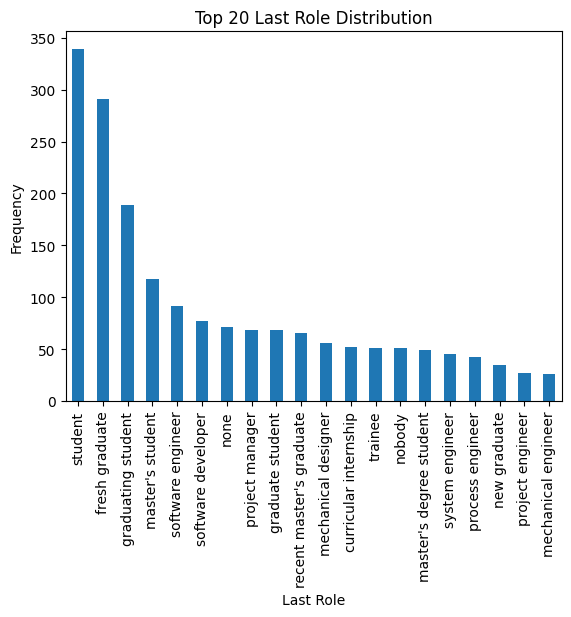

In [258]:
getHist(df[df['Last Role'] != 'not specified'], 'Last Role', None)

In [259]:
df['Last Role'] = df['Last Role'].str.replace('trainee', 'intern')
df['Last Role'] = df['Last Role'].str.replace('backend', 'back-end')
df['Last Role'] = df['Last Role'].str.replace('frontend', 'front-end')
df['Last Role'] = df['Last Role'].str.replace(r'\bpm\b(?![a-zA-Z0-9])', 'project manager')

In [260]:
#neo, engaged, 'Rc20.02904'
last_role_mapping = {
    'Are Managers': 'Area Manager',
    'Civil Cad Engineer': 'Civil Engineer',
    'Civil Engineer Fez': 'Civil Engineer',
    'Consulting': 'Consultant',
    'Cost Control': 'Cost Controller',
    'Data Analysis': 'Data Analyst',
    'Data Scientist': 'Data Scientists',
    'Design': 'Designer',
    'Doctoral Student': 'Doctorate',
    'Post-Doc': 'Doctorate',
    'Freelance': 'Freelancer',
    'Fresh Graduate': 'Graduate',
    'Graduate Student': 'Graduate',
    'Graduated': 'Graduate',
    'Graduated 2023': 'Graduate',
    'Graduated July 2023': 'Graduate',
    'Recent Three-Year Graduate': 'Graduate',
    'New Graduate March 2023': 'Graduate',
    "Master'S Degree Graduate October 2023": 'Graduate',
    'Graduated October 2023': 'Graduate',
    'Graduating 2023': 'Graduating',
    'Graduating Student': 'Graduating',
    'Help Desk': 'Helpdesk Operator',
    'Human Resources Generalist -': 'Human Resources Generalist',
    "I'M Waiting For Cv": 'Not Specified',
    'Internship': 'Intern',
    'Intern/Trainee': 'Intern',
    'Internships': 'Intern',
    'It Consulting': 'It Consultant',
    "Master'S Degree": "Master'S Graduate",
    "Recent Master'S Graduate": "Master'S Graduate",
    "Master'S Student": "Master'S Graduate",
    'New Graduate': 'Graduate',
    'Newly Graduated Student': 'Graduate',
    'Recent Graduate': 'Graduate',
    'Graduate Student - Has Never Worked In The Sector': 'Graduate',
    'Nobody': 'None',
    'Ph.D': 'Phd',
    'Phd Candidates': 'Phd',
    'Ph.D Student': 'Phd Student',
    'Project Design': 'Project Designer',
    'Project Engineer,': 'Project Engineer',
    'Project Engineering': 'Project Engineer',
    'Project Managerr&D': 'Project Manager',
    'Recruiters': 'Recruiter',
    'Researchers': 'Researcher',
    'Salesperson': 'Sales',
    'Software Design': 'Software Designer',
    'Software Engineer |': 'Software Engineer',
    'Student In Physics': 'Student',
    'Students': 'Student',
    'Student Assistant': 'Students Tutor',
    'Supporting Engineer': 'Support Engineer',
    'Systems Engineer': 'Systems Engineer',
    'Substitute Teacher': 'Teacher',
    'Tester Engineer': 'Test Engineer',
    'Testers': 'Tester',
    'Testing': 'Tester',
    'Thesis Internship': 'Thesis Intern',
    'Thesis Student': 'Student',
    'Three-Year Student': 'Student',
    'Web Masters': 'Webmaster',
    'Unemployed': 'None'
}


In [261]:
df['Last Role'] = df['Last Role'].str.title()
df['Last Role'] = df['Last Role'].replace(last_role_mapping)
df['Last Role'] = df['Last Role'].str.lower()

In [262]:
filtered_df = df.copy()
filtered_df = filtered_df[(filtered_df['Last Role'].str.len() < 20) & (filtered_df['Last Role'] != 'not specified')]

In [263]:
print(filtered_df['Last Role'].sort_values().unique())

['.net developer' '.net programmer' 'academic' 'account manager'
 'accountant' 'accounting clerk' 'acting intern' 'adas developer'
 'adas engineer' 'adas passive safety' 'advanced consultant'
 'aerospace engineer' 'ait consultant' 'ait/aiv engineer' 'analyst'
 'analyst consultant' 'analyst programmer' 'android developer'
 'appian consultant' 'apprentice mechanic' 'apprenticeship' 'architect'
 'area manager' 'area sales manager' 'assistant designer'
 'assistant manager' 'automation engineer' 'automotive engineer'
 'automotive intern' 'avl' 'back-end developer' 'back-end engineer'
 'bartender' 'bi consultant' 'bid manager' 'biomedical engineer'
 'brake test engineer' 'business analyst' 'business consultant'
 'business developer' 'business manager' 'business planning' 'buyer'
 'buyer - expediter' 'buyer collaborator' 'c# developer' 'c++ developer'
 'c++ teacher' 'cad designer' 'cad engineer' 'cad point'
 'cad/cae engineer' 'cad/pdm/plm design' 'cae analyst' 'cae consultant'
 'cae engineer

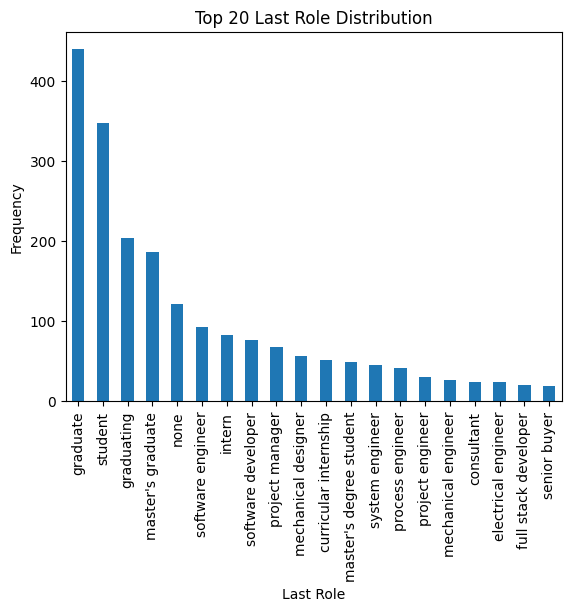

In [264]:
getHist(df[df['Last Role'] != 'not specified'], 'Last Role', None)

## Possible Target Variables
Some possible target variables in this dataset could be:

* **Possible RAL**: a new column that predicts the adequate RAL for the candidate profile. However the dataset contains very few samples with RAL values specified:

In [265]:
#check the percentage of the specified RAL values
for col in df.columns:
  if 'Ral' in col:
    null_perc = null_percentage(df, col, len(candidates))
    multiple_perc = multiple_percentage(df, col, 2, len(candidates))
    print(f"{null_perc:.2f}% of candidates have no {col} specified")
    print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

98.09% of candidates have no Minimum Ral specified
0.00% of candidates have multiple Minimum Ral specified
97.50% of candidates have no Ral Maximum specified
0.02% of candidates have multiple Ral Maximum specified
92.85% of candidates have no Current Ral specified
0.05% of candidates have multiple Current Ral specified
93.74% of candidates have no Expected Ral specified
0.05% of candidates have multiple Expected Ral specified


* **Eligibility**: defines whether a candidate is eligible for each macro-sector served by Akkodis, based on the information provided. Since the job offer is only present if the candidate has been hired, we will consider only hired candidates as eligible, while we must distinguish between candidates who have not been selected ('*Not eligible*') and candidates who have not gone ahead with the recruiting process, who therefore cannot be evaluated.

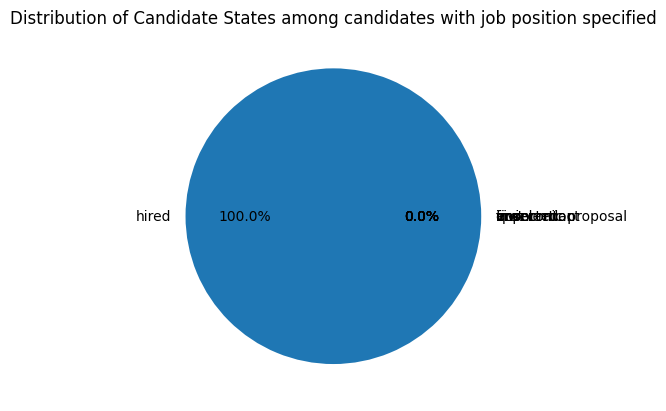

In [266]:
#filtered df with only candidates with job position specified
filtered_df = df.copy()
filtered_df = filtered_df[filtered_df['Job Title Hiring'] != 'not specified']

counts = filtered_df.groupby('Id')['Candidate State'].last().value_counts()
counts_df = pd.DataFrame({'Candidate State': counts.index, 'Count': counts.values})
plt.pie(counts_df['Count'], labels=counts_df['Candidate State'], autopct='%1.1f%%')
plt.title('Distribution of Candidate States among candidates with job position specified')
plt.show()

In [267]:
for col in df.columns:
  null_perc = null_percentage(df, col, len(candidates))
  print(f"{null_perc:.2f}% of candidates have no {col} specified")

0.00% of candidates have no Id specified
0.00% of candidates have no Candidate State specified
0.00% of candidates have no Age Range specified
0.00% of candidates have no Sex specified
0.00% of candidates have no Protected Category specified
78.00% of candidates have no Tag specified
0.31% of candidates have no Study Area specified
0.00% of candidates have no Study Title specified
0.00% of candidates have no Years Experience specified
57.92% of candidates have no Sector specified
58.38% of candidates have no Last Role specified
0.00% of candidates have no Year Of Insertion specified
95.96% of candidates have no Year Of Recruitment specified
96.56% of candidates have no Recruitment Request specified
95.97% of candidates have no Assumption Headquarters specified
95.97% of candidates have no Job Family Hiring specified
96.23% of candidates have no Job Title Hiring specified
11.20% of candidates have no Event_Type__Val specified
77.67% of candidates have no Event_Feedback specified
77.06% 

In [268]:
for col in df.columns:
  mult_perc = multiple_percentage(df, col, 2, len(candidates))
  print(f"{mult_perc:.2f}% of candidates have multiple {col} specified")

0.00% of candidates have multiple Id specified
5.23% of candidates have multiple Candidate State specified
5.84% of candidates have multiple Age Range specified
2.61% of candidates have multiple Sex specified
0.04% of candidates have multiple Protected Category specified
0.49% of candidates have multiple Tag specified
7.60% of candidates have multiple Study Area specified
4.56% of candidates have multiple Study Title specified
4.09% of candidates have multiple Years Experience specified
0.99% of candidates have multiple Sector specified
1.35% of candidates have multiple Last Role specified
5.54% of candidates have multiple Year Of Insertion specified
0.14% of candidates have multiple Year Of Recruitment specified
0.04% of candidates have multiple Recruitment Request specified
0.01% of candidates have multiple Assumption Headquarters specified
0.07% of candidates have multiple Job Family Hiring specified
0.07% of candidates have multiple Job Title Hiring specified
23.65% of candidates h

We can assume that if a candidate doesn't have a `Sector` value specified there's not enough information to evaluate them. The majority of candidates that do not have a value specified for `Sector` have 'Imported' or 'First contact' as `Candidate State`, which are the first stages of the recruiting process. This explains why this kind of samples do not have enough informations and therefore should not be considered as "NOT suitable".

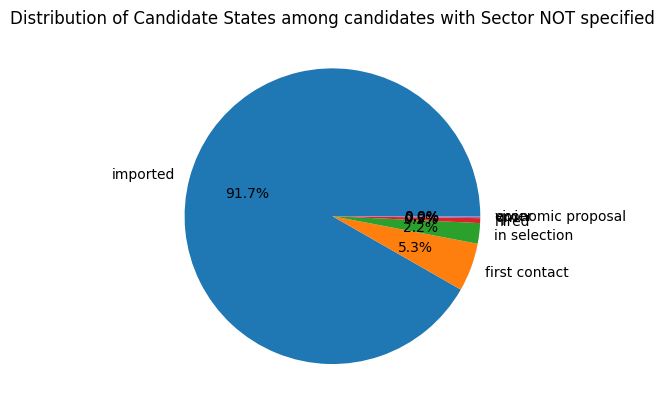

In [269]:
col = 'Sector'
filtered_df = df.copy()
ids = filtered_df.groupby('Id')[col].apply(lambda x: (x == 'not specified').all())
filtered_df = filtered_df[filtered_df['Id'].isin(ids[ids].index)]

counts = filtered_df.groupby('Id')['Candidate State'].last().value_counts()
counts_df = pd.DataFrame({'Candidate State': counts.index, 'Count': counts.values})
plt.pie(counts_df['Count'], labels=counts_df['Candidate State'], autopct='%1.1f%%')
plt.title(f'Distribution of Candidate States among candidates with {col} NOT specified')
plt.show()

For these candidates, no competence score is even specified.

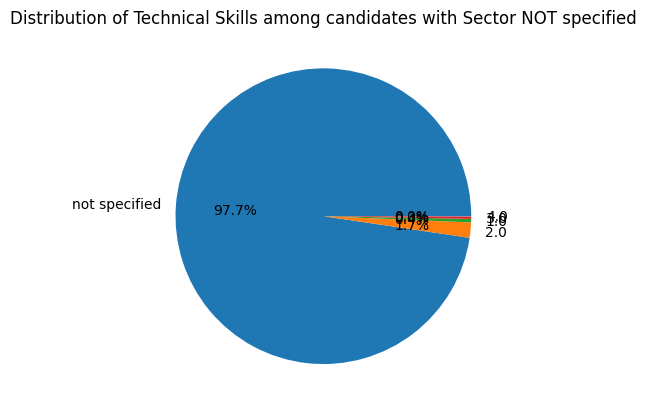

In [270]:
counts = filtered_df.groupby('Id')['Technical Skills'].last().value_counts()
counts_df = pd.DataFrame({'Technical Skills': counts.index, 'Count': counts.values})
plt.pie(counts_df['Count'], labels=counts_df['Technical Skills'], autopct='%1.1f%%')
plt.title(f'Distribution of Technical Skills among candidates with {col} NOT specified')
plt.show()

For all the reasons mentioned above we can choose for now to discard all candidates without specified `Sector` values:

In [271]:
df_cleaned = df[df['Sector'] != 'not specified']
print(f"Number of removed rows: {(df.shape[0] - df_cleaned.shape[0])} ({(df.shape[0] - df_cleaned.shape[0]) / df.shape[0] * 100:.2f}%)")

Number of removed rows: 9163 (42.86%)


In [272]:
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

In [273]:
print(df['Candidate State'].value_counts())

Candidate State
in selection         5287
first contact        3325
hired                2162
qm                    872
economic proposal     434
vivier                132
imported                2
Name: count, dtype: int64


In [274]:
print(df[df['Candidate State'] == 'imported'][candidate_col])

         Id      Age Range Candidate State  Communication       Dynamism  \
4366  42271  31 - 35 years        imported  not specified  not specified   
4367  42271  31 - 35 years        imported  not specified  not specified   

            English Last Role       Maturity       Mobility  \
4366  not specified  graduate  not specified  not specified   
4367  not specified  graduate  not specified  not specified   

     Protected Category  ...            Tag Technical Skills  \
4366                 no  ...  not specified    not specified   
4367                 no  ...  not specified    not specified   

     Year Of Insertion Year Of Recruitment Years Experience    Current Ral  \
4366              2021       not specified            [0-1]  not specified   
4367              2021       not specified            [0-1]  not specified   

       Expected Ral  Residence Country Residence Italian Region  \
4366  not specified              italy                   puglia   
4367  not specified

In [275]:
df_cleaned = df[df['Candidate State'] != 'imported']
print(f"Number of removed rows: {(df.shape[0] - df_cleaned.shape[0])} ({(df.shape[0] - df_cleaned.shape[0]) / df.shape[0] * 100:.2f}%)")

Number of removed rows: 2 (0.02%)


In [276]:
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

## Sample Sorting
To ensure that the last row for each candidate is the most recent one we can sort the dataset:
  * by **ID**: rows of the same candidate will be near
  * by **Year Of Insertion**: If a candidate have more than one value for this column the rows will be chronologically ordered
  * by **Year Of Recruitment**: If a candidate have more than one value for this column (i.e. has been hired multiple times) the rows will be chronologically ordered
  * by **Candidate State**: to reflect the normal hiring process order of events

In [277]:
#sorting
df = df.sort_values(by=['Id', 'Year Of Insertion', 'Year Of Recruitment', 'Candidate State'], ascending=[True, True, True, True], kind='mergesort', na_position='first')
df = df.reset_index(drop=True)

In [278]:
df.head()

Id Candidate State      Age Range     Sex Protected Category  \
0   41   first contact  31 - 35 years    male                 no   
1   47   first contact  36 - 40 years    male                 no   
2   84   first contact  26 - 30 years    male                 no   
3  134   first contact  40 - 45 years    male                 no   
4  137    in selection     < 20 years  female                 no   

                  Tag                                 Study Area  \
0       not specified                     industrial engineering   
1       not specified                     electrical engineering   
2       not specified  civil/civil and environmental engineering   
3       not specified                     communication sciences   
4  project management                     management engineering   

         Study Title Years Experience                            Sector  ...  \
0   five-year degree            [1-3]                            others  ...   
1   five-year degree            [+10]                            energy  ...   
2   five-year degree            [0-1]                            others  ...   
3  three-year degree            [+10]  services and information systems  ...   
4   five-year degree              [0]                            others  ...   

  Technical Skills  Standing/Position  Communication       Maturity  \
0    not specified      not specified  not specified  not specified   
1    not specified      not specified  not specified  not specified   
2    not specified      not specified  not specified  not specified   
3    not specified      not specified  not specified  not specified   
4    not specified      not specified  not specified  not specified   

        Dynamism       Mobility        English Residence Country  \
0  not specified  not specified  not specified             italy   
1  not specified  not specified  not specified           germany   
2  not specified  not specified  not specified             italy   
3  not specified  not specified  not specified             italy   
4  not specified  not specified  not specified             italy   

  Residence Italian Region European Residence  
0                 lombardy           european  
1             not in italy           european  
2           emilia romagna           european  
3                  abruzzo           european  
4                 campania           european  

[5 rows x 41 columns]

## **Data Cleaning**
Check for inconsistencies in the data.
### Candidates with multiple `Candidate State`

In [279]:
print(f"{multiple_percentage(df, 'Candidate State', 2, len(candidates)):.2f}% of candidates have multiple <Candidate State> specified")

1.98% of candidates have multiple <Candidate State> specified


The majority of the candidates have a single value for `Candidate State`, with less than 2% with multiple candidate states.

In [280]:
col = 'Candidate State'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

It looks like different people with the same `Id`.  We can choose the last value for `Candidate State` (which will be the most useful one since we sorted the dataset) as valid and consider the other rows as errors.

In [281]:
print(filtered_df[['Id', col, 'Sex', 'Age Range', 'Residence Italian Region', 'Residence Country']])

          Id Candidate State   Sex      Age Range Residence Italian Region  \
144      946   first contact  male  26 - 30 years                   veneto   
145      946    in selection  male  26 - 30 years                   sicily   
146      946    in selection  male  26 - 30 years                   sicily   
147      946    in selection  male  26 - 30 years                   sicily   
148      946    in selection  male  26 - 30 years                   sicily   
...      ...             ...   ...            ...                      ...   
12145  81271    in selection  male     < 20 years                 piedmont   
12146  81271    in selection  male     < 20 years                 piedmont   
12166  81418   first contact  male     < 20 years             not in italy   
12167  81418    in selection  male  26 - 30 years                   puglia   
12168  81418    in selection  male  26 - 30 years                   puglia   

      Residence Country  
144               italy  
145        

In [282]:
latest_candidate_state = df.groupby('Id')['Candidate State'].last()
valid_rows = df['Id'].map(latest_candidate_state) == df['Candidate State']
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 289 (2.37%)


In [283]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

### Candidates with multiple `Year Of Insertion`


In [287]:
print(f"{multiple_percentage(df,'Year Of Insertion', 2, len(candidates)):.2f}% of candidates have more than one value for <Year Of Insertion>")

0.83% of candidates have more than one value for <Year Of Insertion>


In [288]:
col = 'Year Of Insertion'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [289]:
print(filtered_df[['Id', col, 'Sex', 'Age Range', 'Residence Italian Region']])

          Id  Year Of Insertion   Sex      Age Range Residence Italian Region
136      889               2021  male  31 - 35 years                 piedmont
137      889               2022  male  26 - 30 years                 lombardy
138      889               2022  male  26 - 30 years                 lombardy
139      889               2022  male  26 - 30 years                 lombardy
140      889               2022  male  26 - 30 years                 lombardy
...      ...                ...   ...            ...                      ...
11928  79664               2022  male  26 - 30 years                   puglia
11929  79664               2022  male  26 - 30 years                   puglia
11930  79664               2022  male  26 - 30 years                   puglia
12065  80646               2022  male     > 45 years                    lazio
12066  80646               2023  male  26 - 30 years                   sicily

[192 rows x 5 columns]


In [290]:
#columns that are unlikely to change
const_col = ['Sex', 'Age Range', 'Protected Category']

In [291]:
col = 'Year Of Insertion'
count_changes = df.groupby('Id')[col].nunique()
changing_ids = count_changes[count_changes > 1].index
filtered_df = df[df['Id'].isin(changing_ids)]

In [292]:
for col in const_col:
  multiple_perc = multiple_percentage(filtered_df, col, 2, filtered_df['Id'].unique().shape[0])
  print(f"{multiple_perc:.2f}% of candidates that have multiple <Year Of Insertion> have also more than one <{col}> specified")

25.58% of candidates that have multiple <Year Of Insertion> have also more than one <Sex> specified
83.72% of candidates that have multiple <Year Of Insertion> have also more than one <Age Range> specified
0.00% of candidates that have multiple <Year Of Insertion> have also more than one <Protected Category> specified


1% of candidates have multiple values for `Year Of Insertion`. 25% of candidates that have more than one `Year Of Insertion` also have different values specified for `Sex` while 80% have different values specified for `Age Range`. This could mean that different candidates could have the same `Id` by mistake. However we can consider the most recent `Year Of Insertion` in the Akkodis database as valid and discard the other entries:

In [293]:
latest_year_ins = df.groupby('Id')['Year Of Insertion'].last()
valid_rows = df['Id'].map(latest_year_ins) == df['Year Of Insertion']
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 98 (0.82%)


In [294]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

### Candidates with multiple `Year Of Recruitment`


In [295]:
print(f"{multiple_percentage(df,'Year Of Recruitment', 2, len(candidates)):.2f}% of candidates have more than one value for <Year Of Recruitment>")

0.25% of candidates have more than one value for <Year Of Recruitment>


Since less than 1% of candidates have more than one values for `Year Of Recruitment` we can assume this cases as noise and keep the most recent one.

In [296]:
df['Year Of Recruitment'] = df['Year Of Recruitment'].fillna('Not Specified')
df['Year Of Recruitment'] = df['Year Of Recruitment'].replace('', 'Not Specified')
latest_year_rec = df.groupby('Id')['Year Of Recruitment'].last()
valid_rows = df['Id'].map(latest_year_rec) == df['Year Of Recruitment']
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 64 (0.54%)


In [297]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

### Columns that are unlikely to change
We can check again if any candidate changes `Sex`, `Age Range` or `Protected Category`:

In [298]:
for col in const_col:
  multiple_perc = multiple_percentage(df, col, 2, len(candidates))
  print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

0.19% of candidates have multiple Sex specified
0.45% of candidates have multiple Age Range specified
0.00% of candidates have multiple Protected Category specified


We can consider as noise multiple values for `Sex` and keep the most recent one as valid.

In [299]:
latest_sex = df.groupby('Id')['Sex'].last()
valid_rows = df['Id'].map(latest_sex) == df['Sex']
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 17 (0.14%)


In [300]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

In [301]:
col = 'Age Range'
multiple_perc = multiple_percentage(df, col, 2, len(candidates))
print(f"{multiple_perc:.2f}% of candidates still have multiple {col} specified")

0.33% of candidates still have multiple Age Range specified


We need to check if the age change is due to time or noise:

In [302]:
count_changes = df.groupby('Id')[col].nunique()
changing_ids = count_changes[count_changes > 1].index
#df with only candidates that change age
filtered_df = df[df['Id'].isin(changing_ids)]

In [303]:
age_range_order = {
    '< 20 years': 1,
    '20 - 25 years': 2,
    '26 - 30 years': 3,
    '31 - 35 years': 4,
    '36 - 40 years': 5,
    '40 - 45 years': 6,
    '> 45 years': 7
}

In [304]:
filtered_df = filtered_df.copy()
filtered_df['Age Range Numeric'] = filtered_df['Age Range'].map(age_range_order)
order_check = filtered_df.groupby('Id').apply(check_order)
not_ordered_ids = order_check[~order_check].index
print(f"There are {len(not_ordered_ids)} ({len(not_ordered_ids)/len(candidates)*100:.2f}%) candidates that become younger")

There are 17 (0.33%) candidates that become younger


<ipython-input-304-33dbc4b7f63a>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  order_check = filtered_df.groupby('Id').apply(check_order)


100% of candidates with different values for `Age Range` are not coherent with the time, as they are becoming younger. Of these candidates we can keep the last value of `Age Range` as valid and discard the other entries:

In [305]:
latest_age = df.groupby('Id')['Age Range'].last()
valid_rows = df['Id'].map(latest_age) == df['Age Range']
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 23 (0.20%)


In [306]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

In [307]:
#Other columns that are unlikely to change
const_cols = ['Study Area', 'Study Title', 'Years Experience', 'Sector']

In [308]:
tot_rows = df.shape[0]

for col in const_cols:
    count_changes = df.groupby('Id')[col].nunique()
    changing_ids = count_changes[count_changes > 1].index
    row_count = df[df['Id'].isin(changing_ids)].shape[0]
    row_percentage = (row_count / tot_rows) * 100
    candidate_count = count_changes[count_changes > 1].shape[0]
    cand_percentage = (candidate_count / len(candidates)) * 100
    print(f"The value of {col} changes in {row_count} rows ({row_percentage:.2f}%), {candidate_count} candidates ({cand_percentage:.2f}%)")
    print(changing_ids)
    print("\n\n")


The value of Study Area changes in 12 rows (0.10%), 3 candidates (0.06%)
Index([25959, 61260, 77070], dtype='int64', name='Id')



The value of Study Title changes in 2 rows (0.02%), 1 candidates (0.02%)
Index([61260], dtype='int64', name='Id')



The value of Years Experience changes in 7 rows (0.06%), 2 candidates (0.04%)
Index([61260, 77070], dtype='int64', name='Id')



The value of Sector changes in 5 rows (0.04%), 1 candidates (0.02%)
Index([25959], dtype='int64', name='Id')





In [309]:
print(df[df['Id'] == 25959][['Residence Italian Region', 'Sector', 'Study Title', 'Study Area']])

latest_sec = df.groupby('Id')['Sector'].last()
valid_rows = df['Id'].map(latest_sec) == df['Sector']
df_cleaned = df[valid_rows]

df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

print("\n\n")
print(df[df['Id'] == 25959][['Residence Italian Region', 'Sector', 'Study Title', 'Study Area']])

     Residence Italian Region                            Sector  \
3926                 lombardy                            others   
3927                 lombardy                            others   
3928                 piedmont  services and information systems   
3929                 piedmont  services and information systems   
3930                 piedmont  services and information systems   

           Study Title              Study Area  
3926  five-year degree  mechanical engineering  
3927  five-year degree  mechanical engineering  
3928  five-year degree    computer engineering  
3929  five-year degree    computer engineering  
3930  five-year degree    computer engineering  



     Residence Italian Region                            Sector  \
3928                 piedmont  services and information systems   
3929                 piedmont  services and information systems   
3930                 piedmont  services and information systems   

           Study Title         

In [310]:
print(df[df['Id'].isin([61260, 77070])][['Id', 'Residence Italian Region', 'Years Experience', 'Study Title', 'Study Area']])

latest_exp = df.groupby('Id')['Years Experience'].last()
valid_rows = df['Id'].map(latest_exp) == df['Years Experience']
df_cleaned = df[valid_rows]

df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

print("\n\n")
print(df[df['Id'].isin([61260, 77070])][['Id', 'Residence Italian Region', 'Years Experience', 'Study Title', 'Study Area']])

          Id Residence Italian Region Years Experience        Study Title  \
9160   61260                 lombardy            [1-3]   five-year degree   
9161   61260             not in italy              [0]  three-year degree   
11547  77070                 piedmont            [1-3]  three-year degree   
11548  77070                 piedmont            [1-3]  three-year degree   
11549  77070                 piedmont            [1-3]  three-year degree   
11550  77070                 lombardy              [0]  three-year degree   
11551  77070                 lombardy              [0]  three-year degree   

                                Study Area  
9160   automation/mechatronics engineering  
9161                mechanical engineering  
11547                          informatics  
11548                          informatics  
11549                          informatics  
11550            other scientific subjects  
11551            other scientific subjects  



          Id Residen

###Unuseful columns
#### `Linked_Search__Key`
This feature could have a huge impact in the analysis since it's specific for each job position and can be found also in candidates that were not hired for a specific position.

In [48]:
lsk_perc = null_percentage(df, 'Linked_Search__Key', len(candidates))
print(f"{lsk_perc:.2f}% of candidates have no <Linked_Search__Key> specified")

51.25% of candidates have no <Linked_Search__Key> specified


In [49]:
mult_perc = multiple_percentage(df, 'Linked_Search__Key', 2, len(candidates))
print(f"{mult_perc:.2f}% of candidates have multiple <Linked_Search__Key> specified")

12.48% of candidates have multiple <Linked_Search__Key> specified


Multiple values of `Linked_Search__Key` could have different meanings:
- different values after `.` as the search for the same position is going on and so the number of searches is increasing
- the candidate is being evaluated for different positions

In [50]:
filtered_df = df.copy()
filtered_df['Linked_Search__Key___Prefix'] = df['Linked_Search__Key'].str.extract(r'^([^\.]+)')

mult_perc = multiple_percentage(filtered_df, 'Linked_Search__Key___Prefix', 2, filtered_df['Id'].unique().shape[0])
print(f"{mult_perc:.2f}% of candidates who have multiple <Linked_Search__Key> also have multiple <Linked_Search__Key___Prefix> specified")


7.31% of candidates who have multiple <Linked_Search__Key> also have multiple <Linked_Search__Key___Prefix> specified


Even if `Linked_Search__Key` "indicates the number of searches conducted for a job position",unfortunately it does not contain any unique identifier for the job position as the only values before `.` are:


In [51]:
lsk_values = df['Linked_Search__Key'].unique().tolist()
lsk_values = [re.match(r'^([^\.]+)', s).group(1) for s in lsk_values if isinstance(s, str)]
lsk_values = [s for s in lsk_values if s != 'Not Specified']
lsk_values = list(set(lsk_values))

print(np.sort(lsk_values))


['RS18' 'RS19' 'RS20' 'RS21' 'RS22' 'RS23' 'RS24' 'not specified']


The number between `RS` and `.` could be the 'Year Of Insertion' of the Job Position **??**

45% of candidates with no job position specified have `Linked_Search__Key`.

In [53]:
filtered_df = df.loc[df['Job Title Hiring'] == 'not specified']
lsk_perc = null_percentage(filtered_df, 'Linked_Search__Key', filtered_df['Id'].unique().shape[0])
print(f"{lsk_perc:.2f}% of candidates that have <Job Title Hiring> not specified have no <Linked_Search__Key> specified\n\n")
mult_perc = multiple_percentage(filtered_df, 'Linked_Search__Key', 2, filtered_df['Id'].unique().shape[0])
print(f"{mult_perc:.2f}% of candidates that have <Job Title Hiring> not specified have multiple <Linked_Search__Key> specified")

55.56% of candidates that have <Job Title Hiring> not specified have no <Linked_Search__Key> specified


10.63% of candidates that have <Job Title Hiring> not specified have multiple <Linked_Search__Key> specified


For each hired candidate, `Linked_Search__Key` is specified, with 35% having more than one value, but less than 20% having more than one value for the prefix.

In [54]:
filtered_df = df.loc[df['Job Title Hiring'] != 'not specified']
lsk_perc = null_percentage(filtered_df, 'Linked_Search__Key', filtered_df['Id'].unique().shape[0])
print(f"{lsk_perc:.2f}% of candidates that have <Job Title Hiring> specified have no <Linked_Search__Key> specified\n\n")
mult_perc = multiple_percentage(filtered_df, 'Linked_Search__Key', 2, filtered_df['Id'].unique().shape[0])
print(f"{mult_perc:.2f}% of candidates that have <Job Title Hiring> specified have multiple <Linked_Search__Key> specified")

0.00% of candidates that have <Job Title Hiring> specified have no <Linked_Search__Key> specified


34.59% of candidates that have <Job Title Hiring> specified have multiple <Linked_Search__Key> specified


In [55]:
filtered_df = filtered_df.copy()
filtered_df['Linked_Search__Key___Prefix'] = filtered_df['Linked_Search__Key'].str.extract(r'^([^\.]+)')

In [56]:
mult_perc = multiple_percentage(filtered_df, 'Linked_Search__Key___Prefix', 2, filtered_df['Id'].unique().shape[0])
print(f"{mult_perc:.2f}% of candidates that have <Job Title Hiring> specified have multiple <Linked_Search__Key___Prefix> specified")

19.80% of candidates that have <Job Title Hiring> specified have multiple <Linked_Search__Key___Prefix> specified


Some entries contains `Linked_Search__Key` values in the `Recruitment Request` field.

In [58]:
col = 'Recruitment Request'
values = df[col].unique().tolist()
values = [s for s in values if 'rs' in s]
print(f"{len(values)} recruitment requests contain <Linked_Search__key> values:\n {np.sort(values)}")

72 recruitment requests contain <Linked_Search__key> values:
 ['3 software engineer – microservices design & development_senior (>5 years)'
 'business managers 1' 'business managers 5'
 'career week university of siena - 12 october 2022 - in person'
 'controllers' 'hardware specialist support for sl&ss simulators'
 'java and c++ developers' 'passive safety - sensors'
 'rs18.0258 - aerospace engineering nursery'
 'rs18.0351 - junior recruiter' 'rs18.0438 - c++ / qt - urgent'
 'rs18.0470 - brake measurement engineer.' 'rs18.0519 - team manager'
 'rs18.0583 - business manager' 'rs18.0655 - asic designer'
 'rs18.0661 - infotainment test engineer'
 'rs18.0670 - junior project manager' 'rs18.0684 - airworthiness engineer'
 'rs18.0744 - business-manager amas - bologna'
 'rs18.0798 - project engineer/project manager'
 'rs18.0824 - hardware iot designer' 'rs18.0889 - software engineer linux'
 'rs19.0060 - office internship. acquisitions'
 'rs19.0061  - c++ / qt - very urgent' 'rs19.0095 - softw

In [61]:
filtered_df = df[df.apply(lambda row: row['Linked_Search__Key'] != 'not specified' and str(row['Linked_Search__Key']).lower() in str(row['Recruitment Request']), axis=1)]

print(f"There are {filtered_df.shape[0]} rows with same value of <Linked_Search__Key> contained also in <Recruitment Request>  \n\n")
print(filtered_df[['Id', 'Linked_Search__Key', 'Recruitment Request']])

There are 153 rows with same value of <Linked_Search__Key> contained also in <Recruitment Request>  


          Id Linked_Search__Key  \
154     1006          RS19.0865   
155     1006          RS19.0865   
156     1006          RS19.0865   
1290    8209          RS18.0824   
1321    8359          RS18.0684   
...      ...                ...   
11867  79384          RS19.0491   
11868  79384          RS19.0491   
11869  79384          RS19.0491   
11984  80148          RS19.0839   
11985  80148          RS19.0839   

                                     Recruitment Request  
154                  rs19.0865 -team procurement - milan  
155                  rs19.0865 -team procurement - milan  
156                  rs19.0865 -team procurement - milan  
1290                   rs18.0824 - hardware iot designer  
1321                  rs18.0684 - airworthiness engineer  
...                                                  ...  
11867                       rs19.0491 - business manager  
1186

In [75]:
filtered_df = df[
    df.apply(
        lambda row:(
          row['Linked_Search__Key'] == 'not specified' and
          bool(re.search(r'rs\d{2}\.\d{4}', str(row['Recruitment Request'])))
        ),
        axis=1
    )
]

print(f"There are {filtered_df.shape[0]} rows with <Linked_Search__Key> not specified but contained in <Recruitment Request>  \n\n")
print(filtered_df[['Id', 'Linked_Search__Key', 'Recruitment Request']])

There are 59 rows with <Linked_Search__Key> not specified but contained in <Recruitment Request>  


          Id Linked_Search__Key  \
233     1579      not specified   
1288    8209      not specified   
1291    8209      not specified   
1319    8359      not specified   
1320    8359      not specified   
1375    8778      not specified   
1493    9580      not specified   
1677   10890      not specified   
2252   14947      not specified   
2465   16281      not specified   
2540   16692      not specified   
2896   19760      not specified   
2939   20073      not specified   
3281   22012      not specified   
3283   22012      not specified   
3287   22012      not specified   
3354   22315      not specified   
3356   22315      not specified   
3377   22458      not specified   
3378   22458      not specified   
4636   30876      not specified   
4638   30876      not specified   
4705   31365      not specified   
4707   31365      not specified   
4708   31365      not sp

In [67]:
filtered_df = df[
    df.apply(
        lambda row: (
            str(row['Linked_Search__Key']) != 'not specified' and
            str(row['Recruitment Request']) != 'not specified' and
            bool(re.search(r'rs\d{2}\.\d{4}', str(row['Recruitment Request']))) and
            str(row['Linked_Search__Key']).lower() not in str(row['Recruitment Request'])
        ),
        axis=1
    )
]

print(f"There are {filtered_df.shape[0]} rows with different 'Linked_Search__Key' values specified in <Linked_Search__Key> and <Recruitment Request>  \n\n")
print(filtered_df[['Id', 'Linked_Search__Key', 'Recruitment Request', 'Year Of Insertion']])

There are 46 rows with different 'Linked_Search__Key' values specified in <Linked_Search__Key> and <Recruitment Request>  


          Id Linked_Search__Key  \
232     1579          RS18.0825   
234     1579          RS18.0825   
1286    8209          RS18.0759   
1287    8209          RS18.0662   
1289    8209          RS18.0759   
1586   10101          RS18.0678   
1678   10890          RS18.0383   
1679   10890          RS18.0383   
1680   10890          RS18.0859   
1681   10890          RS18.0859   
2940   20073          RS18.0698   
2941   20073          RS18.0698   
3282   22012          RS18.0758   
3284   22012          RS19.0420   
3285   22012          RS18.0758   
3286   22012          RS18.0758   
3288   22012          RS19.0420   
3352   22315          RS19.0106   
3353   22315          RS19.0106   
3355   22315          RS18.0687   
3357   22315          RS18.0692   
4637   30876          RS18.0707   
4639   30876          RS18.0707   
4640   30876          RS18.0707   


In [83]:
filtered_df = df.copy()
filtered_df['Linked_Search__Key___Prefix'] = filtered_df['Linked_Search__Key'].str.extract(r'^([^\.]+)')

if not filtered_df.empty:
    filtered_df = filtered_df[
        filtered_df.apply(
            lambda row: (
                str(row['Linked_Search__Key___Prefix']) != 'not specified' and
                str(row['Recruitment Request']) != 'not specified' and
                bool(re.search(r'rs\d{2}\.\d{4}', str(row['Recruitment Request']))) and
                str(row['Linked_Search__Key___Prefix']).lower() not in str(row['Recruitment Request'])
            ),
            axis=1
        )
    ]

    print(f"There are {filtered_df.shape[0]} rows with different 'Linked_Search__Key___Prefix' values specified in <Linked_Search__Key> and <Recruitment Request>  \n\n")
    print(filtered_df[['Id', 'Linked_Search__Key', 'Linked_Search__Key___Prefix', 'Recruitment Request', 'Year Of Insertion']])
else:
    print("filtered_df is empty after applying the initial filter. Check your filtering conditions.")

There are 13 rows with different 'Linked_Search__Key___Prefix' values specified in <Linked_Search__Key> and <Recruitment Request>  


          Id Linked_Search__Key Linked_Search__Key___Prefix  \
232     1579          RS18.0825                        RS18   
234     1579          RS18.0825                        RS18   
2940   20073          RS18.0698                        RS18   
2941   20073          RS18.0698                        RS18   
3282   22012          RS18.0758                        RS18   
3285   22012          RS18.0758                        RS18   
3286   22012          RS18.0758                        RS18   
3355   22315          RS18.0687                        RS18   
3357   22315          RS18.0692                        RS18   
4706   31365          RS18.0531                        RS18   
8899   59626          RS19.0030                        RS19   
10251  68155          RS18.0888                        RS18   
10907  72671          RS18.0383                

After the above considerations we can discard the column and remove its values ​​from `Recruitment Request`.

In [311]:
df = df.drop(columns=['Linked_Search__Key'])

In [312]:
df['Recruitment Request'] = df['Recruitment Request'].str.replace(r'\bRS\d+\.\d+\s*-\s*', '', regex=True)
df['Recruitment Request'] = df['Recruitment Request'].str.strip()

In [313]:
job_offer_columns.remove('Linked_Search__Key')

## **Job Positions**
The job position is specified only for candidates who have been hired for that position. The other candidates have no information regarding the position for which they were not selected.

In [315]:
print(f"{df[(df['Year Of Recruitment'] == 'not specified') & (df['Job Title Hiring'] != 'not specified')].shape[0]} candidates have a specified position but have not been hired")

0 candidates have a specified position but have not been hired


In [316]:
for col in job_offer_columns:
  n = df[(df['Candidate State'] == 'hired') & (df[col] == 'not specified')]['Id'].unique().shape[0]
  print(f"{n} candidates have 'Hired' as <Candidate State> but have no <{col}> specified")

68 candidates have 'Hired' as <Candidate State> but have no <Recruitment Request> specified
3 candidates have 'Hired' as <Candidate State> but have no <Assumption Headquarters> specified
3 candidates have 'Hired' as <Candidate State> but have no <Job Family Hiring> specified
34 candidates have 'Hired' as <Candidate State> but have no <Job Title Hiring> specified
76 candidates have 'Hired' as <Candidate State> but have no <Job Description> specified
89 candidates have 'Hired' as <Candidate State> but have no <Candidate Profile> specified
66 candidates have 'Hired' as <Candidate State> but have no <Years Experience.1> specified
234 candidates have 'Hired' as <Candidate State> but have no <Minimum Ral> specified
171 candidates have 'Hired' as <Candidate State> but have no <Ral Maximum> specified
66 candidates have 'Hired' as <Candidate State> but have no <Study Level> specified
115 candidates have 'Hired' as <Candidate State> but have no <Study Area.1> specified


3 candidates have no job position specified but have 'Hired' as `Candidate State`. Since there is no way to know for which position they were eligible we can discard them.

In [317]:
cand_to_drop = df[(df['Candidate State'] == 'hired') & (df['Job Family Hiring'] == 'not specified')]['Id'].unique().tolist()

In [318]:
print(df[df['Id'].isin(cand_to_drop)][['Id','Candidate State', 'Job Family Hiring', 'Job Title Hiring', 'Study Area.1', 'Study Area']])

          Id Candidate State            Job Family Hiring Job Title Hiring  \
3238   21723           hired                not specified    not specified   
3239   21723           hired                not specified    not specified   
3240   21723           hired                not specified    not specified   
3241   21723           hired                not specified    not specified   
3242   21723           hired                not specified    not specified   
8288   55312           hired                not specified    not specified   
11965  79993           hired  tech consulting & solutions       consultant   
11966  79993           hired  tech consulting & solutions       consultant   
11967  79993           hired  tech consulting & solutions       consultant   
11968  79993           hired  tech consulting & solutions       consultant   
11969  79993           hired  tech consulting & solutions       consultant   
11970  79993           hired                not specified    not

For now we will discard the last row (11970), and the two candidates (21723, 55312) with no position specified.

In [319]:
rows = df.shape[0]
df = df.drop(11970)

In [320]:
df = df[~df['Id'].isin([21723, 55312])]
print(f"Number of removed rows: {rows - df.shape[0]}")

Number of removed rows: 7


In [321]:
candidates = df['Id'].unique().tolist()

We can assume that each candidate has only one job position specified, if hired. Only 0.06% of hired candidates have more than one job position specified.

In [322]:
hired_df =df[~(df['Year Of Recruitment'] == 'not specified')]
n_candidates = hired_df.groupby('Id')['Job Title Hiring'].apply(lambda x: x.dropna().nunique())
n_candidates = n_candidates[n_candidates > 1]
index = n_candidates.index
print(f"{len(n_candidates)} ({len(n_candidates)/len(candidates) * 100:.2f}%) candidates have multiple 'Job Title Hiring' specified")

3 (0.06%) candidates have multiple 'Job Title Hiring' specified


Looking at the three candidates in question we can see that they do not have multiple positions specified, they only have duplicate rows with small differences:

In [323]:
for id in index:
  print(df[df['Id'] == id][['Id', 'Job Title Hiring', 'Job Family Hiring', 'Job Description', 'Event_Type__Val']])
  print("\n \n")

       Id   Job Title Hiring Job Family Hiring  \
513  3472         technician       engineering   
514  3472  junior consultant       engineering   
515  3472         technician       engineering   
516  3472  junior consultant       engineering   
517  3472         technician       engineering   
518  3472  junior consultant       engineering   
519  3472         technician       engineering   
520  3472  junior consultant       engineering   

                              Job Description         Event_Type__Val  
513  new engineer graduates available in pisa  candidate notification  
514  new engineer graduates available in pisa  candidate notification  
515  new engineer graduates available in pisa  candidate notification  
516  new engineer graduates available in pisa  candidate notification  
517  new engineer graduates available in pisa            bm interview  
518  new engineer graduates available in pisa            bm interview  
519  new engineer graduates available in pisa

In [324]:
#fixing the 3 candidates
df = df[~((df['Id'] == 3472) & (df['Job Title Hiring'] == 'technician'))]
df = df[~((df['Id'] == 32188) & (df['Job Title Hiring'] == 'technician'))]
df = df[~((df['Id'] == 75854) & (df['Job Title Hiring'] == 'consultant'))]

df.loc[(df['Id'] == 3472) & (df['Job Title Hiring'] == 'Junior Consultant'), 'Job Title Hiring'] = 'technician junior consultant'
df.loc[(df['Id'] == 32188) & (df['Job Title Hiring'] == 'Junior Consultant'), 'Job Title Hiring'] = 'technician junior consultant'


In [325]:
for id in index:
  print(df[df['Id'] == id][['Id', 'Job Title Hiring', 'Job Family Hiring', 'Job Description', 'Event_Type__Val']])
  print("\n \n")

       Id   Job Title Hiring Job Family Hiring  \
514  3472  junior consultant       engineering   
516  3472  junior consultant       engineering   
518  3472  junior consultant       engineering   
520  3472  junior consultant       engineering   

                              Job Description         Event_Type__Val  
514  new engineer graduates available in pisa  candidate notification  
516  new engineer graduates available in pisa  candidate notification  
518  new engineer graduates available in pisa            bm interview  
520  new engineer graduates available in pisa            bm interview  

 

         Id   Job Title Hiring Job Family Hiring  \
4833  32188  junior consultant       engineering   
4835  32188  junior consultant       engineering   
4837  32188  junior consultant       engineering   

                                        Job Description Event_Type__Val  
4833  the candidate will be responsible for • requir...    contact note  
4835  the candidate will be 

In the dataset there are now 300 different *Job Offers* specified and 400 candidates hired for them. Each position has at least 1 hired candidate and some have more than one.

In [326]:
n_hired_candidates = hired_df['Id'].unique().shape[0]
print(f"In the dataset there are {n_hired_candidates} ({n_hired_candidates/len(candidates)*100:.2f}%) hired candidates and {hired_df['Job Description'].unique().shape[0]} different 'Job Description' specified")

In the dataset there are 430 (8.34%) hired candidates and 303 different 'Job Description' specified


## Columns that still change

In [327]:
cols = []

for col in df.columns:
  multiple_perc = multiple_percentage(df, col, 2, len(candidates))
  if multiple_perc > 0:
    cols.append(col)
    print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

0.06% of candidates have multiple Tag specified
0.04% of candidates have multiple Last Role specified
0.02% of candidates have multiple Assumption Headquarters specified
42.00% of candidates have multiple Event_Type__Val specified
16.08% of candidates have multiple Event_Feedback specified
11.42% of candidates have multiple Overall specified
0.10% of candidates have multiple Job Description specified
0.19% of candidates have multiple Candidate Profile specified
12.53% of candidates have multiple Technical Skills specified
13.24% of candidates have multiple Standing/Position specified
14.00% of candidates have multiple Communication specified
14.37% of candidates have multiple Maturity specified
15.47% of candidates have multiple Dynamism specified
15.69% of candidates have multiple Mobility specified
9.81% of candidates have multiple English specified


### Last Role

In [334]:
col = 'Last Role'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [335]:
print(filtered_df[['Id', col, 'Sex', 'Age Range', 'Residence Italian Region']])

Empty DataFrame
Columns: [Id, Last Role, Sex, Age Range, Residence Italian Region]
Index: []


In [332]:
last_role = df.loc[7718, 'Last Role'] + ', ' + df.loc[7719, 'Last Role']
df.loc[df['Id'] == 50935, 'Last Role'] = last_role

In [333]:
last_role = df.loc[11499, 'Last Role'] + ', ' + df.loc[11500, 'Last Role']
df.loc[df['Id'] == 76752, 'Last Role'] = last_role

### Tag

In [340]:
col = 'Tag'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [341]:
print(filtered_df[['Id', col, 'Sex', 'Age Range', 'Event_Type__Val']])

Empty DataFrame
Columns: [Id, Tag, Sex, Age Range, Event_Type__Val]
Index: []


In [338]:
df.loc[3957, 'Tag'] = df.loc[3956, 'Tag']
df.loc[1121, 'Tag'] = df.loc[1122, 'Tag']
df.loc[5529, 'Tag'] = df.loc[5528, 'Tag']

### Assumption Headquarters

In [342]:
col = 'Assumption Headquarters'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [343]:
print(filtered_df[['Id', col, 'Sex', 'Age Range', 'Event_Type__Val', 'Event_Feedback', 'Overall']])

         Id Assumption Headquarters   Sex   Age Range Event_Type__Val  \
4349  28587                   milan  male  < 20 years    contact note   
4350  28587                   turin  male  < 20 years    contact note   
4351  28587                   milan  male  < 20 years    bm interview   
4352  28587                   turin  male  < 20 years    bm interview   
4353  28587                   milan  male  < 20 years    bm interview   
4354  28587                   turin  male  < 20 years    bm interview   

     Event_Feedback        Overall  
4349  not specified  not specified  
4350  not specified  not specified  
4351             ok            2.0  
4352             ok            2.0  
4353             ok            2.0  
4354             ok            2.0  


In [344]:
latest = df.groupby('Id')[col].last()
valid_rows = df['Id'].map(latest) == df[col]
df_cleaned = df[valid_rows]

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")

Number of removed rows: 3 (0.03%)


In [345]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

### Job Description

In [351]:
col = 'Job Description'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [352]:
print(filtered_df[['Id', col, 'Event_Type__Val', 'Event_Feedback', 'Overall', 'Last Role']])

Empty DataFrame
Columns: [Id, Job Description, Event_Type__Val, Event_Feedback, Overall, Last Role]
Index: []


In [348]:
df.loc[1086, col] = df.loc[1087, col]
df.loc[4831, col] = df.loc[4830, col]
job_descr = df.loc[5655, col]
df.loc[df['Id'] == 37540, col] = job_descr
job_descr = df.loc[8956, col]
df.loc[df['Id'] == 59906, col] = job_descr
job_descr = df.loc[5638, col]
df.loc[df['Id'] == 37451, col] = job_descr

In [349]:
df_cleaned = df.drop([10991, 10993, 10995])

print(f"Number of removed rows: {len(df) - len(df_cleaned)} ({(len(df) - len(df_cleaned))/len(df) * 100:.2f}%)")


Number of removed rows: 3 (0.03%)


In [350]:
#Dataset Update
df = df_cleaned.copy()
candidates = df['Id'].unique().tolist()

### Candidate Profile

In [357]:
col = 'Candidate Profile'
multiple_counts = df.groupby('Id')[col].apply(lambda x: x.dropna().nunique())
ids_with_multiple_values = multiple_counts[multiple_counts > 1]
filtered_df = df[df['Id'].isin(ids_with_multiple_values.index)]

In [358]:
print(filtered_df[['Id', col, 'Job Title Hiring', 'Event_Type__Val', 'Event_Feedback', 'Overall']])

Empty DataFrame
Columns: [Id, Candidate Profile, Job Title Hiring, Event_Type__Val, Event_Feedback, Overall]
Index: []


In [355]:
cp = df.loc[1455, col]
df.loc[df['Id'] == 9483, col] = cp
cp = df.loc[1711, col]
df.loc[df['Id'] == 11042, col] = cp
cp = df.loc[2243, col]
df.loc[df['Id'] == 14915, col] = cp
df.loc[2665, col] = df.loc[2666, col]
cp = df.loc[5352, col]
df.loc[df['Id'] == 35649, col] = cp
cp = df.loc[5640, col]
df.loc[df['Id'] == 37499, col] = cp
cp = df.loc[5963, col]
df.loc[df['Id'] == 39653, col] = cp
cp = df.loc[7573, col]
df.loc[df['Id'] == 49795, col] = cp
cp = df.loc[8134, col]
df.loc[df['Id'] == 54068, col] = cp
cp = df.loc[8922, col]
df.loc[df['Id'] == 59717, col] = cp
cp = df.loc[10907, col]
df.loc[df['Id'] == 72671, col] = cp

In [356]:
#candidate profile wasn't completely anonimized
cp_list = df.loc[df['Id'] == 14915, col].tolist()

for cp in cp_list:
  print(cp)

excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of  products good familiarity with laboratory testing activities (in particular for functional tests on targets)
excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v&v process good knowledge of the functionality of tms systems knowledge is appreciated of  products good familiarity with laboratory testing activities (in particular for functional tests on targets)
excellent references for product/subsystem v&v activities for the railway sector excellent references in conducting product/system validation/integration test activities good knowledge of the alstom v

In [359]:
for col in df.columns:
  multiple_perc = multiple_percentage(df, col, 2, len(candidates))
  if multiple_perc > 0:
    print(f"{multiple_perc:.2f}% of candidates have multiple {col} specified")

42.00% of candidates have multiple Event_Type__Val specified
16.08% of candidates have multiple Event_Feedback specified
11.42% of candidates have multiple Overall specified
12.53% of candidates have multiple Technical Skills specified
13.24% of candidates have multiple Standing/Position specified
14.00% of candidates have multiple Communication specified
14.37% of candidates have multiple Maturity specified
15.47% of candidates have multiple Dynamism specified
15.69% of candidates have multiple Mobility specified
9.81% of candidates have multiple English specified


After the data cleaning we have removed:

In [361]:
print(f"Total number of removed rows: {original_df.shape[0] - df.shape[0]} ({(original_df.shape[0] - df.shape[0])/original_df.shape[0]*100:.2f}%)")

Total number of removed rows: 9685 (45.31%)


##New Cleaned Dataset

In [469]:
df.to_excel(cleaned_file_path, index=False)

In [470]:
#files.download(new_path)
#load to drive
destination_path = drive_dir + cleaned_file_path
!cp "$cleaned_file_path" "$destination_path"

##Feature Analysis

In [201]:
df = pd.read_excel(cleaned_file_path)

In [364]:
candidates = df['Id'].unique().tolist()

### **`Candidate State`**

In [365]:
#custom_order = ['Imported', 'First contact', 'In selection', 'QM', 'Vivier', 'Economic proposal', 'Hired']
custom_order = ['first contact', 'in selection', 'qm', 'vivier', 'economic proposal', 'hired']
df['Candidate State'] = pd.Categorical(df['Candidate State'], categories=custom_order, ordered=True)

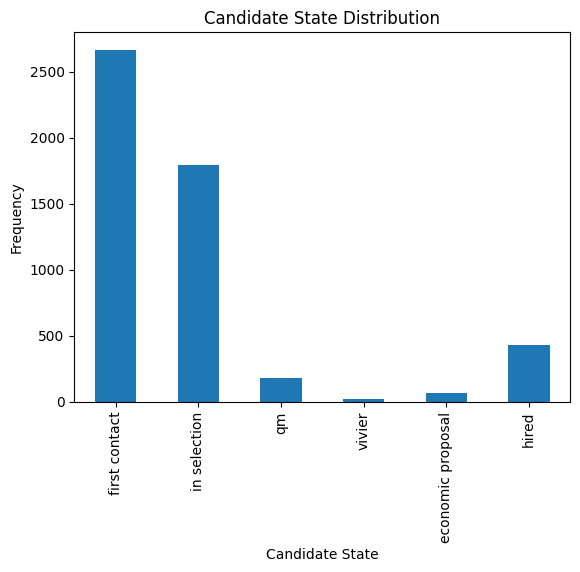

In [366]:
getHist(df, 'Candidate State', custom_order)

### **`Age Range`**



In [367]:
custom_order = ['< 20 years', '20 - 25 years', '26 - 30 years',
                '31 - 35 years', '36 - 40 years', '40 - 45 years', '> 45 years']
df['Age Range'] = pd.Categorical(df['Age Range'], categories=custom_order, ordered=True)

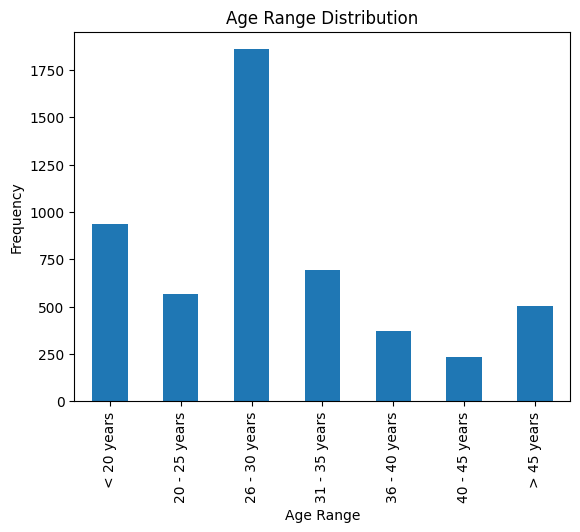

In [368]:
getHist(df, 'Age Range', custom_order)

### **`Sex`**
The dataset is unbalanced with respect to Sex feature, with 80% male candidates and 20% female candidates.

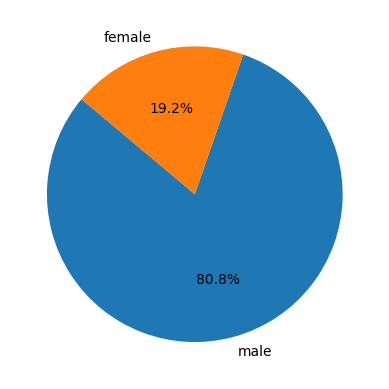

In [369]:
getPie(df, 'Sex')

### **`Protected Category`**
The dataset is highly unbalanced with respect to this feature, with only 0.9% candidates from protected categories.




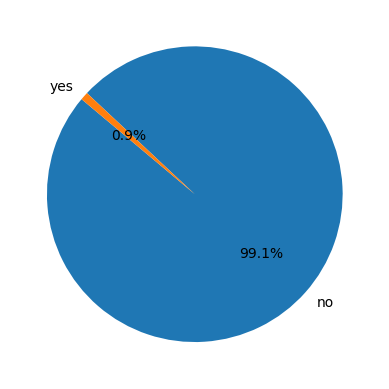

In [370]:
getPie(df, 'Protected Category')

### **`Tag`**
This feature is highly irregular and will need processing in order to be useful. Some mapping could be applied to clean the data:

In [371]:
print(df['Tag'].unique())

['not specified' 'project management' 'angular, javascript.' ...
 'data analyst, embedded software engineer'
 'cad, fem, reqview, system, system engineer' 'office, excel, ms project']


In [375]:
all_keywords = df.groupby('Id')['Tag'].first().str.split(', ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'not specified'].index, inplace=True)
keyword_df['Keyword'] = keyword_df['Keyword'].str.upper()
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
8        MATLAB    534
10          C++    303
28            C    289
22   SOLIDWORKS    286
93     SIMULINK    285
142      PYTHON    272
13         JAVA    171
15        EXCEL    170
16       OFFICE    143
23      AUTOCAD    121

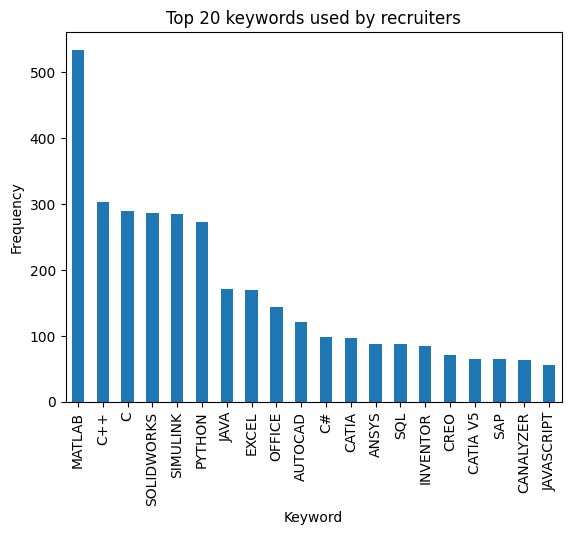

In [376]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title('Top 20 keywords used by recruiters')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


### **`Study Area`**

In [377]:
print(f"There are {len(df['Study Area'].unique())} different <Study Area> values:\n {df['Study Area'].unique()} \n")

There are 47 different <Study Area> values:
 ['industrial engineering' 'electrical engineering'
 'civil/civil and environmental engineering' 'communication sciences'
 'management engineering' 'scientific maturity' 'electronic engineering'
 'informatics' 'mechanical engineering' 'biomedical engineering'
 'information engineering' 'computer engineering'
 'automation/mechatronics engineering' 'chemical engineering' 'other'
 'psychology' 'accounting' 'automotive engineering'
 'aeronautical/aerospace/astronautics engineering'
 'other scientific subjects'
 'engineering for the environment and the territory'
 'chemist - pharmaceutical' 'economic - statistics' 'legal'
 'safety engineering' 'energy and nuclear engineering'
 'other humanities subjects' 'telecommunications engineering'
 'political-social' 'surveyor' 'medical' 'naval engineering'
 'humanistic high school diploma' 'architecture' 'literary'
 'materials science and engineering' 'linguistics' 'statistics'
 'mathematics' 'geo-biologica

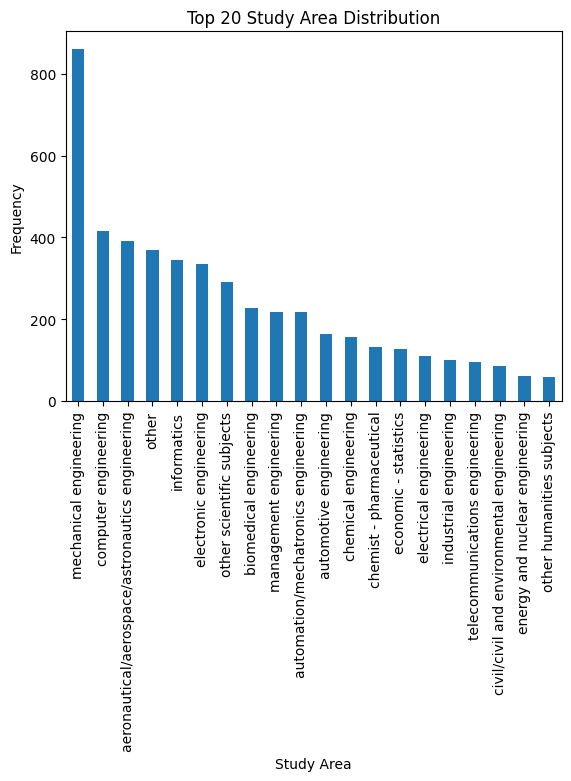

In [378]:
getHist(df, 'Study Area', None)

### **`Study Title`**

In [379]:
print(f"There are {len(df['Study Title'].unique())} different <Study Title> values:\n {df['Study Title'].unique()} \n")

There are 7 different <Study Title> values:
 ['five-year degree', 'three-year degree', 'high school graduation', 'master's degree', 'doctorate', 'middle school diploma', 'professional qualification']
Categories (7, object): ['middle school diploma' < 'high school graduation' < 'professional qualification' <
                         'three-year degree' < 'five-year degree' < 'master's degree' < 'doctorate'] 



In [380]:
custom_order = ['middle school diploma', 'high school graduation', 'professional qualification',
                'three-year degree', 'five-year degree', 'master\'s degree', 'doctorate']
df['Study Title'] = pd.Categorical(df['Study Title'], categories=costum_order, ordered=True)

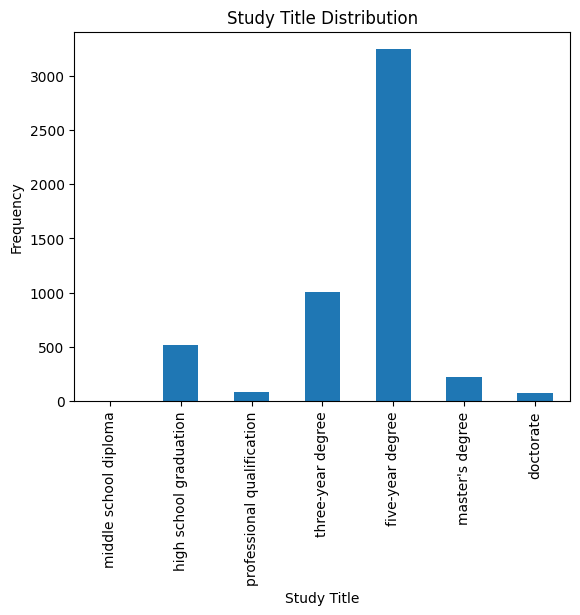

In [381]:
getHist(df, 'Study Title', custom_order)

### **`Years Experience`**

In [382]:
print(f"There are {len(df['Years Experience'].unique())} different <Years Experience> categories:\n {df['Years Experience'].unique()} \n")

There are 7 different <Years Experience> categories:
 ['[1-3]', '[+10]', '[0-1]', '[0]', '[5-7]', '[3-5]', '[7-10]']
Categories (8, object): ['not specified' < '[0]' < '[0-1]' < '[1-3]' < '[3-5]' < '[5-7]' < '[7-10]' < '[+10]'] 



In [383]:
custom_order = ['[0]', '[0-1]', '[1-3]', '[3-5]', '[5-7]', '[7-10]', '[+10]']
df['Years Experience'] = pd.Categorical(df['Years Experience'], categories=custom_order, ordered=True)

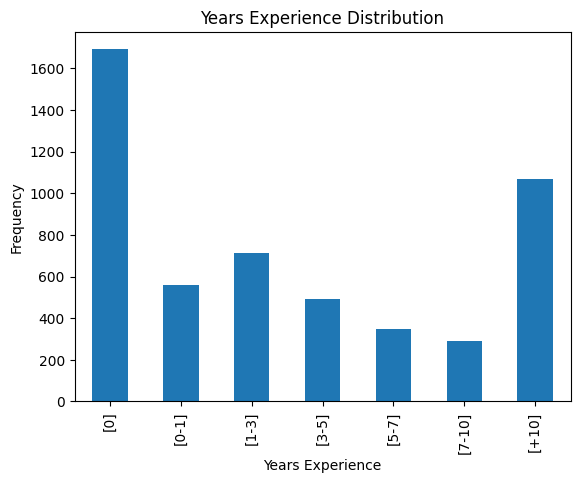

In [384]:
getHist(df, 'Years Experience', custom_order)

### **`Sector`**
This feature doesn't seem relevant as its most frequent value is "*Others*".

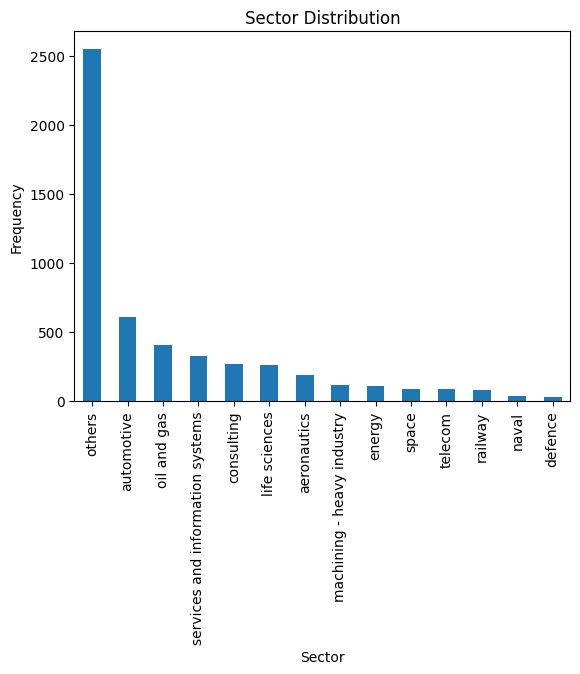

In [385]:
getHist(df, 'Sector', None)

### **`Last Role`**

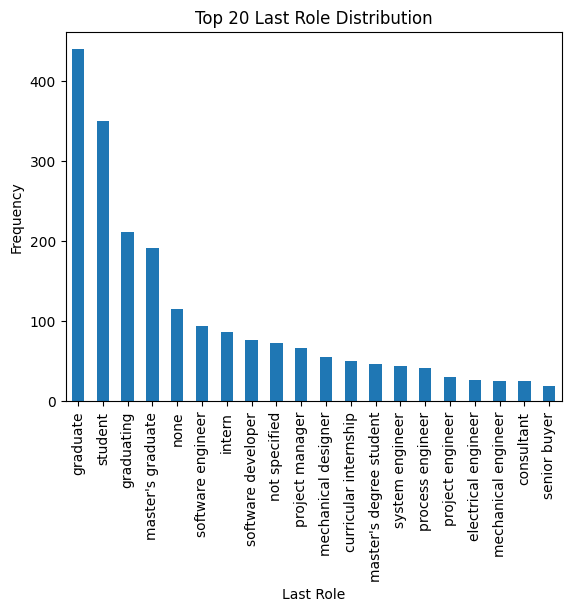

In [386]:
getHist(df, 'Last Role', None)

In [ ]:
all_keywords = df.groupby('Id')['Last Role'].first().str.split(' ').explode()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'Not Specified'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'And'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'None'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '&'].index, inplace=True)
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
7     Engineer   1134
25    Graduate    635
31     Student    437
16     Manager    387
47          Sw    316
20   Developer    274
24    Master'S    247
15     Project    244
93  Graduating    223
14    Designer    196

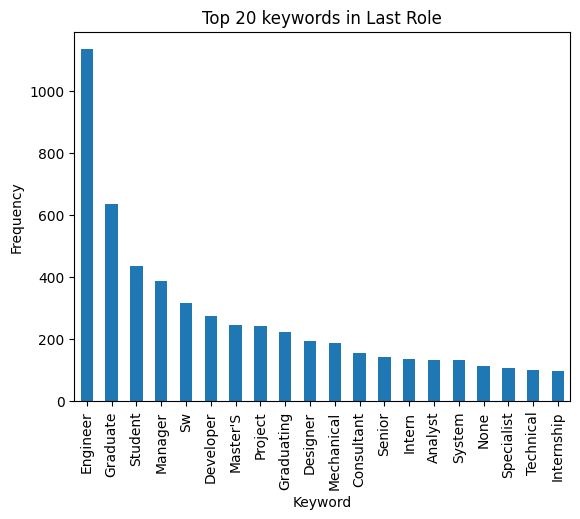

In [ ]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title('Top 20 keywords in Last Role')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


### **`Year Of Insertion`**

In [387]:
custom_order = np.sort(df['Year Of Insertion'].unique().astype(str).tolist())

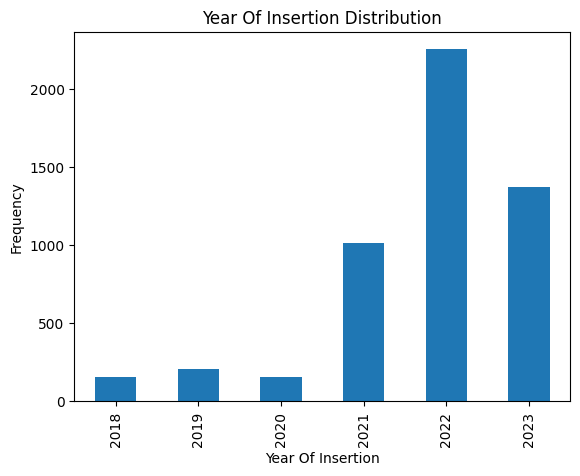

In [388]:
getHist(df, 'Year Of Insertion', custom_order)

### **`Year Of Recruitment`**

In [389]:
custom_order = np.sort(df['Year Of Recruitment'].unique().tolist())

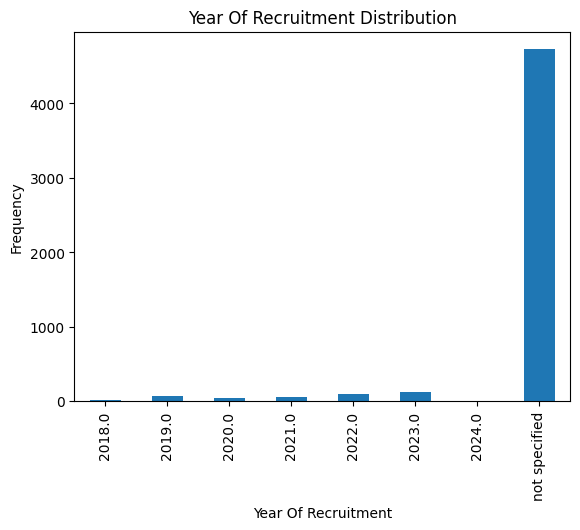

In [390]:
getHist(df, 'Year Of Recruitment', custom_order)

### **`Event_type__val`**
A possible chronological order could be useful to maintain only the last event.

In [391]:
print(f"There are {len(df['Event_Type__Val'].unique())} different values for <Event_Type__Val:\n {df['Event_Type__Val'].unique()}")

There are 14 different values for <Event_Type__Val:
 ['not specified' 'research association' 'bm interview' 'cv request'
 'contact note' 'hr interview' 'commercial note' 'candidate notification'
 'sending sc to customer' 'technical interview' 'economic proposal'
 'inadequate cv' 'qualification meeting' 'notify candidate']


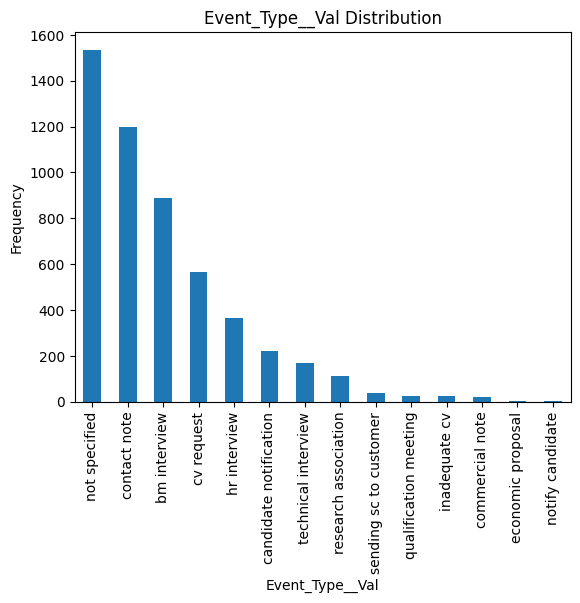

In [392]:
getHist(df, 'Event_Type__Val', None)

### **`Event Feedback`**
There are many possible `Event_Feedback` in the dataset:

  * OK
    * other candidate: the candidate was not hired because the company chose someone else (**but were them suitable?**)
    * live: **??**
    * waiting for departure: **??**
    * hired: the candidate is suitable for the position
  * KO
    * manager: **??**
    * technical skills: the candidate's skills are not suitable for the position
    * mobility: the candidate is not suitable for mobility reason, not related to skills **?**
    * retired: the candidate retired **?? (Should we keep them??)**
    * seniority: the candidate is too old | not enough senior **??**
    * ral: candidate expected higher ral **??**
    * opportunity closed: the candidate was not hired because the opportunity closed, *maybe similar to `OK (other candidate)`* (**but were them suitable?**)
    * proposed renunciation: the candidate has renounced the proposal, **but was suitable**
    * language skills: the candidate was not hired due to lack of language skills
    * lost availability: **of who?? the candidate?**

It might be useful to distinguish between positive and negative outcomes. For example, KO (ral) does not mean that the candidate was unsuitable, however we do not have the position that was offered to them. **Should we discard these cases??**

In [393]:
print(f"Possible values for <Event_Feedback>: \n {df['Event_Feedback'].unique()}")

Possible values for <Event_Feedback>: 
 ['not specified' 'ok' 'ko (manager)' 'ok (other candidate)' 'ok (live)'
 'ko (technical skills)' 'ko (mobility)' 'ko (retired)' 'ko (seniority)'
 'ko (ral)' 'ko (opportunity closed)' 'ko (proposed renunciation)'
 'ok (waiting for departure)' 'ko (language skills)'
 'ko (lost availability)' 'ok (hired)']


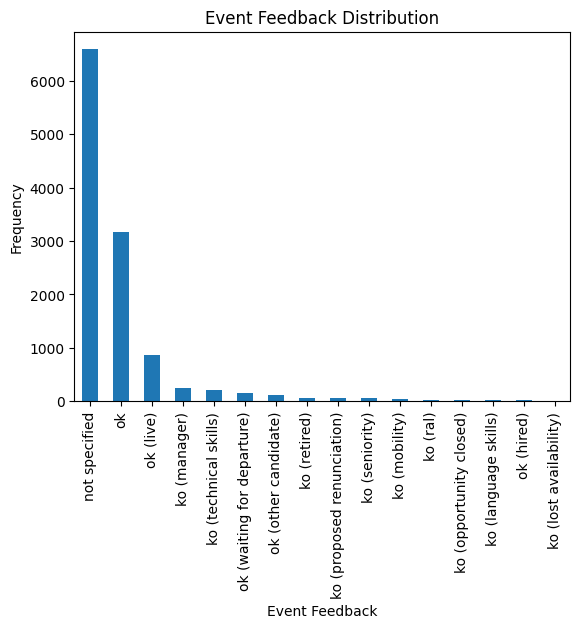

In [394]:
filtered_count = df['Event_Feedback'].value_counts()

filtered_count.plot(kind='bar', legend=False)
plt.title('Event Feedback Distribution')
plt.ylabel('Frequency')
plt.xlabel('Event Feedback')
plt.show()

####Not Specified
Half of the candidates have no `Event_Feedback` specified.

In [395]:
notSpec_counts = df.groupby('Id')['Event_Feedback'].apply(lambda x: (x == 'not specified').all())

tot_notSpec_counts = notSpec_counts.sum()
print(f"{tot_notSpec_counts/len(candidates)*100:.2f}% of candidates have 'Not Specified' in every row as <Event_Feedback>")

52.59% of candidates have 'Not Specified' in every row as <Event_Feedback>


Looking at the histogram below we can see that the majority of candidates who have no `Event_Feedback` specified (in every row) have 'First Contact' as `Candidate State`. This means that they are in the first stages of the recruiting process and so they don't have any feedback.

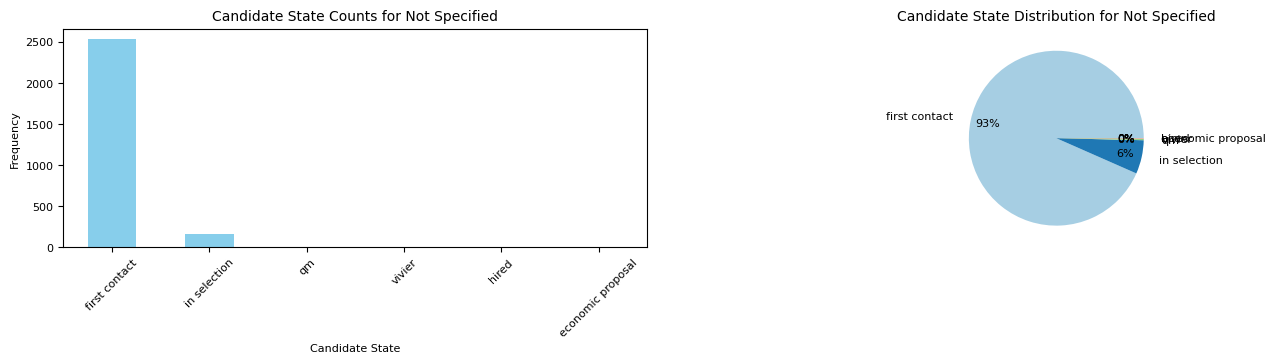

In [396]:
notSpec_candidates = notSpec_counts[notSpec_counts].index
filtered_df = df[df['Id'].isin(notSpec_candidates)]

plot_graphs(filtered_df, 'Candidate State', 'Not Specified')

Looking at the distribution of `Event_Type__Val` among candidates for whom `Event_Feedback` is not specified, we can see that most of them have 'Contact note' and 'CV request'.

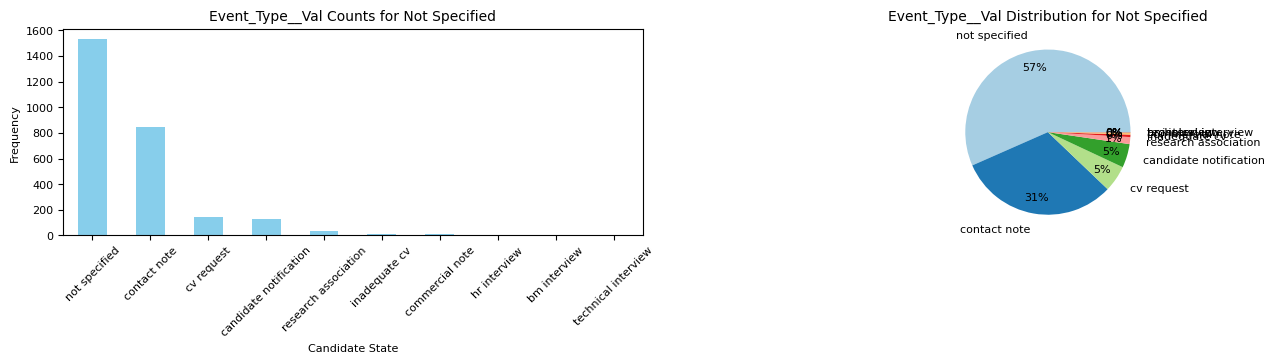

In [397]:
plot_graphs(filtered_df, 'Event_Type__Val', 'Not Specified')

#### OK

1748 (33.90%) candidates have 'ok' as Event_Feedback 
(in at least one row)


76.54% of candidates (1338) with 'ok' (in at least one row) have no Job Position specified
 




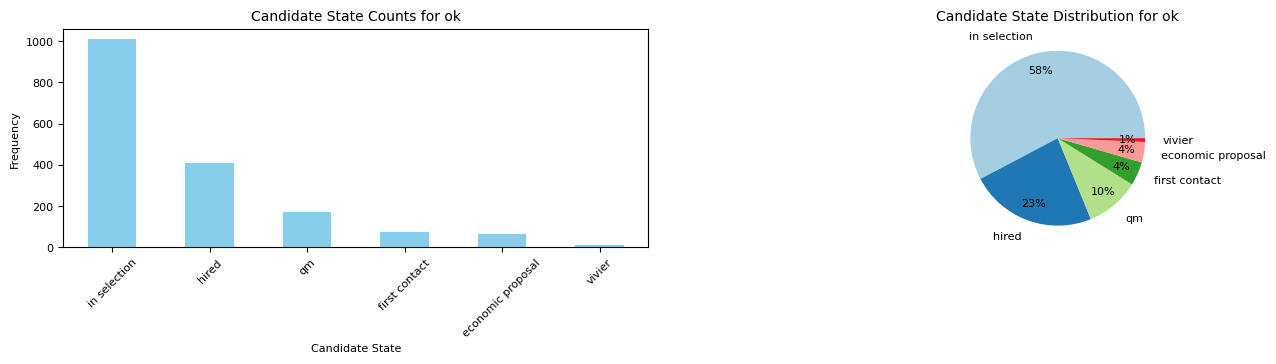

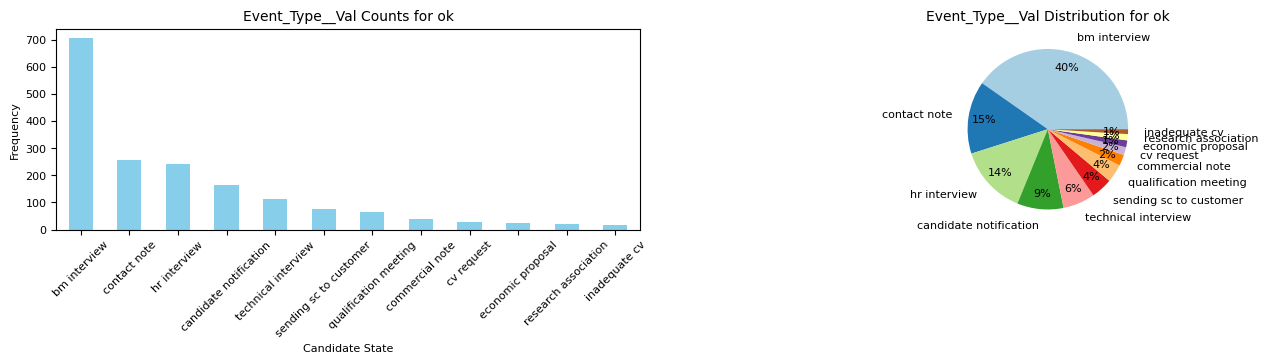

In [399]:
getStats('Event_Feedback', 'ok')

#### OK (other candidate)
Only 2% of candidates have 'Ok (other candidate)' as `Event_Feedback`. 80% of those have 'In Selection' as `Candidate State`. This means that during the *Selection* phase another candidate was selected to continue the hiring process **??**.
90% have no *Job Position* specified.

115 (2.23%) candidates have 'ok (other candidate)' as Event_Feedback 
(in at least one row)


90.43% of candidates (104) with 'ok (other candidate)' (in at least one row) have no Job Position specified
 




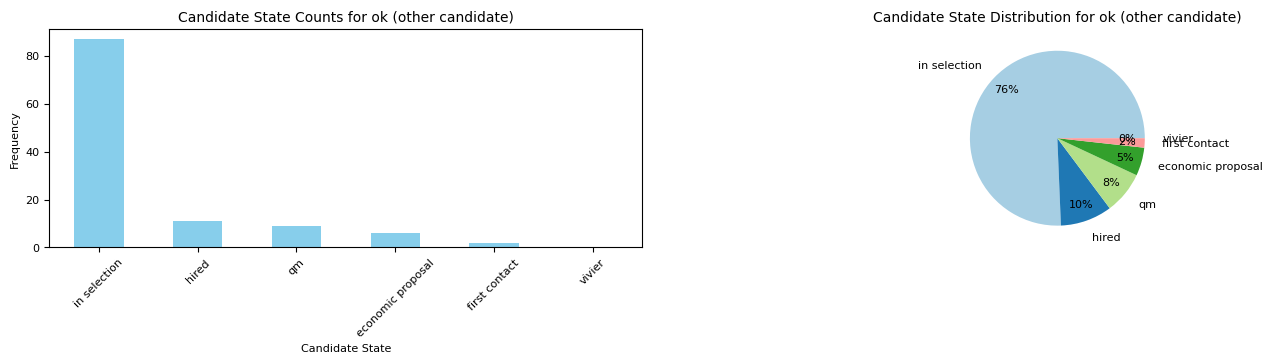

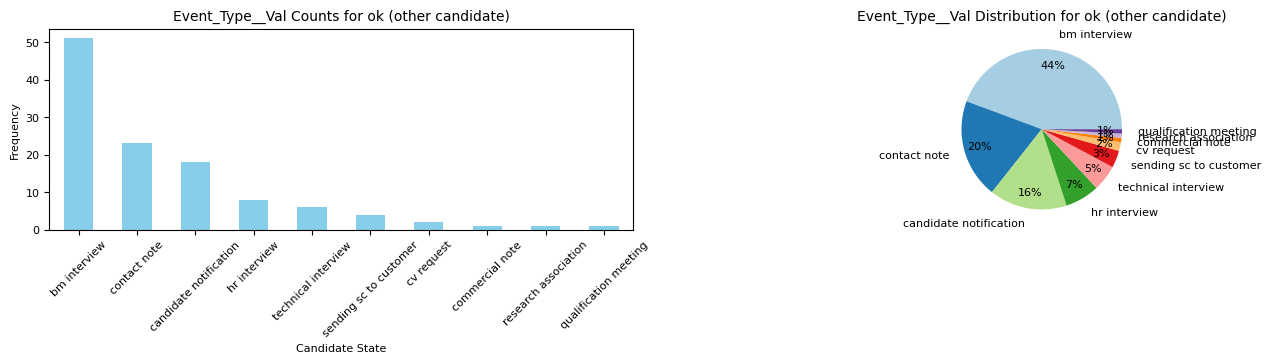

In [400]:
getStats('Event_Feedback', 'ok (other candidate)')

#### OK (live)
15% of candidates have 'Ok (live)' as `Event_Feedback`. 90% of those have no *Job Position* specified and **80**% are still 'in selection'.

728 (14.12%) candidates have 'ok (live)' as Event_Feedback 
(in at least one row)


89.84% of candidates (654) with 'ok (live)' (in at least one row) have no Job Position specified
 




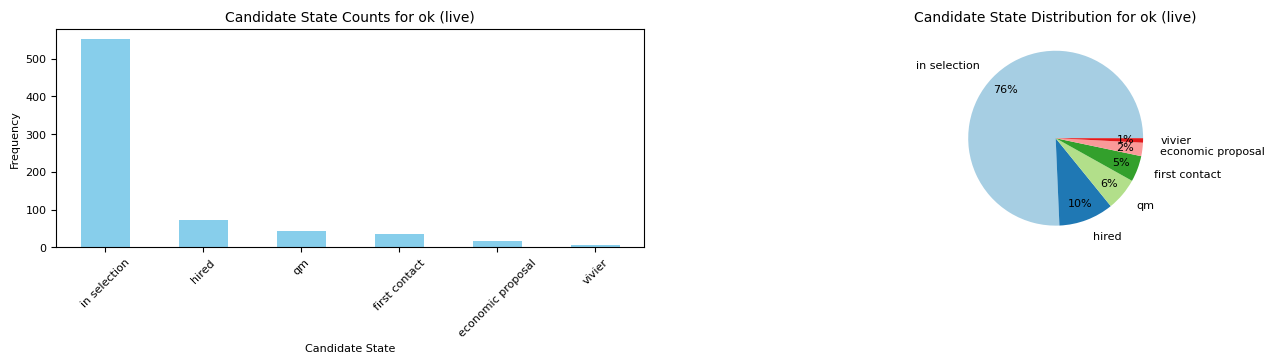

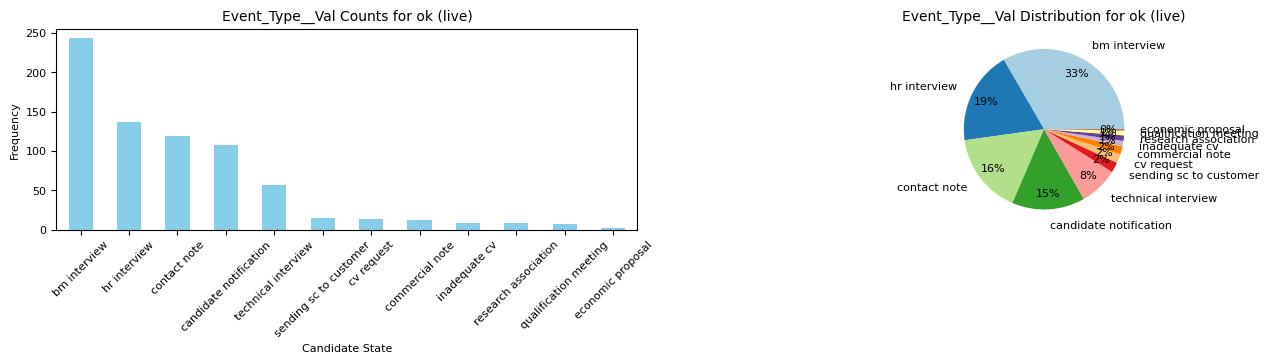

In [401]:
getStats('Event_Feedback', 'ok (live)')

#### OK (waiting for departure)
This seems to mean that the candidate is suitable for the position and they are waiting to be hired. However 15% (19) of candidates that have this feedback have no job position specified.

123 (2.39%) candidates have 'ok (waiting for departure)' as Event_Feedback 
(in at least one row)


15.45% of candidates (19) with 'ok (waiting for departure)' (in at least one row) have no Job Position specified
 




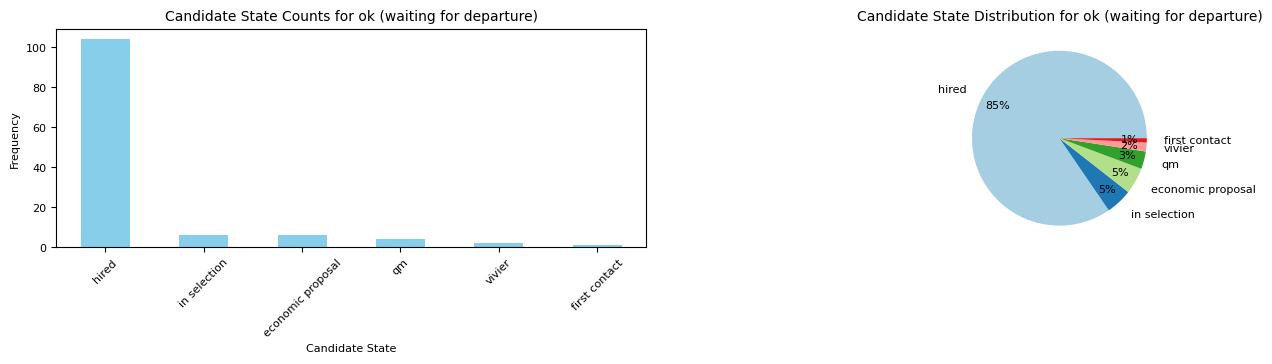

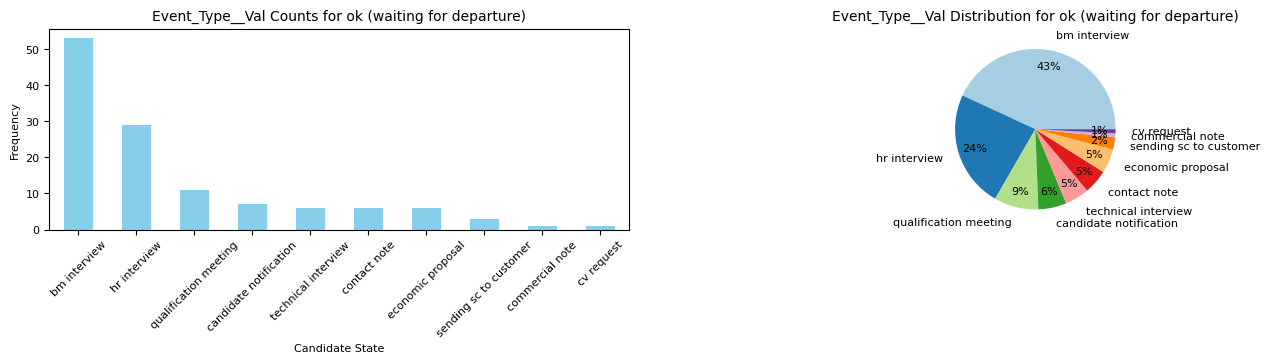

In [402]:
getStats('Event_Feedback', 'ok (waiting for departure)')

#### OK (hired)


16 (0.31%) candidates have 'ok (hired)' as Event_Feedback 
(in at least one row)


6.25% of candidates (1) with 'ok (hired)' (in at least one row) have no Job Position specified
 




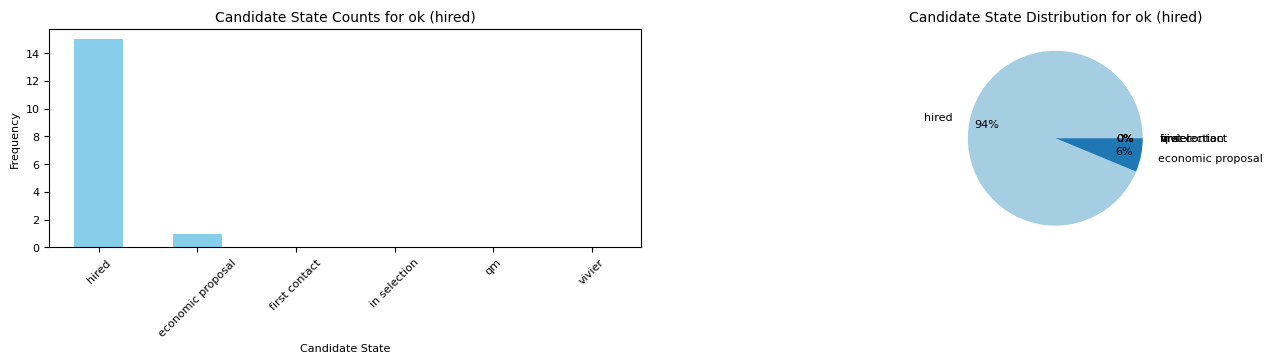

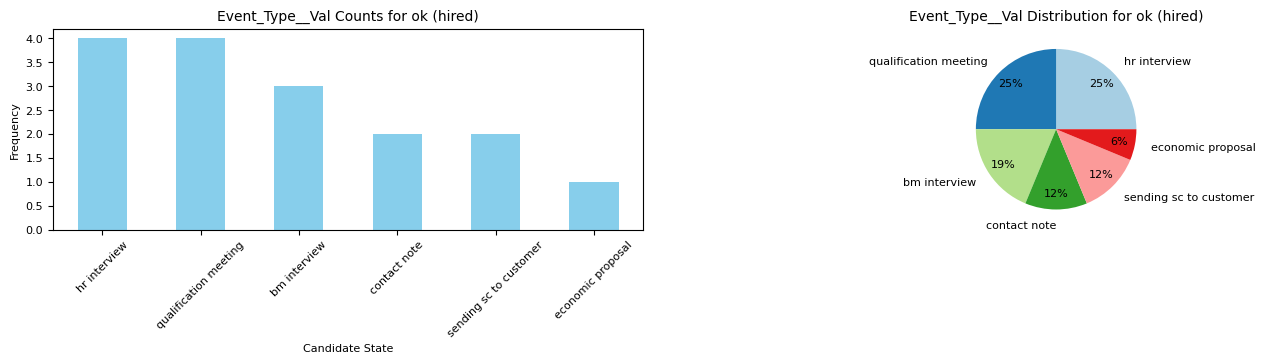

In [403]:
getStats('Event_Feedback', 'ok (hired)')

#### KO (manager)

224 (4.34%) candidates have 'ko (manager)' as Event_Feedback 
(in at least one row)


97.77% of candidates (219) with 'ko (manager)' (in at least one row) have no Job Position specified
 




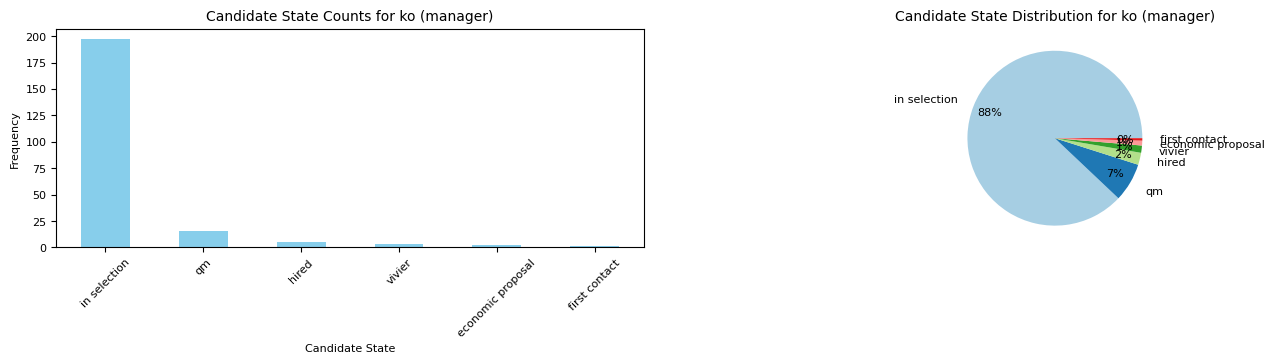

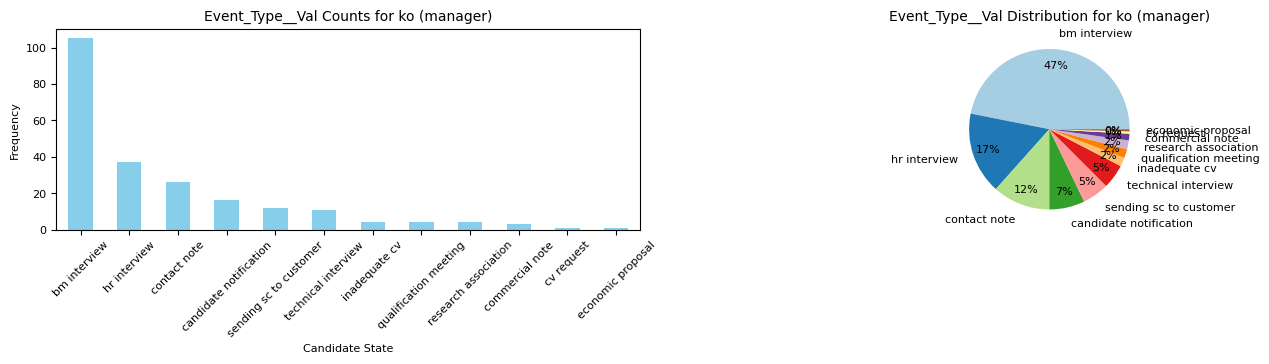

In [404]:
getStats('Event_Feedback', 'ko (manager)')

#### KO (technical skills)

186 (3.61%) candidates have 'ko (technical skills)' as Event_Feedback 
(in at least one row)


93.55% of candidates (174) with 'ko (technical skills)' (in at least one row) have no Job Position specified
 




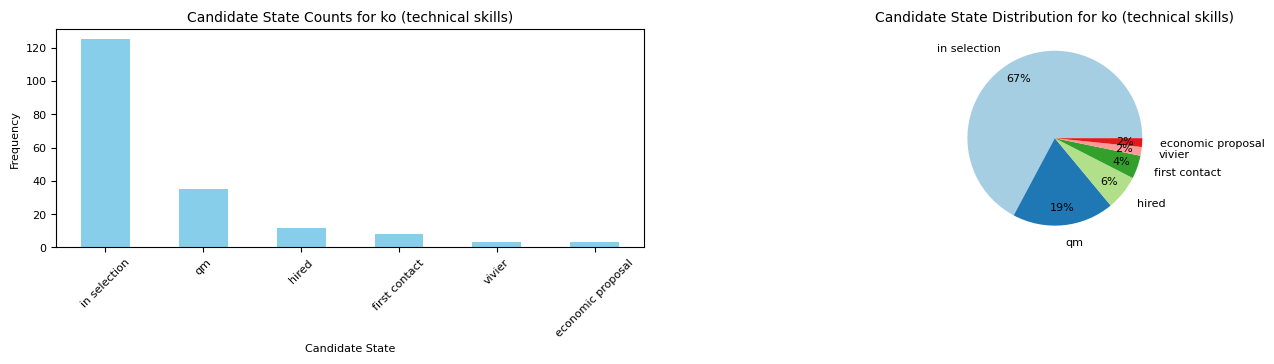

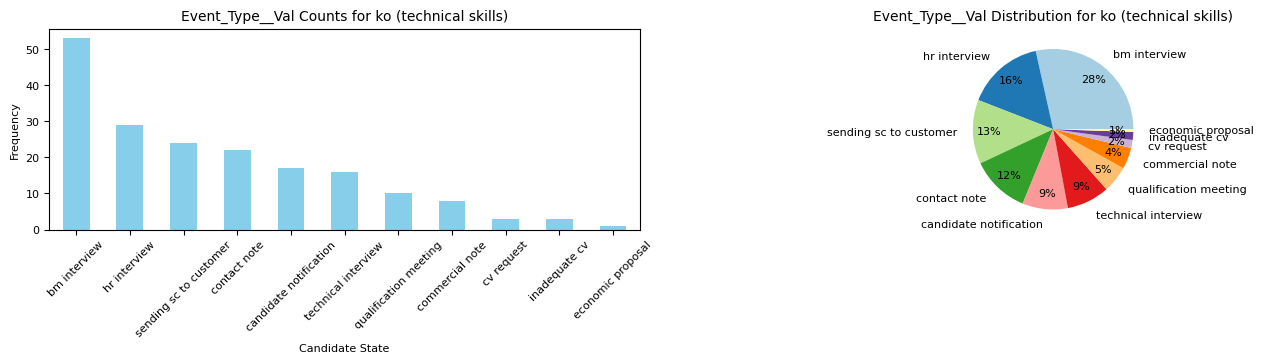

In [405]:
getStats('Event_Feedback', 'ko (technical skills)')

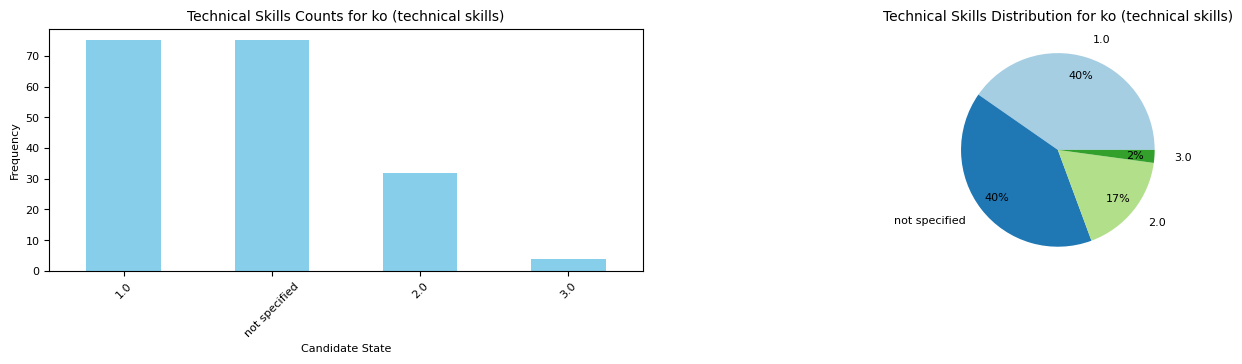

In [406]:
plot_graphs(df[df['Event_Feedback'] == 'ko (technical skills)'],'Technical Skills','ko (technical skills)')

#### KO (mobility)

48 (0.93%) candidates have 'ko (mobility)' as Event_Feedback 
(in at least one row)


95.83% of candidates (46) with 'ko (mobility)' (in at least one row) have no Job Position specified
 




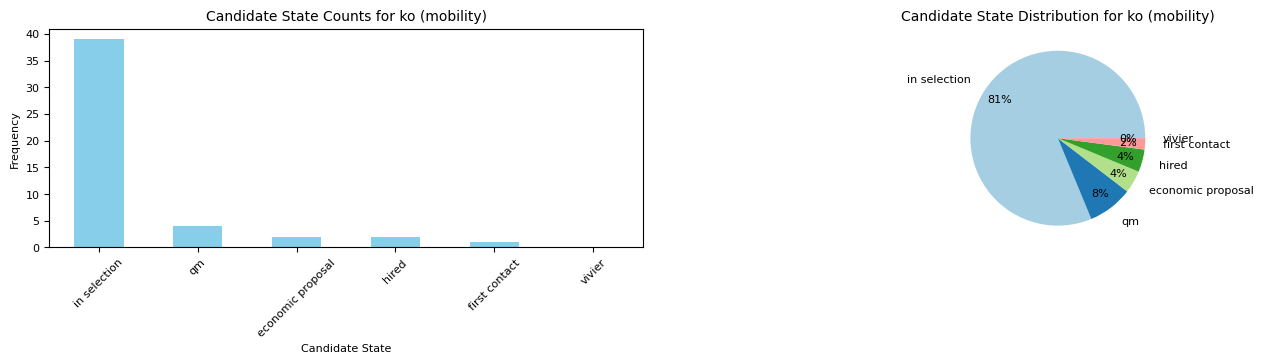

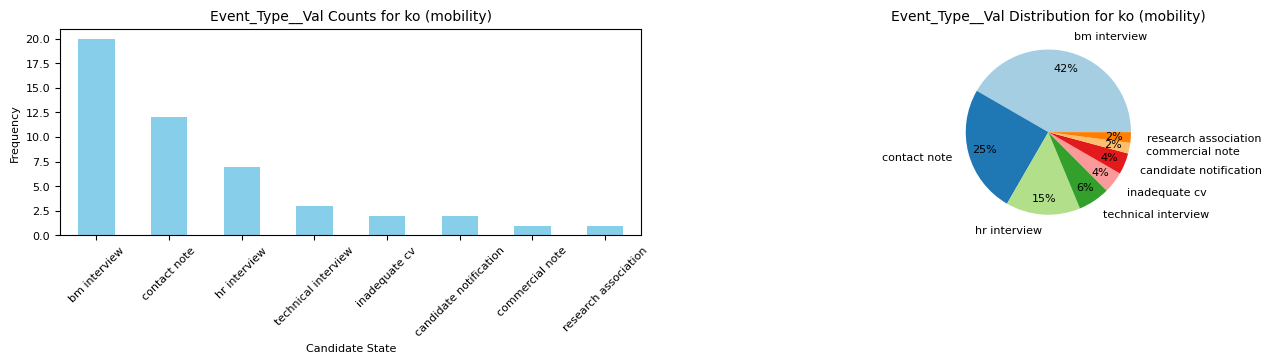

In [407]:
getStats('Event_Feedback', 'ko (mobility)')

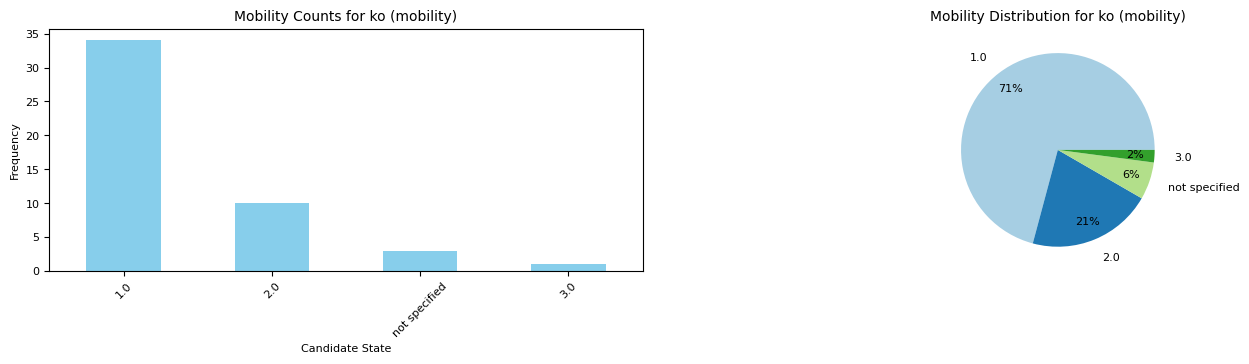

In [408]:
plot_graphs(df[df['Event_Feedback'] == 'ko (mobility)'],'Mobility','ko (mobility)')

#### KO (retired)

60 (1.16%) candidates have 'ko (retired)' as Event_Feedback 
(in at least one row)


100.00% of candidates (60) with 'ko (retired)' (in at least one row) have no Job Position specified
 




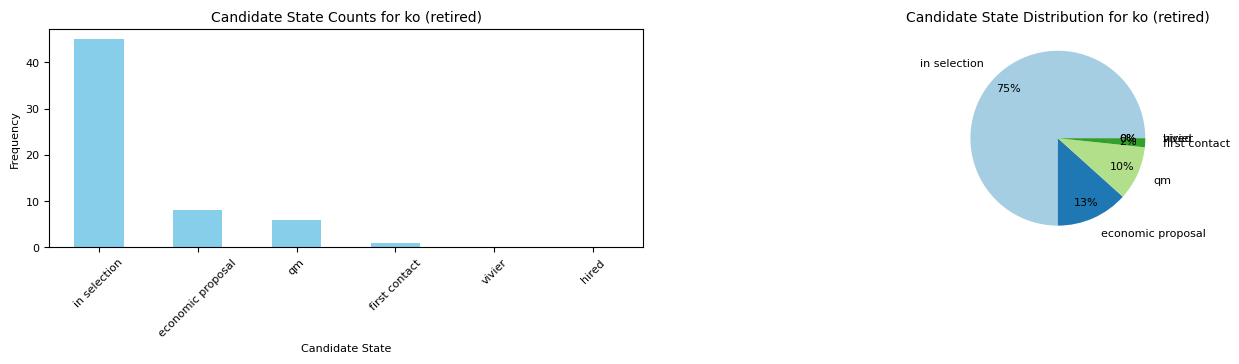

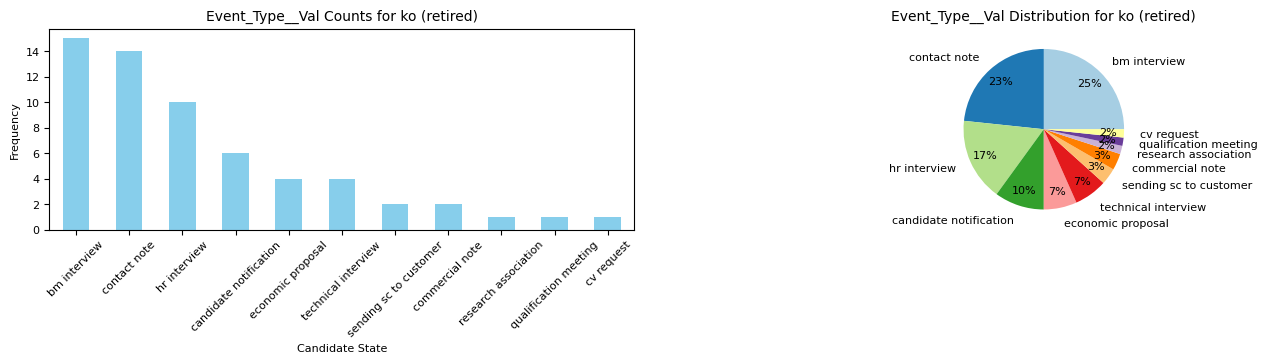

In [410]:
getStats('Event_Feedback', 'ko (retired)')

40% of candidates with 'KO (retired)' `Event_Feedback` have [26-30] years **??**
However less than 2% of the candidates has received this feedback.

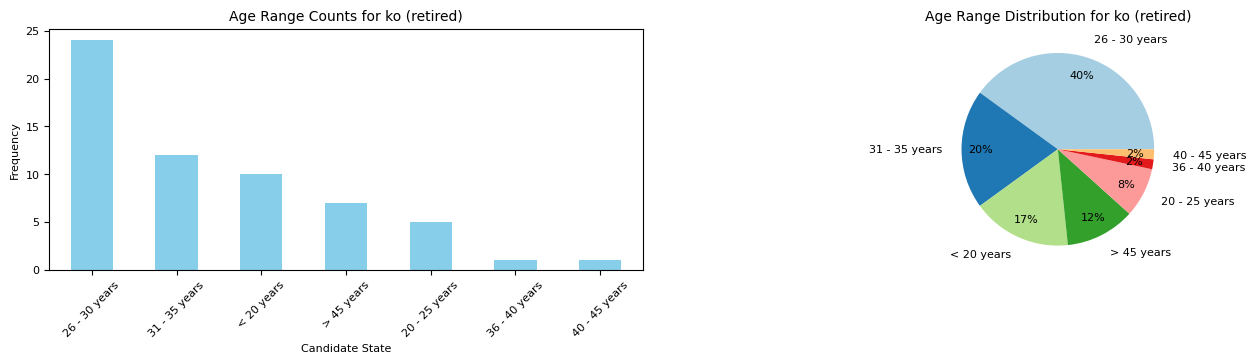

In [411]:
plot_graphs(df[df['Event_Feedback'] == 'ko (retired)'],'Age Range','ko (retired)')

#### KO (seniority)

49 (0.95%) candidates have 'ko (seniority)' as Event_Feedback 
(in at least one row)


95.92% of candidates (47) with 'ko (seniority)' (in at least one row) have no Job Position specified
 




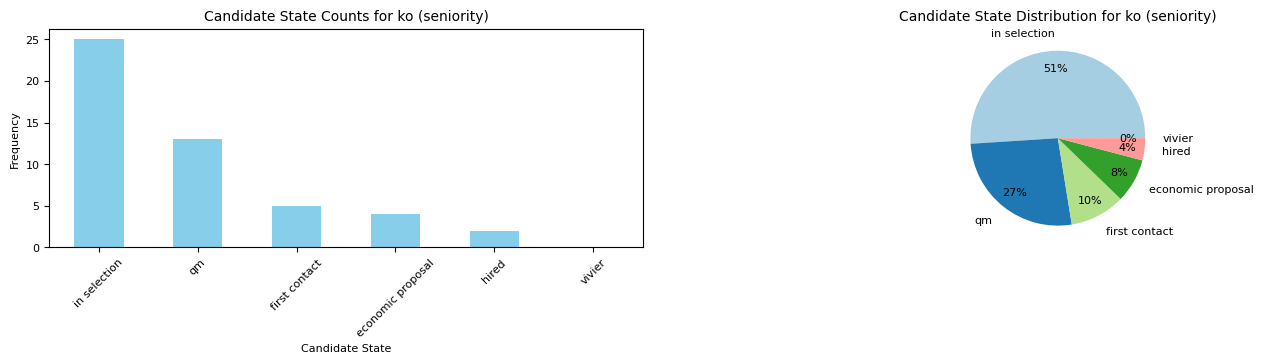

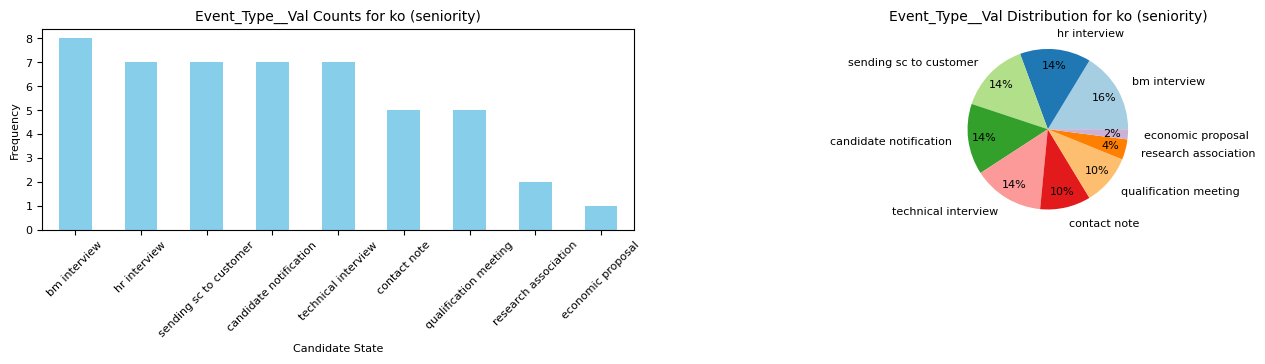

In [412]:
getStats('Event_Feedback', 'ko (seniority)')

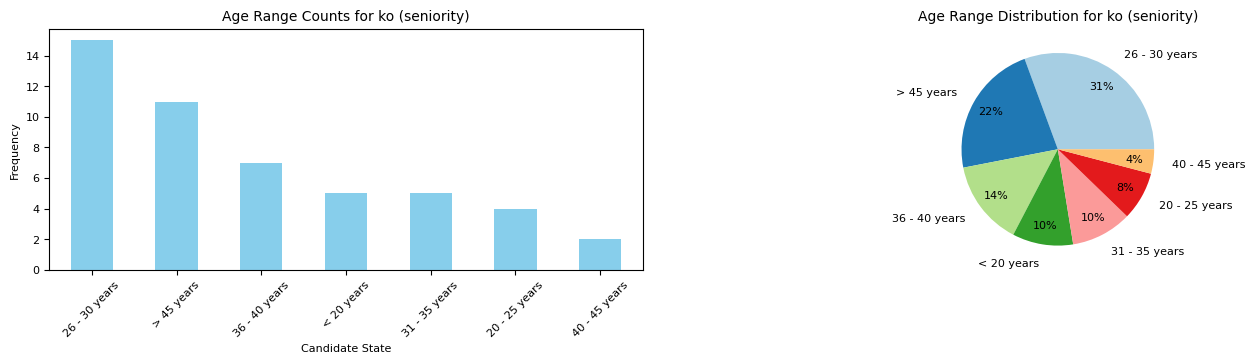

In [413]:
plot_graphs(df[df['Event_Feedback'] == 'ko (seniority)'],'Age Range','ko (seniority)')

#### KO (ral)
This feedback could mean that the ral was not enough for the candidates. However almost every one of them have no *Job position* specified.

29 (0.56%) candidates have 'ko (ral)' as Event_Feedback 
(in at least one row)


96.55% of candidates (28) with 'ko (ral)' (in at least one row) have no Job Position specified
 




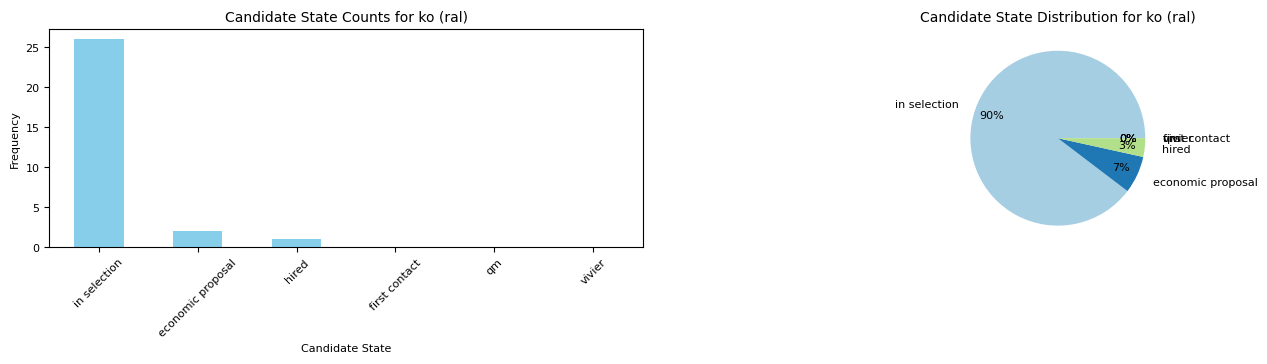

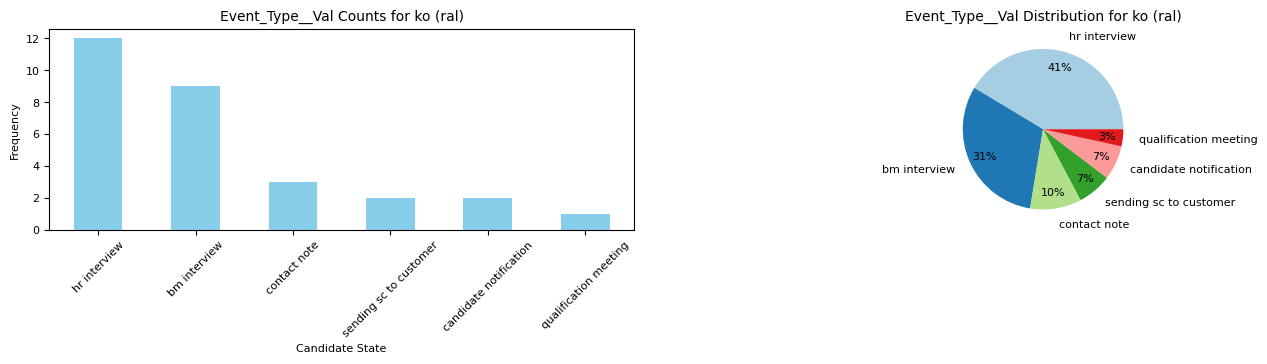

In [414]:
getStats('Event_Feedback', 'ko (ral)')

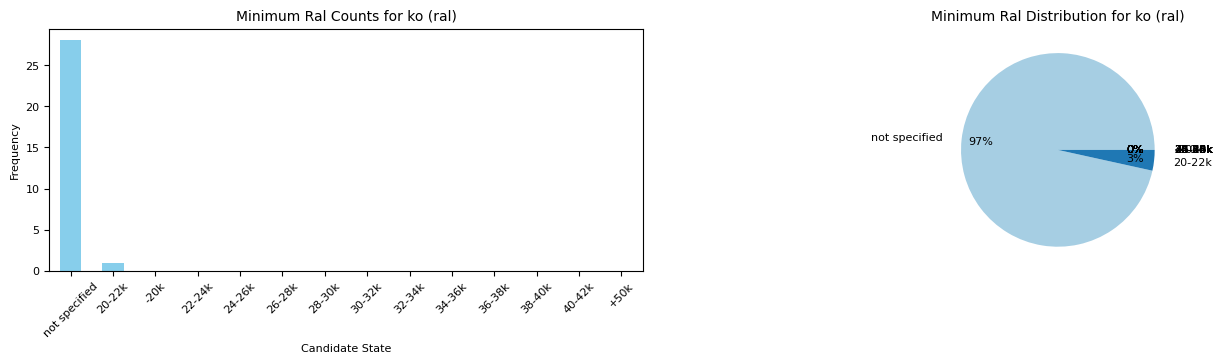

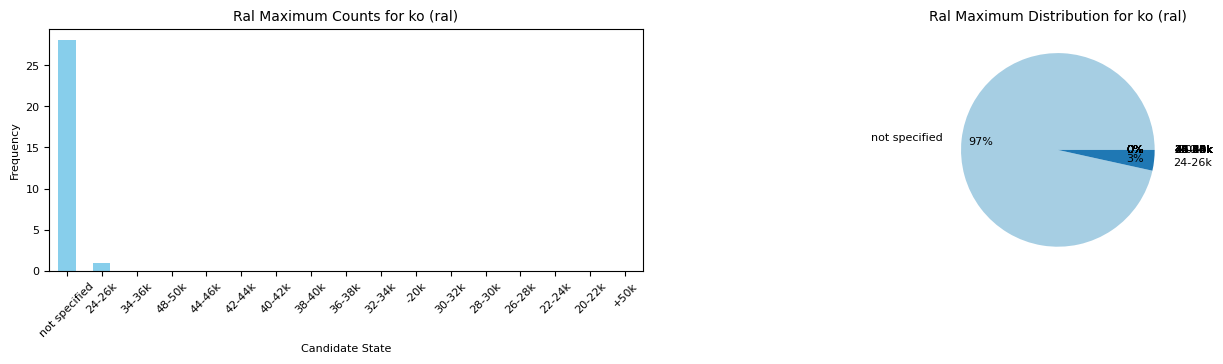

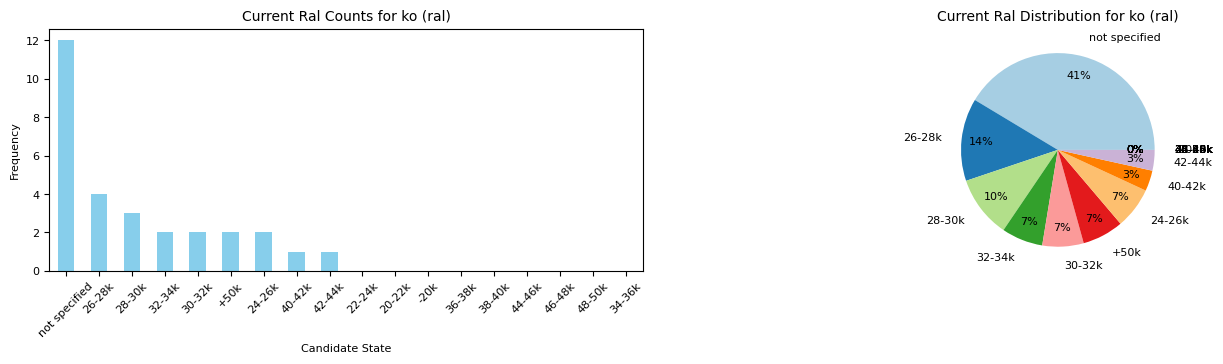

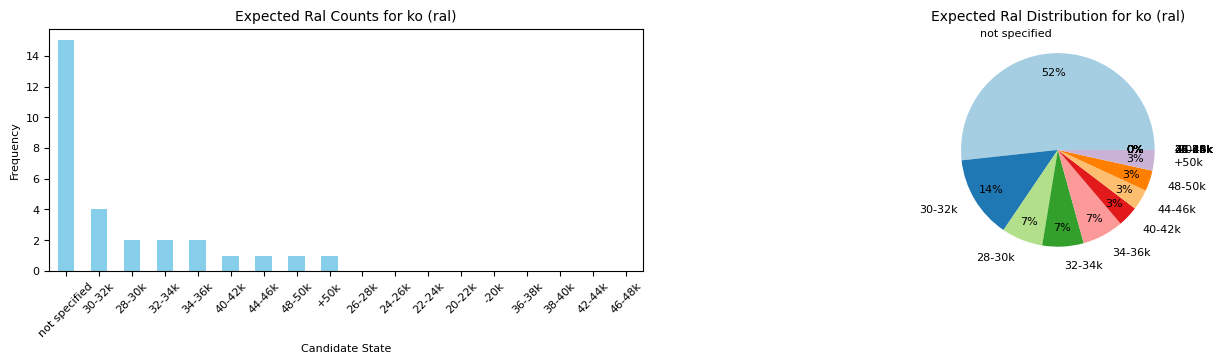

In [415]:
for col in df.columns:
  if 'Ral' in col:
    plot_graphs(df[df['Event_Feedback'] == 'ko (ral)'],col,'ko (ral)')

#### KO (Closed Opportunity)
This does not necessarily mean that the candidate was not suitable for the position, however, since most of these candidates do not have a specified position, they will be considered ineligible.

29 (0.56%) candidates have 'ko (opportunity closed)' as Event_Feedback 
(in at least one row)


93.10% of candidates (27) with 'ko (opportunity closed)' (in at least one row) have no Job Position specified
 




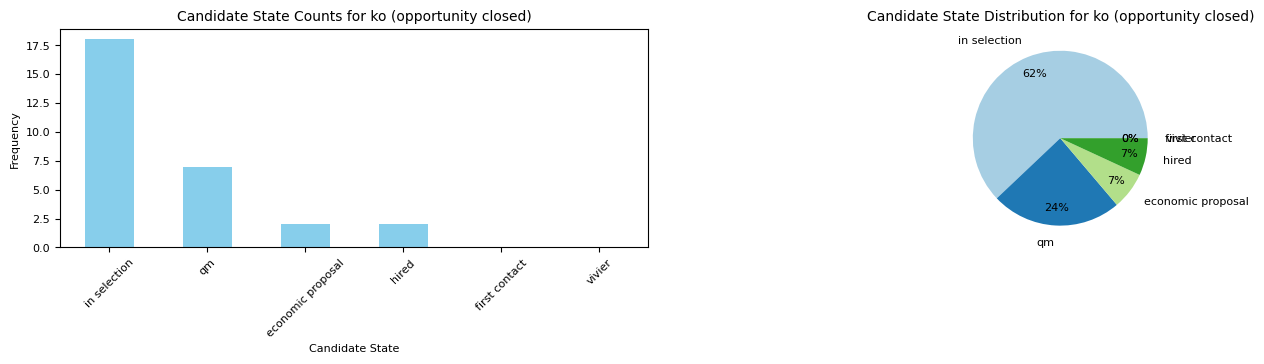

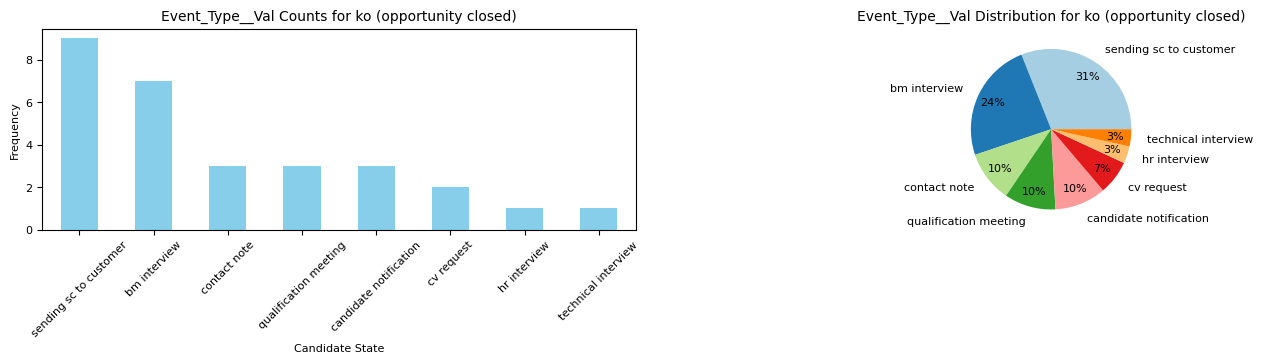

In [416]:
getStats('Event_Feedback', 'ko (opportunity closed)')

#### KO (proposed renunciation)

53 (1.03%) candidates have 'ko (proposed renunciation)' as Event_Feedback 
(in at least one row)


94.34% of candidates (50) with 'ko (proposed renunciation)' (in at least one row) have no Job Position specified
 




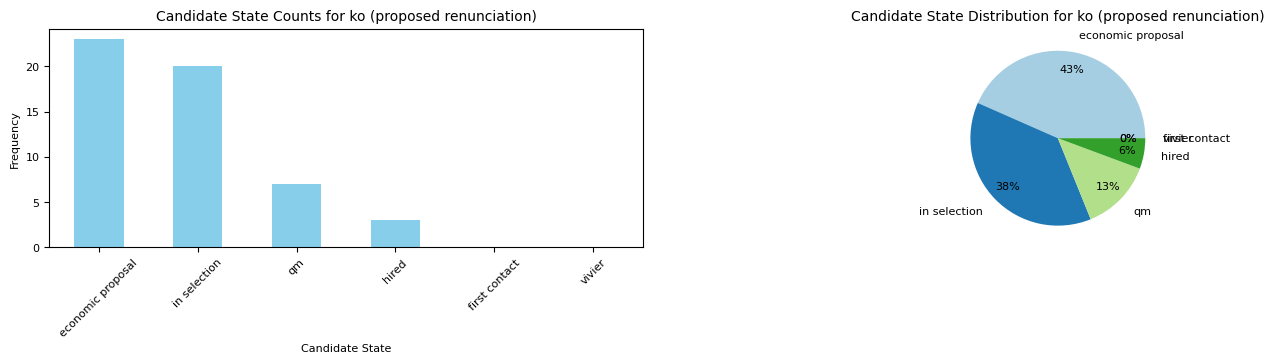

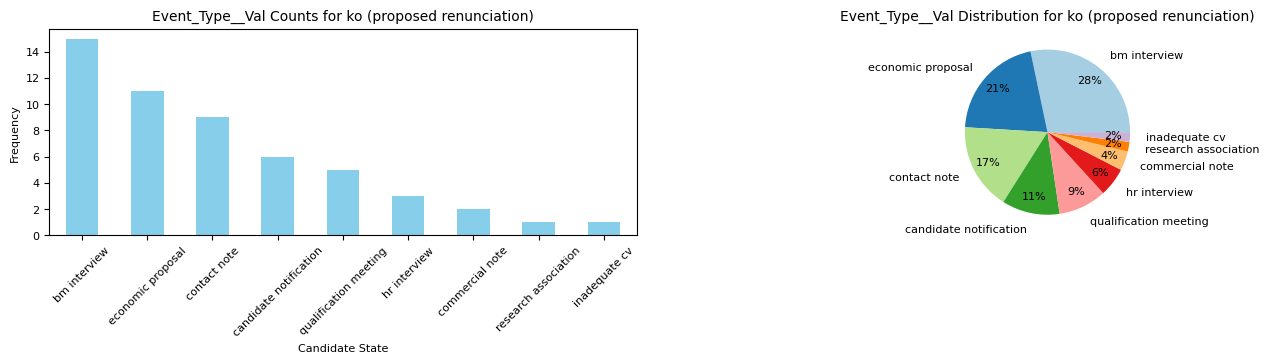

In [417]:
getStats('Event_Feedback', 'ko (proposed renunciation)')

#### KO (language skills)

18 (0.35%) candidates have 'ko (language skills)' as Event_Feedback 
(in at least one row)


100.00% of candidates (18) with 'ko (language skills)' (in at least one row) have no Job Position specified
 




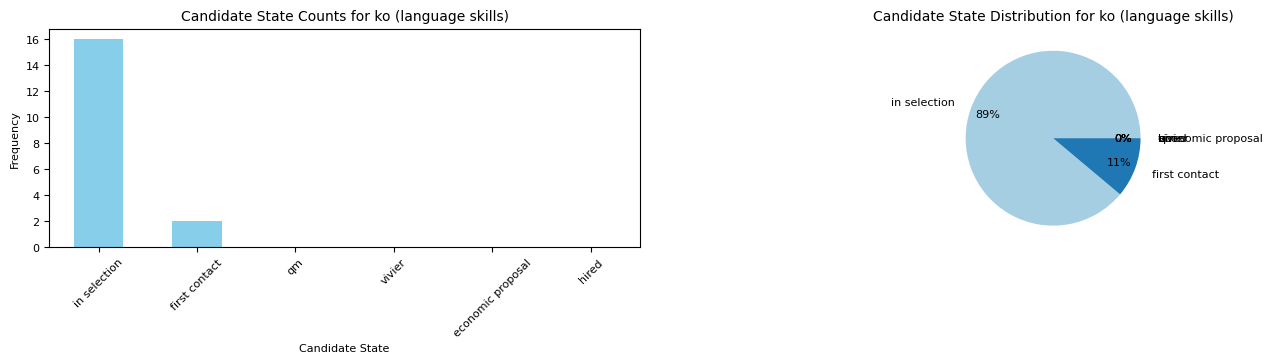

Exception ignored in: <function ZipFile.__del__ at 0x7e6f841828c0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1834, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1851, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


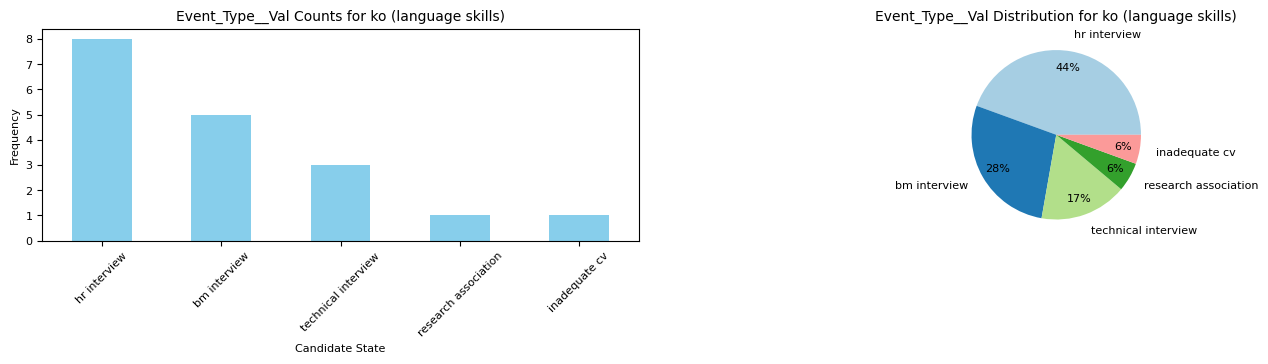

In [418]:
getStats('Event_Feedback', 'ko (language skills)')

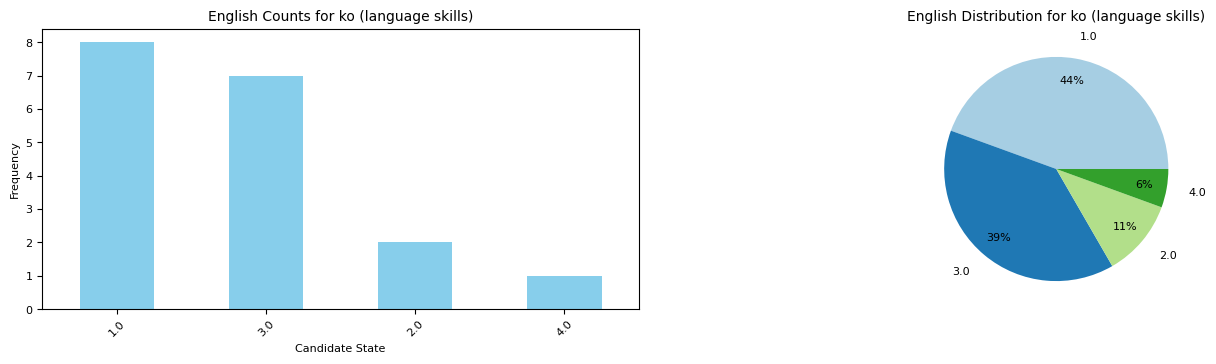

In [419]:
plot_graphs(df[df['Event_Feedback'] == 'ko (language skills)'],'English','ko (language skills)')

#### KO (lost availability)

13 (0.25%) candidates have 'ko (lost availability)' as Event_Feedback 
(in at least one row)


100.00% of candidates (13) with 'ko (lost availability)' (in at least one row) have no Job Position specified
 




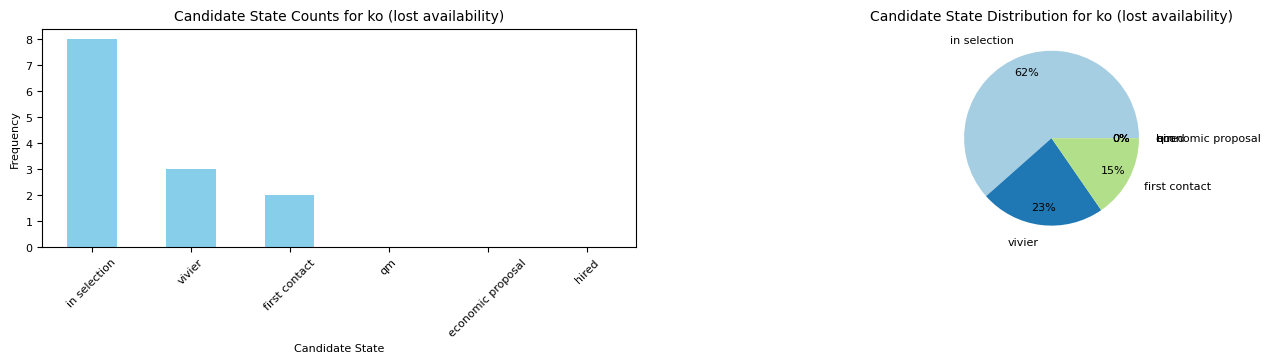

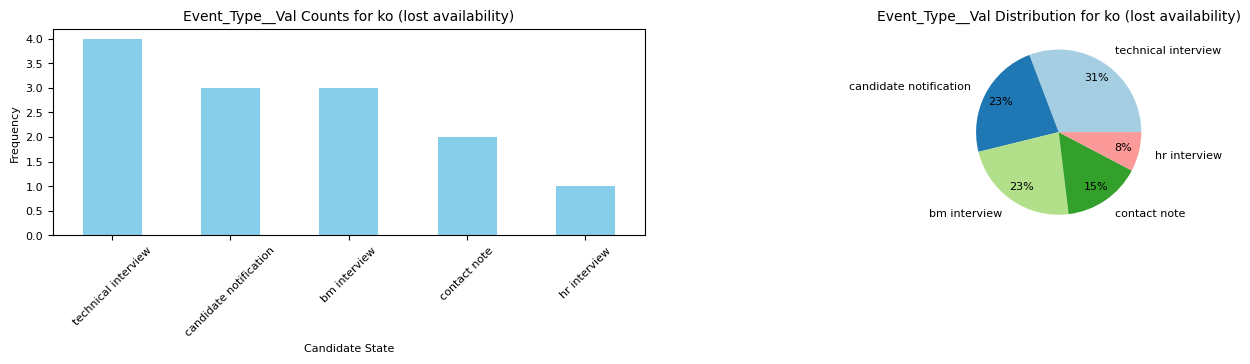

In [420]:
getStats('Event_Feedback', 'ko (lost availability)')

### **`Overall`**

In [421]:
custom_order = np.sort(df['Overall'].unique().tolist())

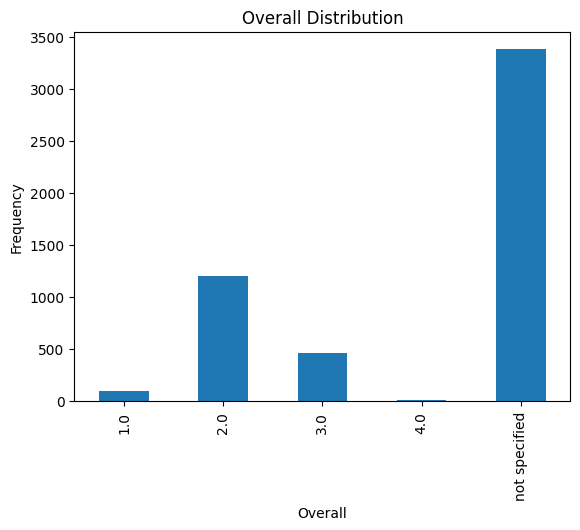

In [422]:
getHist(df, 'Overall', custom_order)

### **`Current Ral`**

In [425]:
col = 'Current Ral'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')
custom_order.remove('+50k')
custom_order.append('+50k')

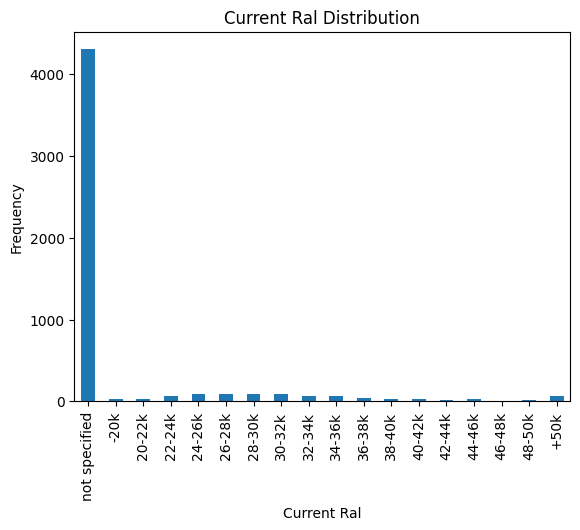

In [426]:
getHist(df, col, custom_order)

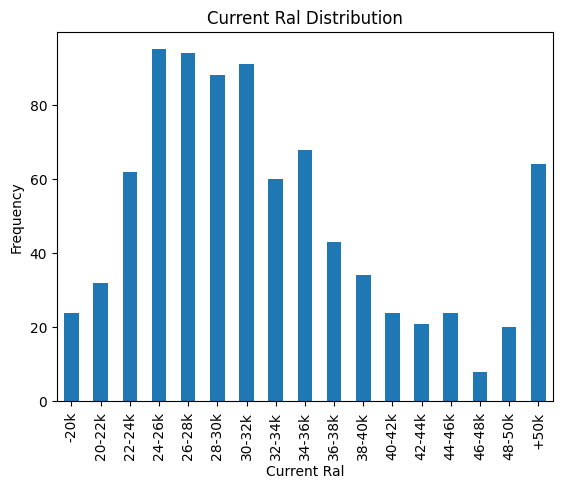

In [427]:
getHist(df[df['Current Ral'] != 'not specified'], col, custom_order)

### **`Expected Ral`**

In [428]:
col = 'Expected Ral'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')
custom_order.remove('+50k')
custom_order.append('+50k')

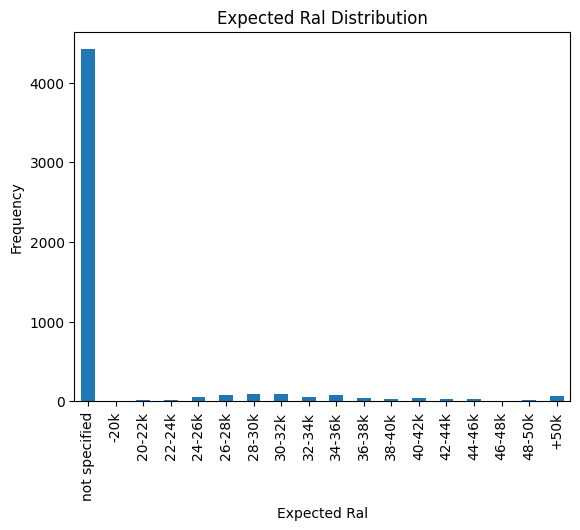

In [429]:
getHist(df, col, custom_order)

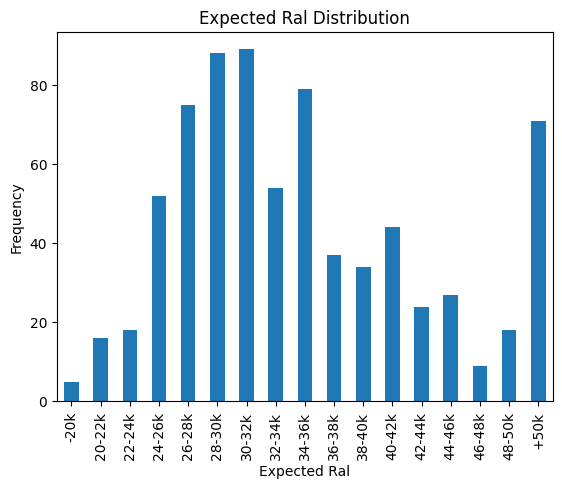

In [430]:
getHist(df[df['Expected Ral'] != 'not specified'], col, custom_order)

### **`Technical Skills`**

In [431]:
col = 'Technical Skills'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

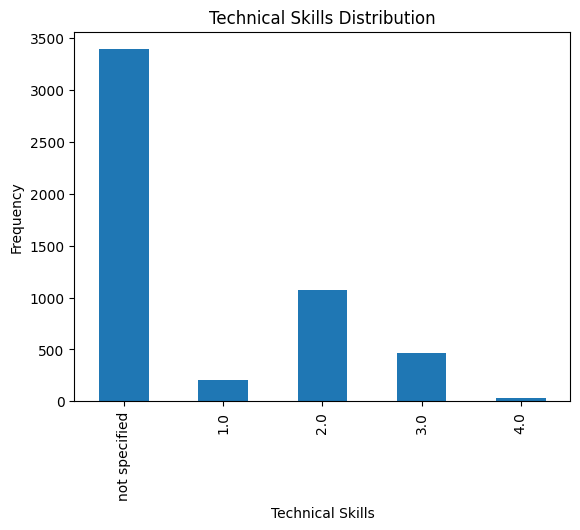

In [432]:
getHist(df, col, custom_order)

### **`Standing/Position`**

In [433]:
col = 'Standing/Position'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

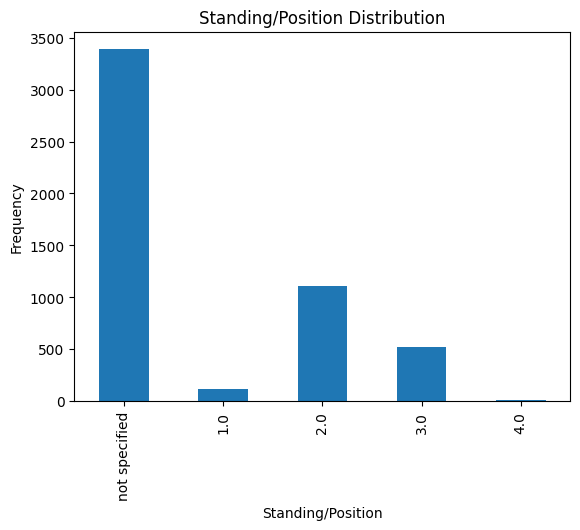

In [434]:
getHist(df, col, custom_order)

### **`Communication`**

In [437]:
col = 'Communication'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

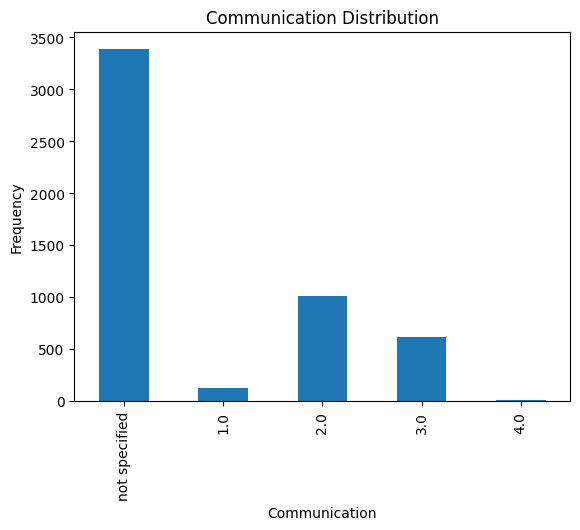

In [438]:
getHist(df, col, custom_order)

### **`Maturity`**



In [439]:
col = 'Maturity'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

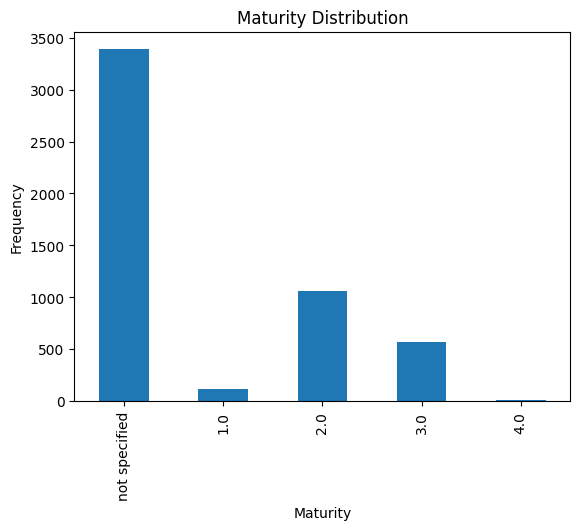

In [440]:
getHist(df, col, custom_order)

### **`Dynamism`**

In [441]:
col = 'Dynamism'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

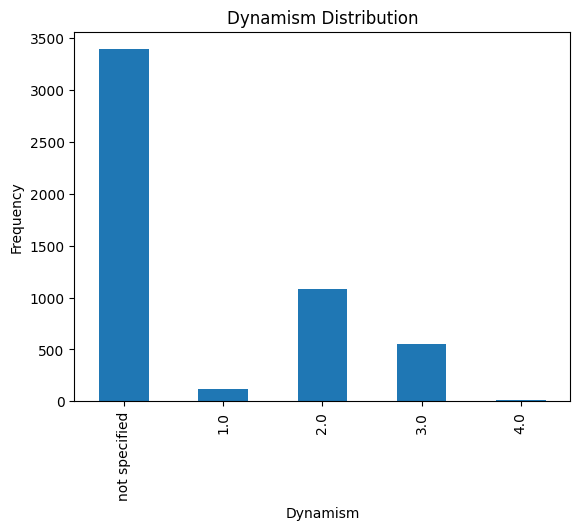

In [442]:
getHist(df, col, custom_order)

### **`Mobility`**

In [443]:
col = 'Mobility'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

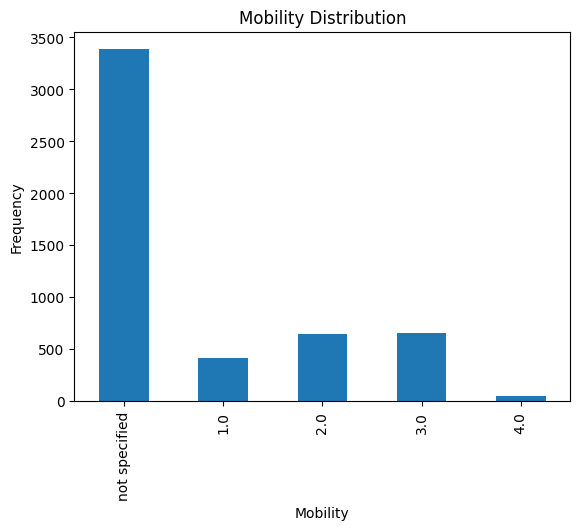

In [444]:
getHist(df, col, custom_order)

### **`English`**

In [445]:
col = 'English'
custom_order = np.sort(df[col].unique().tolist()).tolist()
custom_order.remove('not specified')
custom_order.insert(0, 'not specified')

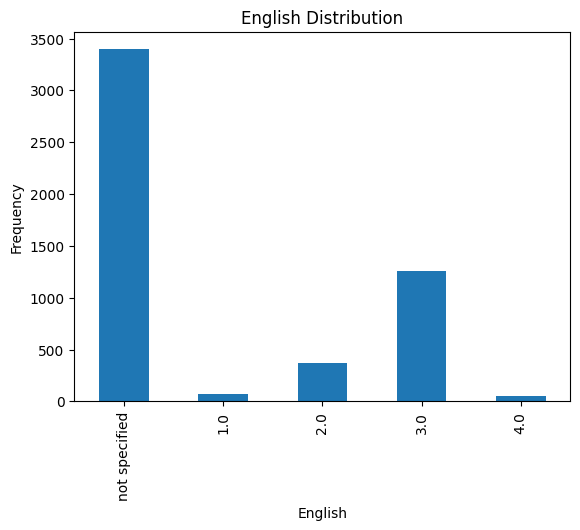

In [446]:
getHist(df, col, custom_order)

### **`European Residence`**

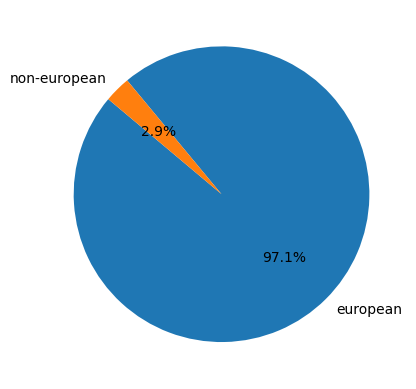

In [447]:
getPie(df, 'European Residence')

### **`Residence Country`**

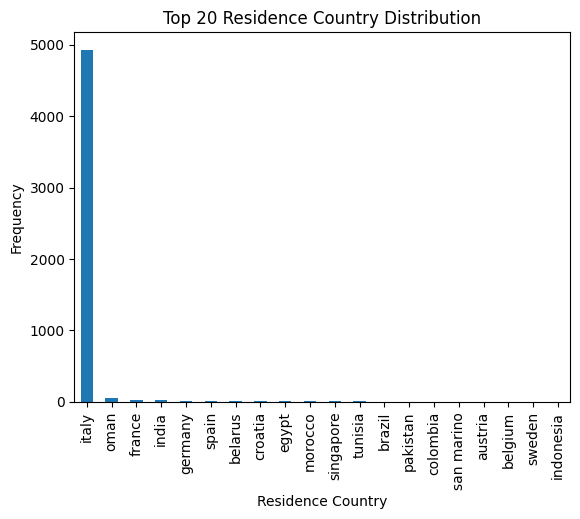

In [448]:
getHist(df, 'Residence Country', None)

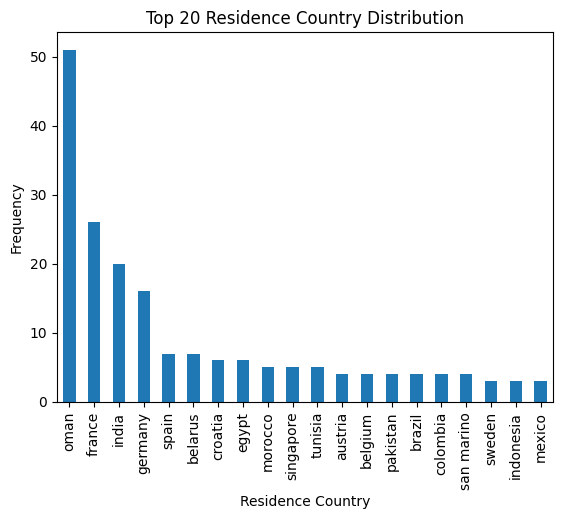

In [449]:
getHist(df[df['Residence Country'] != 'italy'], 'Residence Country', None)

### **`Residence Italian Region`**

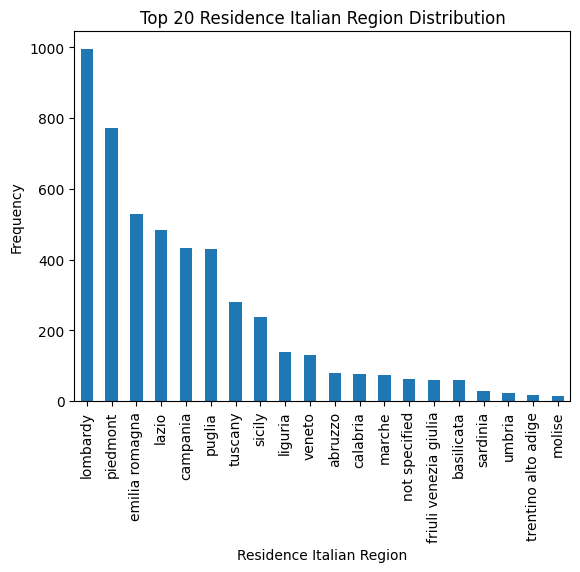

In [450]:
getHist(df[df['Residence Italian Region'] != 'not in italy'], 'Residence Italian Region', None)

## Data Visualization
### **Sex and Candidate State**

<ipython-input-451-f848c2304fb6>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='Sex', columns='Candidate State', aggfunc='size', fill_value=0)


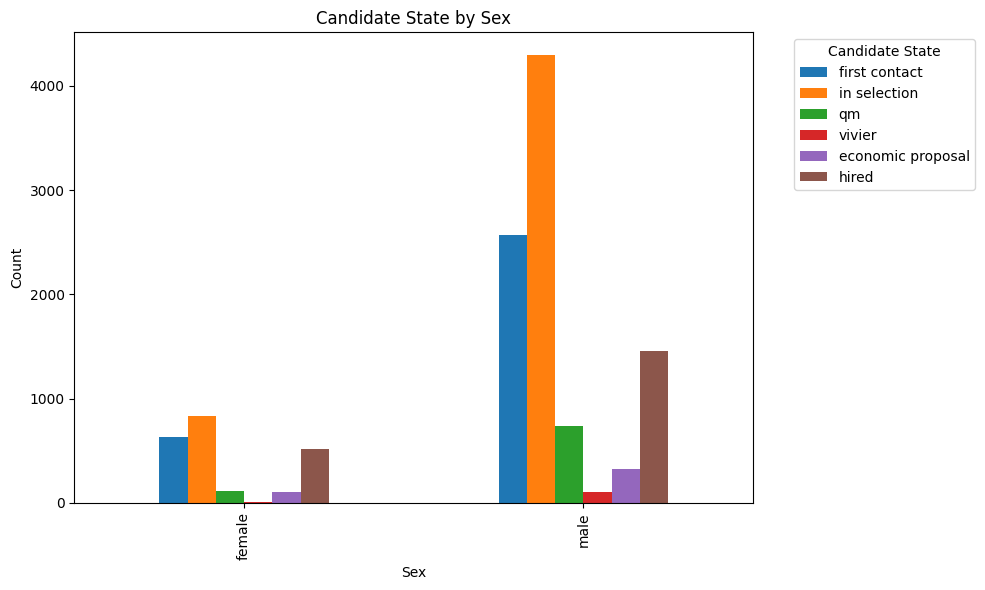

In [451]:
pivot = df.pivot_table(index='Sex', columns='Candidate State', aggfunc='size', fill_value=0)

pivot.plot(kind='bar', figsize=(10, 6))
plt.title('Candidate State by Sex')
plt.ylabel('Count')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


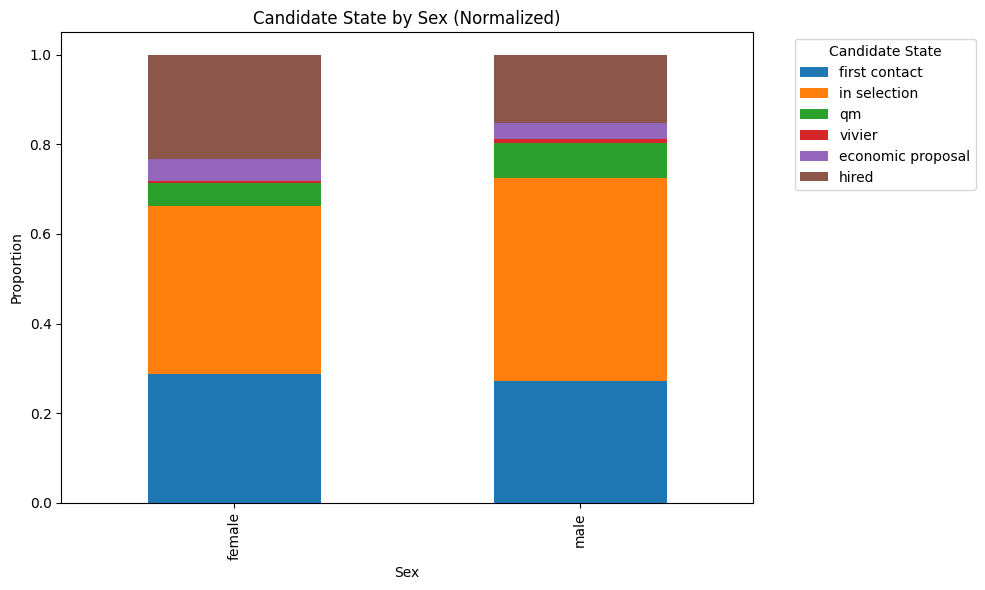

In [452]:
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Sex (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Sex')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### **Protected Category and Candidate State**

<ipython-input-453-6ad43d7f6e46>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(index='Protected Category', columns='Candidate State', aggfunc='size', fill_value=0)


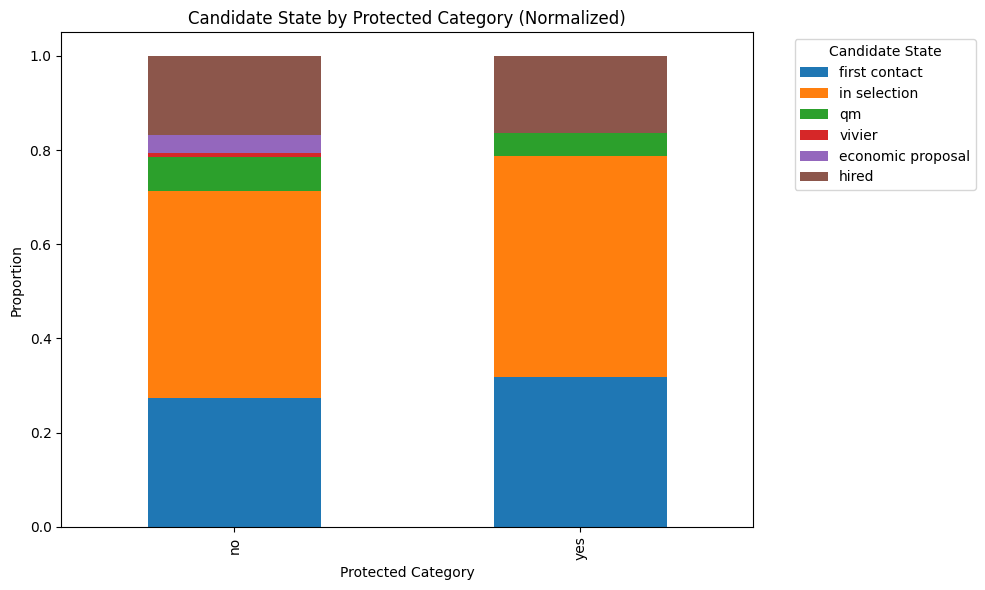

In [453]:
pivot = df.pivot_table(index='Protected Category', columns='Candidate State', aggfunc='size', fill_value=0)
pivot_percentage = pivot.div(pivot.sum(axis=1), axis=0)

pivot_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Candidate State by Protected Category (Normalized)')
plt.ylabel('Proportion')
plt.xlabel('Protected Category')
plt.legend(title='Candidate State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### **Age Range and Candidate State**

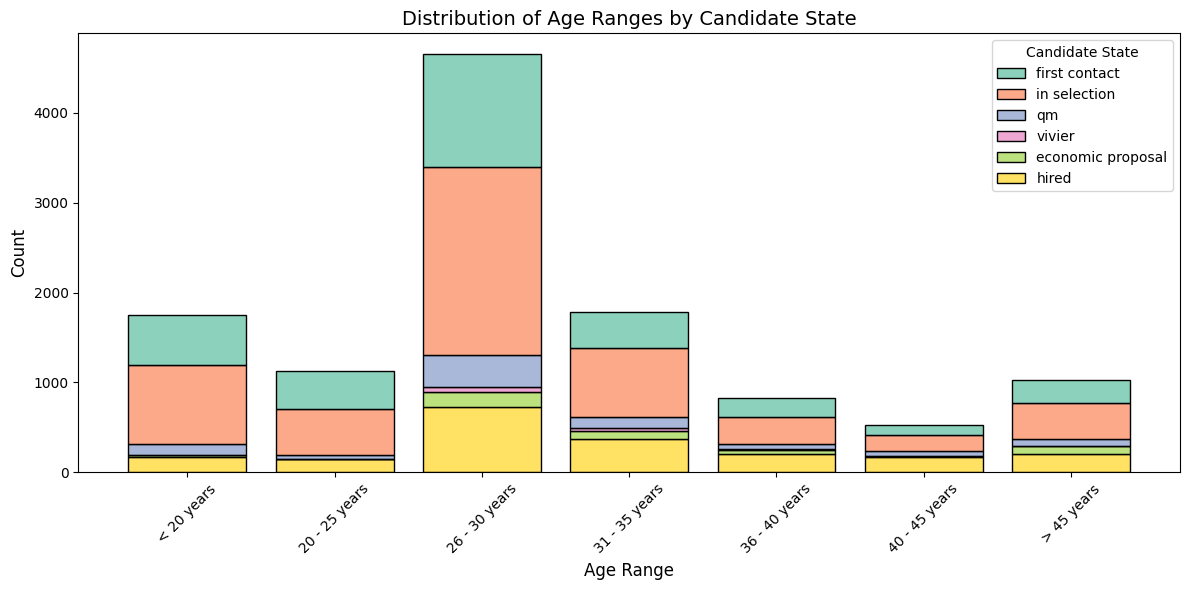

<ipython-input-454-80098279f405>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


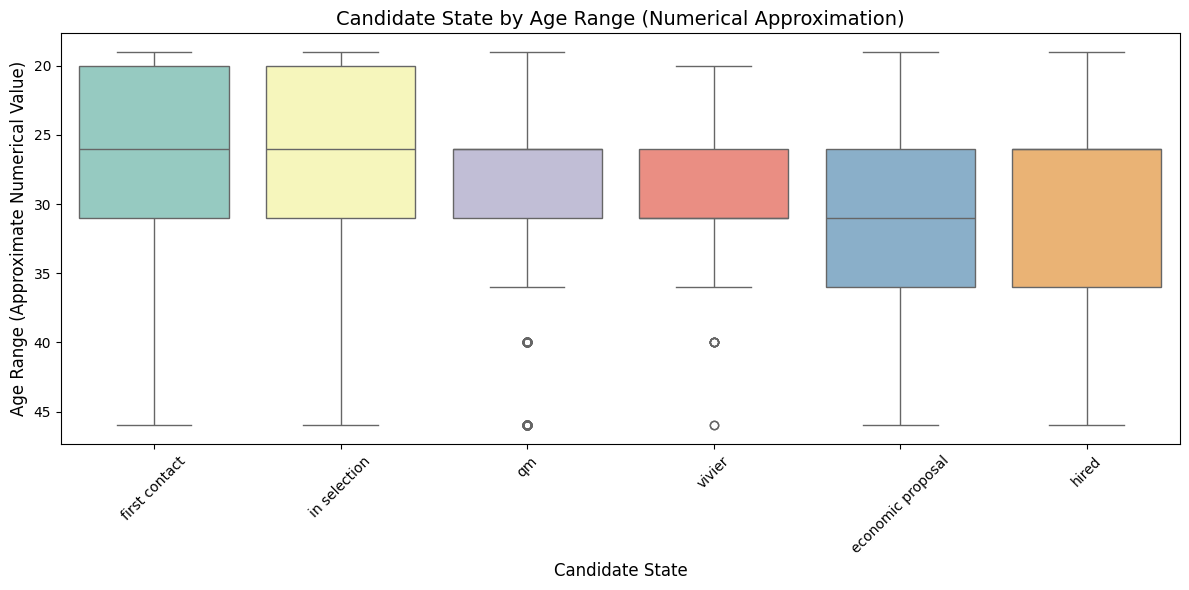

In [454]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data= df,
    x='Age Range',
    hue='Candidate State',
    multiple='stack',
    palette='Set2',
    shrink=0.8,
    legend=True
)
plt.title("Distribution of Age Ranges by Candidate State", fontsize=14)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Candidate State',
    y=df['Age Range'].map(lambda x: int(x.split('-')[0]) if '-' in x else (19 if '<' in x else 46)),
    palette='Set3'
)
plt.title("Candidate State by Age Range (Numerical Approximation)", fontsize=14)
plt.xlabel("Candidate State", fontsize=12)
plt.ylabel("Age Range (Approximate Numerical Value)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### **Correlation**

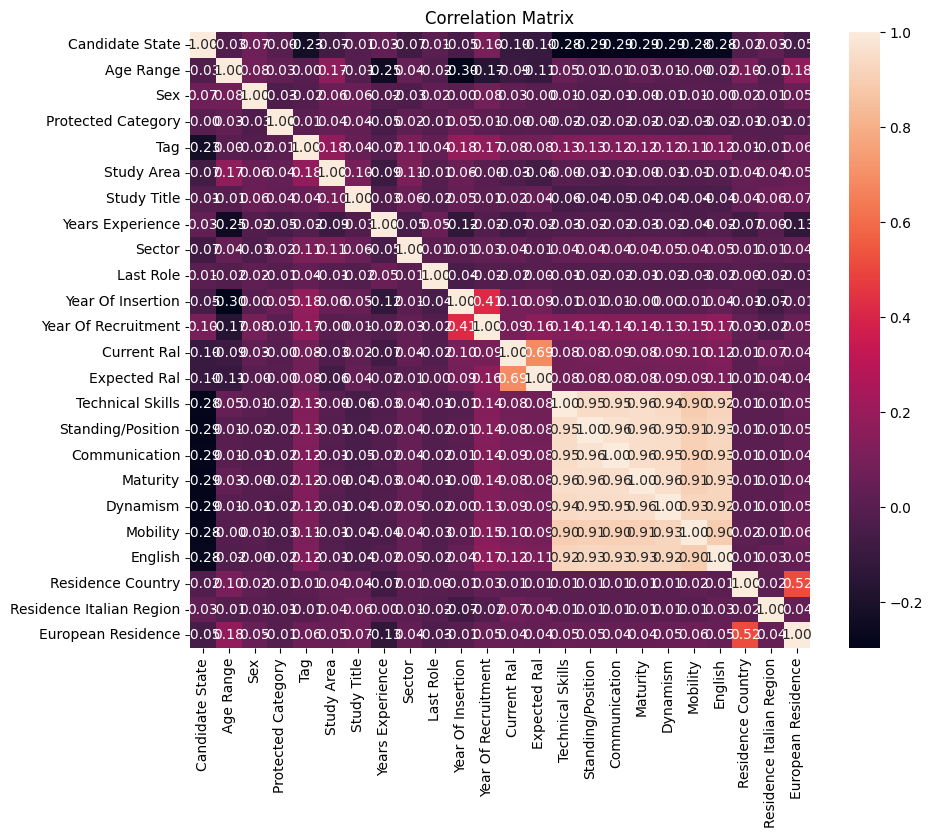

In [455]:
df_encoded = df.copy()
df_encoded.drop(columns=job_offer_columns, inplace=True)
df_encoded.drop(columns=akkodis_col, inplace=True)

age_mapping = {
    '< 20 years': 1,
    '20 - 25 years': 2,
    '26 - 30 years': 3,
    '31 - 35 years': 4,
    '36 - 40 years': 5,
    '40 - 45 years': 6,
    '> 45 years': 7
}

df_encoded['Age Range'] = df_encoded['Age Range'].map(age_mapping)

le = LabelEncoder()

for col in df_encoded.columns:
    if col != 'Age Range':
        df_encoded[col] = df_encoded[col].astype(str)
        df_encoded[col] = le.fit_transform(df_encoded[col])

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Job Offers dataset

In [471]:
job_offers_df = df[job_offer_columns].drop_duplicates()
job_offers_df = job_offers_df[~(job_offers_df == 'not specified').all(axis=1)]
job_offers_df = job_offers_df.reset_index(drop=True)

In [472]:
print(f"There are {job_offers_df.shape[0]} job offers")

There are 370 job offers


In [473]:
job_offers_df.head()

Recruitment Request Assumption Headquarters  \
0                              front-end developer                 bologna   
1                  powertrain calibration engineer                  modena   
2                                    not specified                  modena   
3              rs19.0865 -team procurement - milan                   milan   
4  hardware, software, networking mos&tggs support                   turin   

             Job Family Hiring   Job Title Hiring  \
0  tech consulting & solutions         consultant   
1                  engineering  junior consultant   
2                  engineering         consultant   
3                  engineering      not specified   
4                  engineering         consultant   

                                     Job Description  \
0  web developer – 03/06/23 • have 2+ years of ex...   
1  for our pwt team in the emilia area we are loo...   
2                                      not specified   
3        1 coordinator 1 senior buyer 1 junior buyer   
4  a. configuration of hardware, middleware, soft...   

                                   Candidate Profile Years Experience.1  \
0  web developer – 03/06/23 • have 2+ years of ex...              [1-3]   
1  ideal candidates have a master's degree in mec...              [0-1]   
2                                      not specified      not specified   
3        1 coordinator 1 senior buyer 1 junior buyer                [0]   
4  vmware vsphere, redhat linux os knowledge of n...              [3-5]   

     Minimum Ral    Ral Maximum                 Study Level  \
0         22-24k         28-30k           three-year degree   
1  not specified         24-26k            five-year degree   
2  not specified  not specified               not specified   
3  not specified  not specified  professional qualification   
4         28-30k         32-34k           three-year degree   

             Study Area.1  
0             informatics  
1  automotive engineering  
2           not specified  
3           not specified  
4    computer engineering

In [474]:
#descriptive columns
descr_job_offer_col = ['Recruitment Request', 'Job Description', 'Candidate Profile']

There are 0 (0.00%) 'not specified' for <Assumption Headquarters>




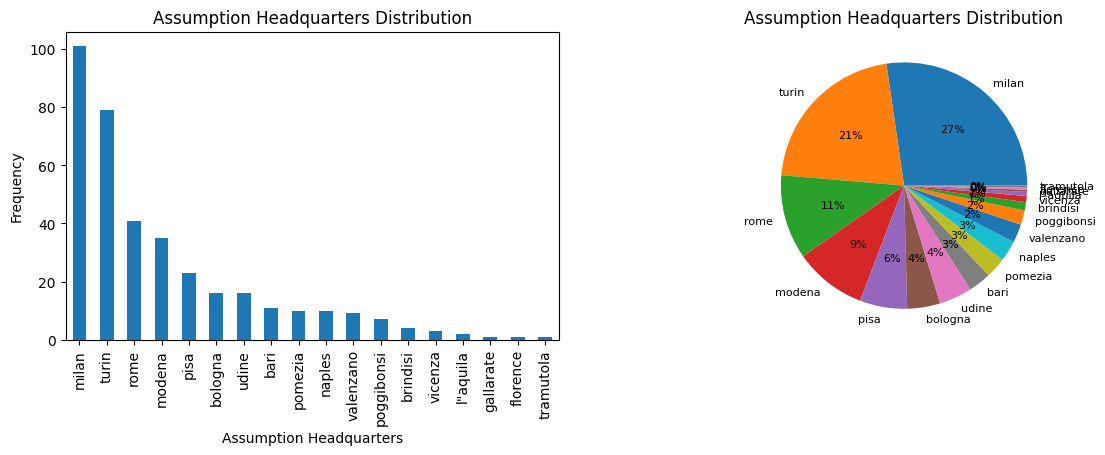




There are 0 (0.00%) 'not specified' for <Job Family Hiring>




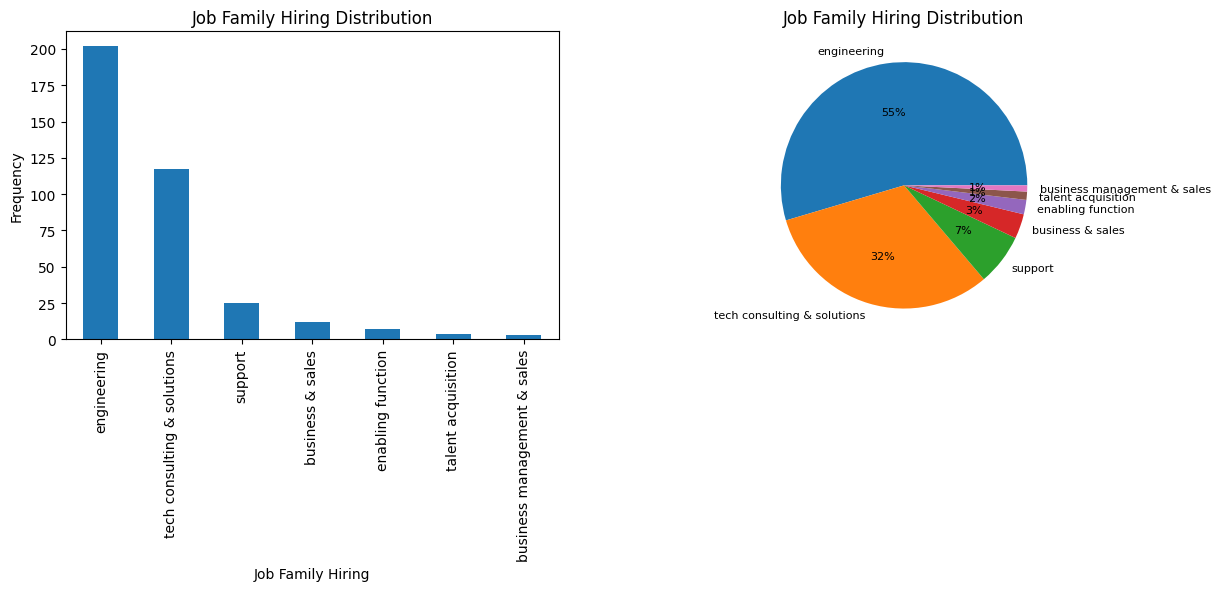




There are 22 (5.95%) 'not specified' for <Job Title Hiring>




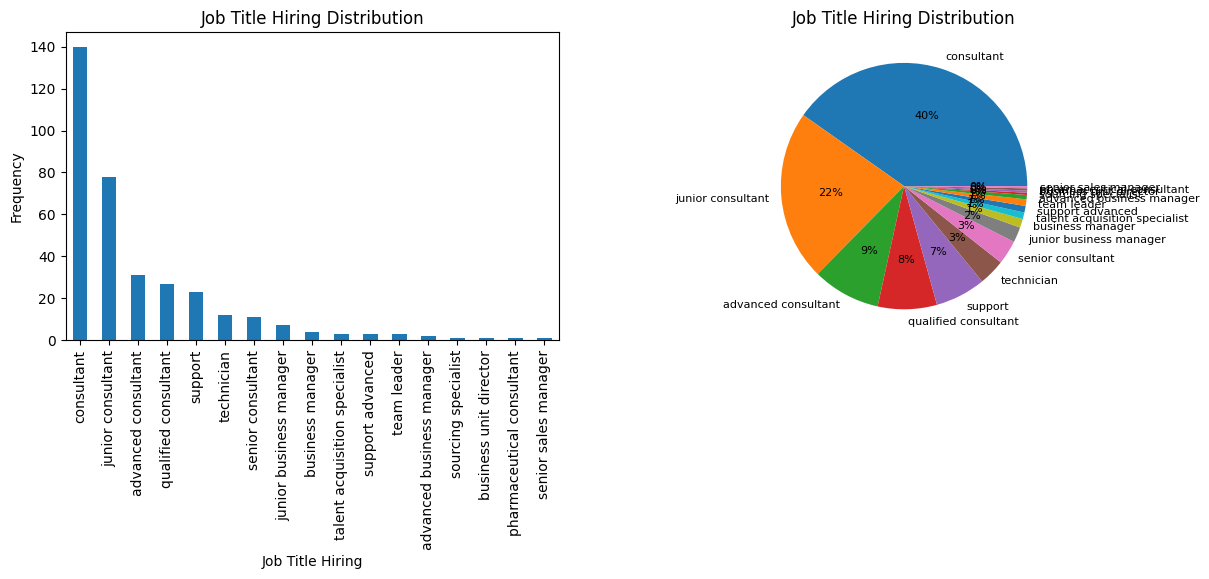




There are 21 (5.68%) 'not specified' for <Years Experience.1>




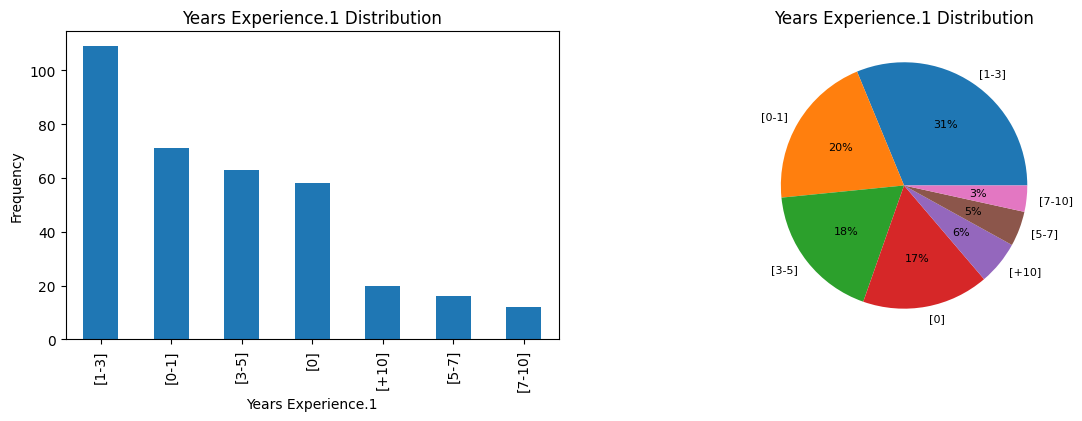




There are 180 (48.65%) 'not specified' for <Minimum Ral>




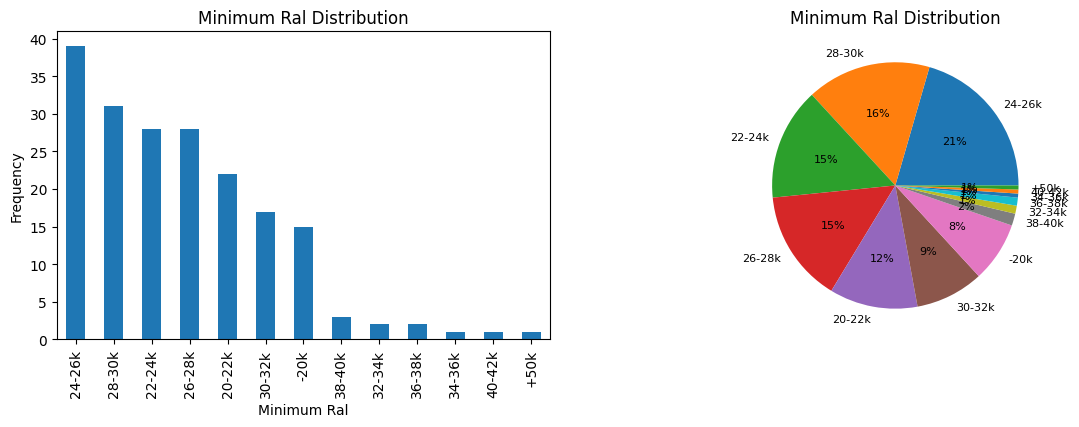




There are 120 (32.43%) 'not specified' for <Ral Maximum>




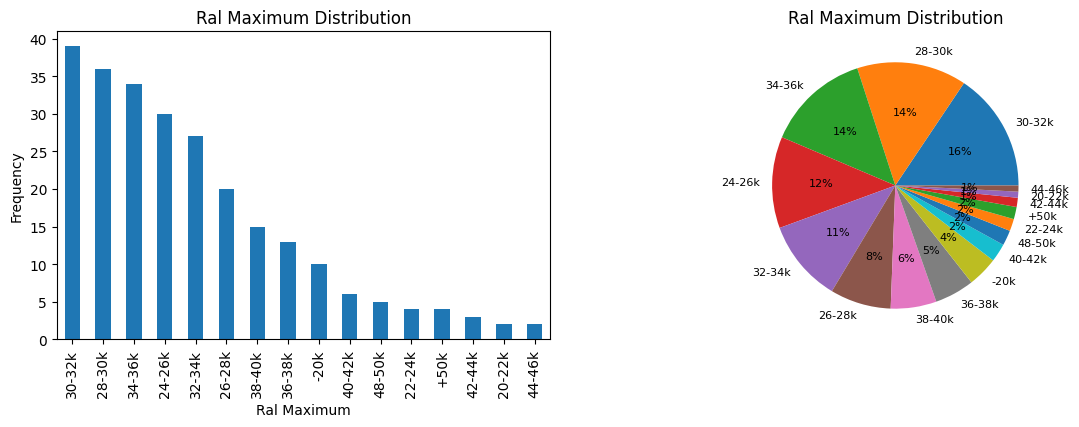




There are 21 (5.68%) 'not specified' for <Study Level>




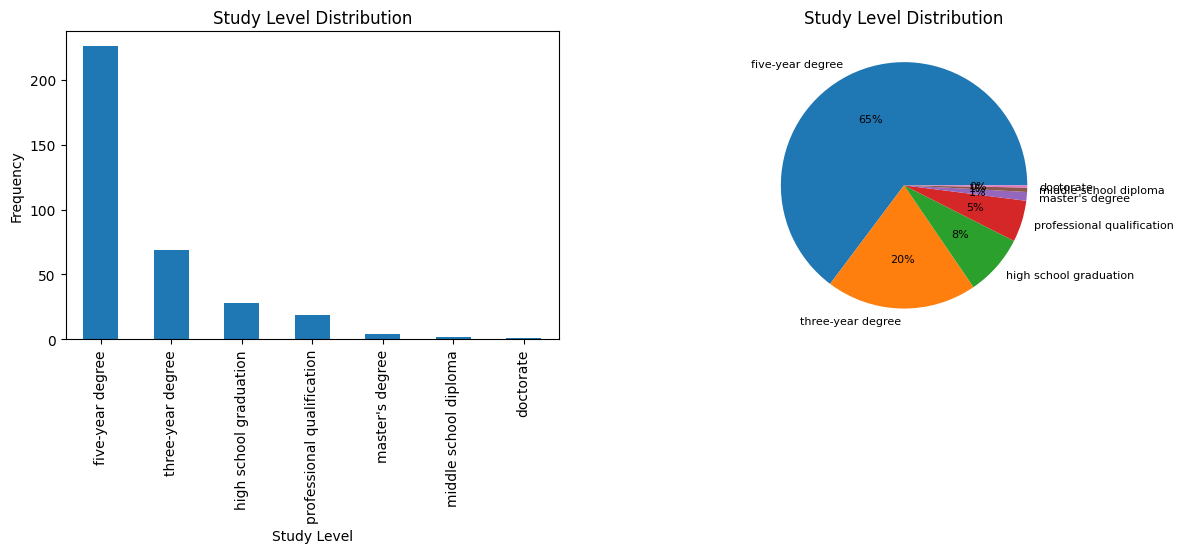




There are 68 (18.38%) 'not specified' for <Study Area.1>




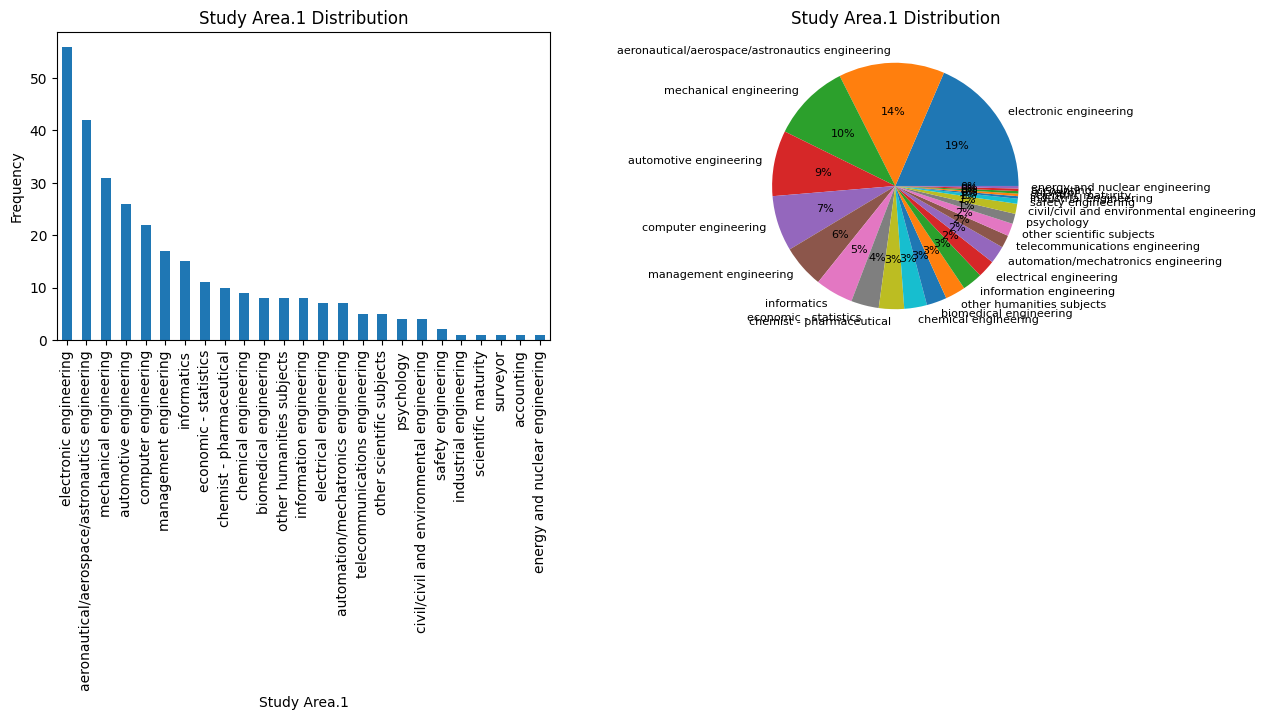

In [475]:
getJobStats()

In [476]:
col = 'Recruitment Request'
all_keywords = df.groupby('Id')[col].first().str.split(' ').explode()
all_keywords = all_keywords.str.title()
keyword_counts = Counter(all_keywords)

keyword_df = pd.DataFrame(keyword_counts.items(), columns=['Keyword', 'Count'])
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'Not'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'Specified'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '-'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == 'And'].index, inplace=True)
keyword_df.drop(keyword_df[keyword_df['Keyword'] == '&'].index, inplace=True)
keyword_df = keyword_df.sort_values(by='Count', ascending=False)

keyword_df.head(10)

Keyword  Count
6       Engineer    137
47        Junior     50
91       Manager     27
43      Software     25
29      Designer     18
5    Calibration     17
165       System     17
69       Project     17
17      Business     16
37    Specialist     15

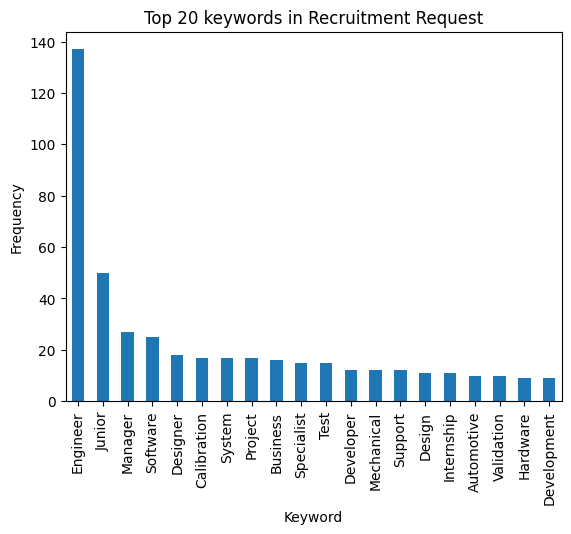

In [477]:
keyword_df.head(20).plot(x='Keyword', y='Count', kind='bar', legend=False)
plt.title(f'Top 20 keywords in {col}')
plt.ylabel('Frequency')
plt.xlabel('Keyword')
plt.show()


###Export

In [478]:
job_offers_df.to_excel(job_file_path, index=False)

In [479]:
#files.download(job_path)
#load to drive
destination_path = drive_dir + job_file_path
!cp "$job_file_path" "$destination_path"

## Candidates Dataset


### Multiple values
In order to keep one row for each candidate we need to assign a unique value for each column.
We can assign the *mean value* to numerical columns.

In [45]:
df = pd.read_excel(drive_dir + cleaned_file_path)

In [46]:
candidates = df['Id'].unique().tolist()

In [480]:
changing_cols = []

for col in df.columns:
  perc = multiple_percentage(df, col, 2, len(candidates))
  if perc > 0:
    changing_cols.append(col)
    print(f"{perc:.2f}% have multiple values for {col}")

42.00% have multiple values for Event_Type__Val
16.08% have multiple values for Event_Feedback
11.42% have multiple values for Overall
12.53% have multiple values for Technical Skills
13.24% have multiple values for Standing/Position
14.00% have multiple values for Communication
14.37% have multiple values for Maturity
15.47% have multiple values for Dynamism
15.69% have multiple values for Mobility
9.81% have multiple values for English


In [481]:
num_changing_cols = changing_cols.copy()
num_changing_cols.remove('Event_Type__Val')
num_changing_cols.remove('Event_Feedback')

For numerical columns with different values we will assign the mean value.

In [482]:
for col in num_changing_cols:
    df[col] = df.groupby('Id')[col].transform(custom_mean)

In [483]:
changing_cols = []

for col in df.columns:
  perc = multiple_percentage(df, col, 2, len(candidates))
  if perc > 0:
    changing_cols.append(col)
    print(f"{perc:.2f}% have multiple values for {col}")

42.00% have multiple values for Event_Type__Val
16.08% have multiple values for Event_Feedback


### Candidates we don't know enough about

Since we will only consider as *eligible* candidates who have been hired and therefore have a specified position, `Event_Type__Val` and `Event_Feedback` can only be useful if we use them to remove candidates for whom we cannot say they were unsuitable.
Keeping this information could mislead the model, as it is clear that candidates who are further along in the recruitment process are more likely to be hired. However, the stages of the recruitment process are not necessarily associated with the skills of the candidates. Additionally, the model will only be used in the early stages of the recruitment process, meaning this information will not yet be available.

#### Candidate State
Candidates with "Economic proposal" as `Candidate State` should be considered suitable. However they don't have any position specified. `Vivier` as well could be considered in some cases suitable, as we can also find 'vivier' in`Recruitment Request` values.

In [485]:
print(df.groupby('Id')['Candidate State'].last().value_counts())

Candidate State
first contact        2667
in selection         1793
hired                 430
qm                    182
economic proposal      66
vivier                 19
Name: count, dtype: int64


#### Event_Feedback

In [486]:
print(df['Event_Feedback'].unique())

['not specified' 'ok' 'ko (manager)' 'ok (other candidate)' 'ok (live)'
 'ko (technical skills)' 'ko (mobility)' 'ko (retired)' 'ko (seniority)'
 'ko (ral)' 'ko (opportunity closed)' 'ko (proposed renunciation)'
 'ok (waiting for departure)' 'ko (language skills)'
 'ko (lost availability)' 'ok (hired)']


- `Not Specified`
- `OK`
- `KO (manager)`
- `OK (other candidate)`: the candidate could be eligible, but another person was hired instead
- `OK (live)`
- `KO (technical skills)`
- `KO (mobility)`
- `KO (retired)`: the candidate retired, we don't know if they were suitable
- `KO (seniority)`
- `KO (ral)`: the candidate has given up the position because of RAL
- `KO (opportunity closed)`: the opportunity isn't available anymore, we don't knw if the candidate was suitable
- `KO (proposed renunciation)`: the candidate has given up?
- `OK (waiting for departure)`: the candidate is going to be hired, therefore is suitable
- `KO (language skills)`
- `KO (lost availability)`: the candidate is not available anymore, we don't know if they were suitable
- `OK (hired)`: definitely suitable

In [493]:
feedbacks = ['ok (other candidate)', 'ko (retired)', 'ko (ral)', 'ko (opportunity closed)',
             'ko (proposed renunciation)', 'ok (waiting for departure)', 'ko (lost availability)', 'ok (hired)']

In [494]:
filtered_df = df.loc[(df['Candidate State'] != 'hired') & (df['Candidate State'] != 'economic proposal') & (df['Candidate State'] != 'vivier') & (df['Event_Feedback'].isin(feedbacks))]

In [495]:
print(filtered_df['Id'].unique().shape[0])

240


In [497]:
print(filtered_df[['Event_Type__Val', 'Event_Feedback']].value_counts())

Event_Type__Val         Event_Feedback            
bm interview            ok (other candidate)          86
                        ko (retired)                  28
sending sc to customer  ko (opportunity closed)       20
bm interview            ko (proposed renunciation)    15
hr interview            ko (ral)                      14
                        ko (retired)                  14
bm interview            ko (ral)                      12
technical interview     ko (lost availability)         9
sending sc to customer  ko (retired)                   7
hr interview            ok (other candidate)           7
qualification meeting   ko (proposed renunciation)     6
bm interview            ok (waiting for departure)     6
qualification meeting   ko (retired)                   4
sending sc to customer  ko (proposed renunciation)     4
technical interview     ko (retired)                   3
qualification meeting   ok (other candidate)           3
                        ok (waiting f

#### Event_Type__Val
Possible chronological order for **`Event_Type__Val`**:
- *Initial phases*:
  - `Commercial note`
  - `CV request`
  - `Inadequate CV`
  - `Contact note`
  - `Research association`
- *Central phases*:
  - `HR interview`
  - `BM interview`
  - `Technical interview`
  - `Qualification Meeting`
  - `Candidate notification`
- *Final phases*
  - `Sending SC to customer`
  - `Economic proposal`
  - `Notify candidate`

Candidates in final stages should be considered eligible.







In [498]:
print(df['Event_Type__Val'].unique())

['not specified' 'research association' 'bm interview' 'cv request'
 'contact note' 'hr interview' 'commercial note' 'candidate notification'
 'sending sc to customer' 'technical interview' 'economic proposal'
 'inadequate cv' 'qualification meeting' 'notify candidate']


In [501]:
etvs = ['sending sc to customer', 'economic proposal', 'notify candidate']

In [502]:
filtered_df = df.loc[(df['Candidate State'] != 'hired') & (df['Candidate State'] != 'economic proposal') & (df['Candidate State'] != 'vivier') & (~df['Event_Feedback'].isin(feedbacks)) & (df['Event_Type__Val'].isin(etvs))]

In [503]:
print(filtered_df['Id'].unique().shape[0])

147


In [504]:
filtered_df = df[(df['Candidate State'] == 'hired') | (df['Candidate State'] == 'economic proposal') ]
print(filtered_df['Event_Type__Val'].value_counts())

Event_Type__Val
bm interview              980
contact note              317
hr interview              266
candidate notification    242
qualification meeting     122
sending sc to customer    107
technical interview       107
cv request                103
economic proposal          67
research association       51
commercial note            15
inadequate cv              12
notify candidate            6
not specified               3
Name: count, dtype: int64


In [505]:
filtered_df = df[df['Candidate State'] == 'first contact' ]
print(filtered_df['Event_Type__Val'].value_counts())

Event_Type__Val
not specified             1464
contact note              1026
cv request                 257
candidate notification     232
technical interview        133
research association        57
inadequate cv               17
commercial note             15
bm interview                 2
sending sc to customer       1
Name: count, dtype: int64


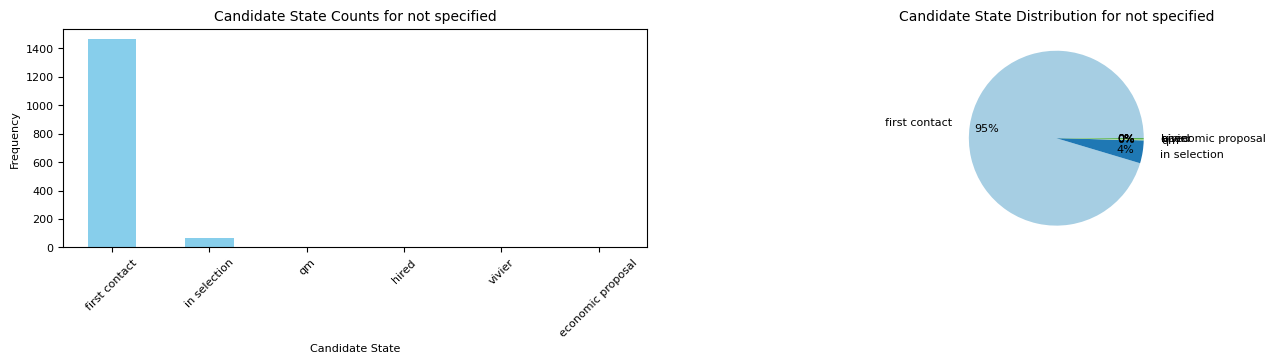

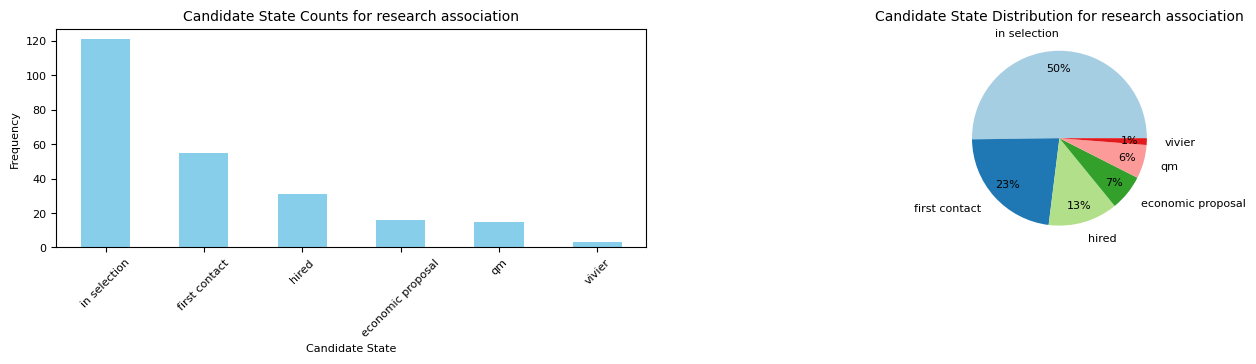

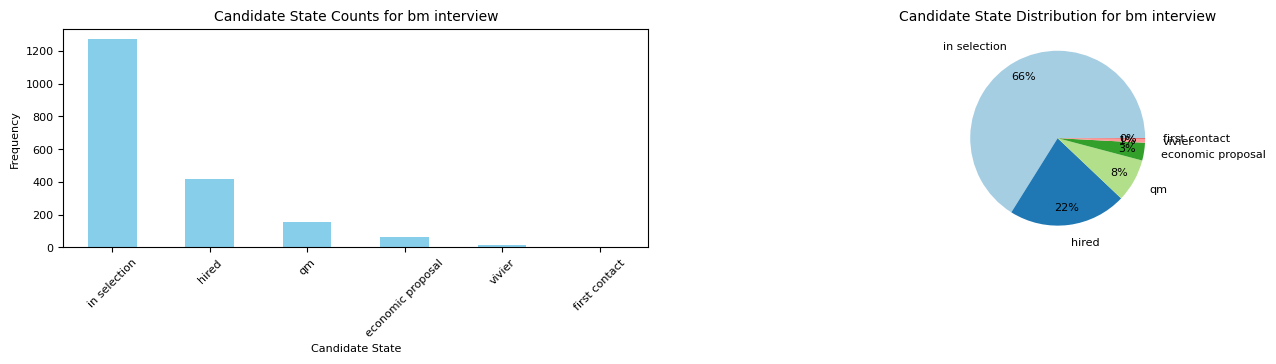

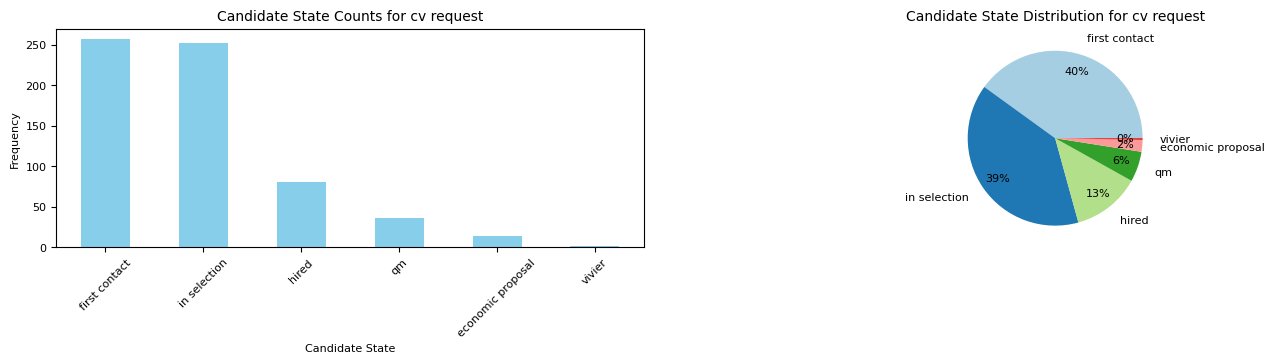

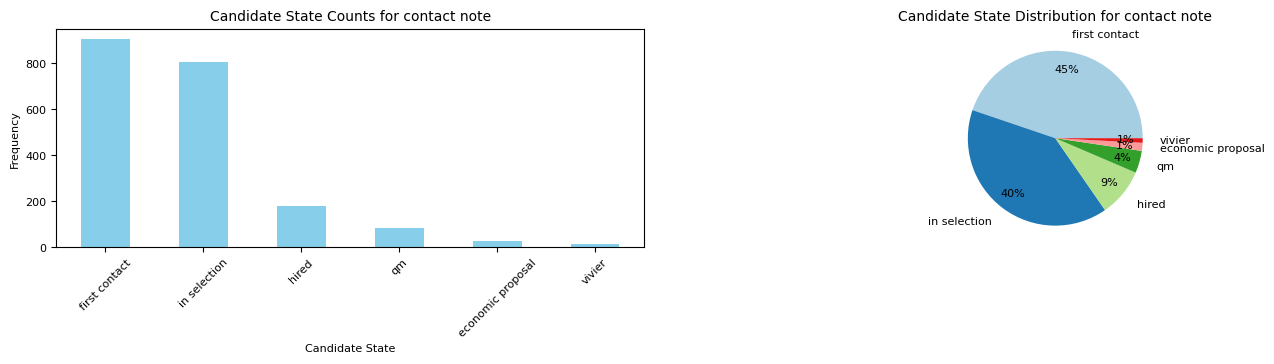

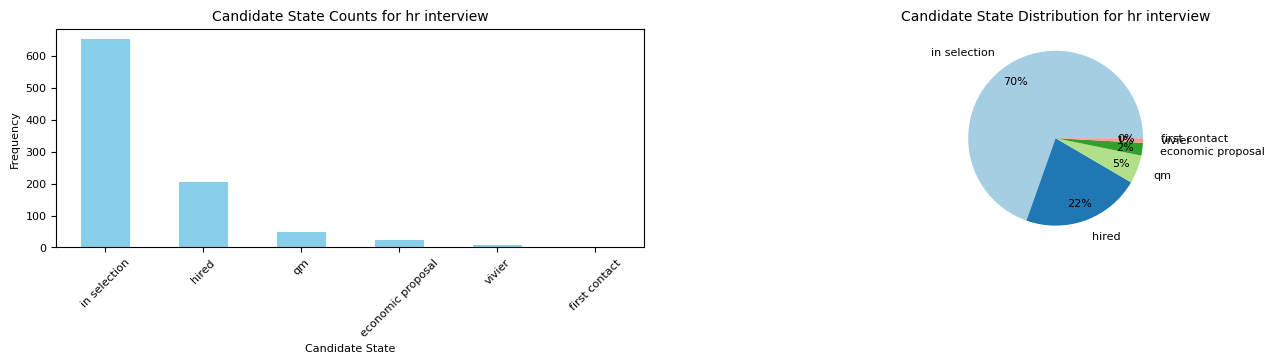

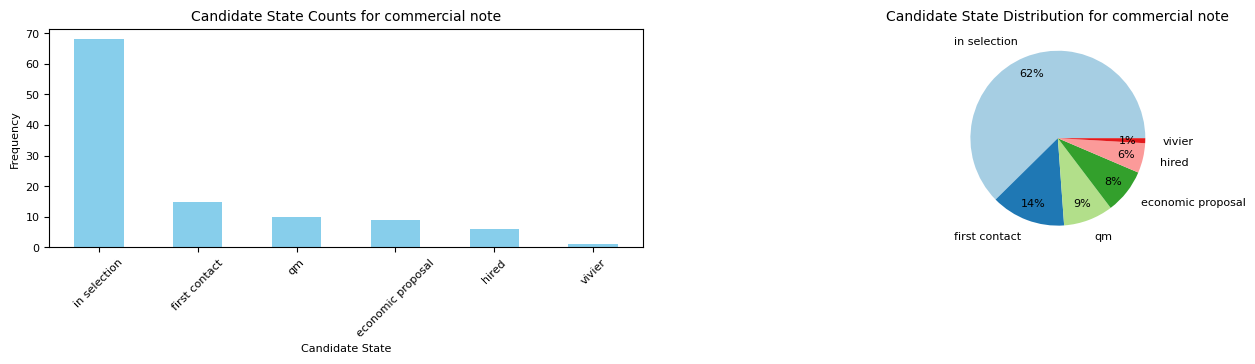

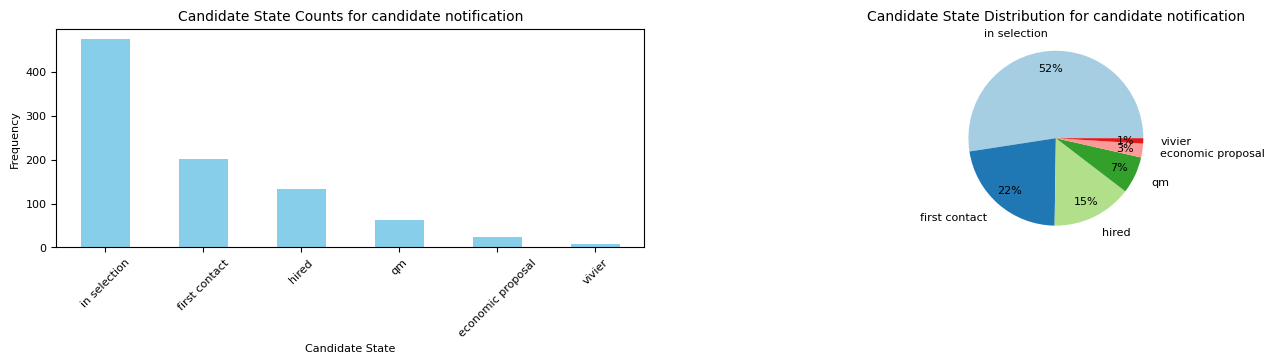

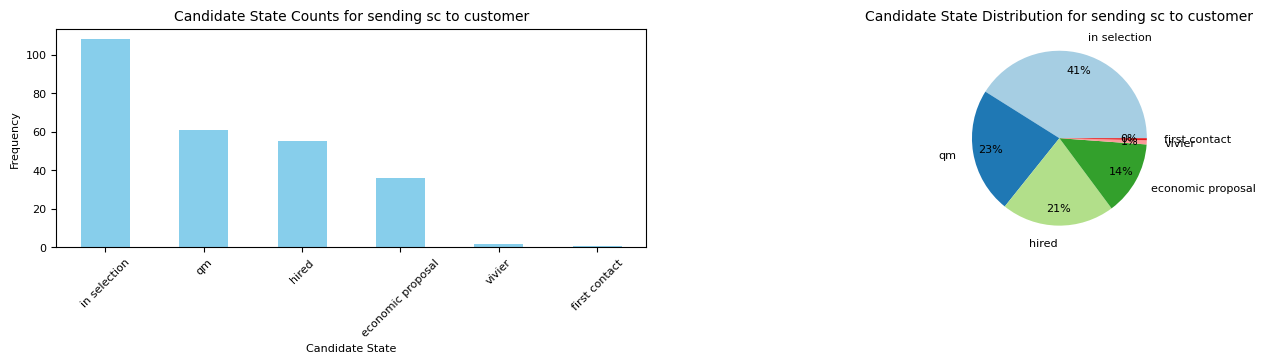

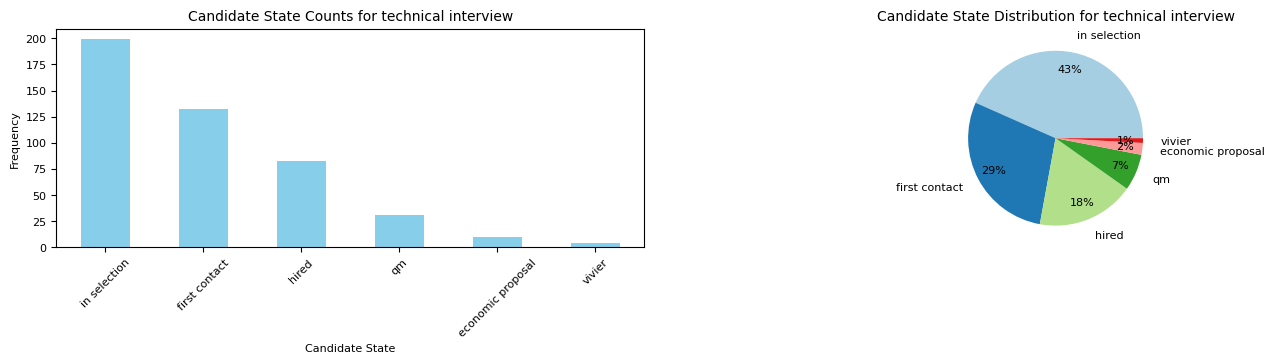

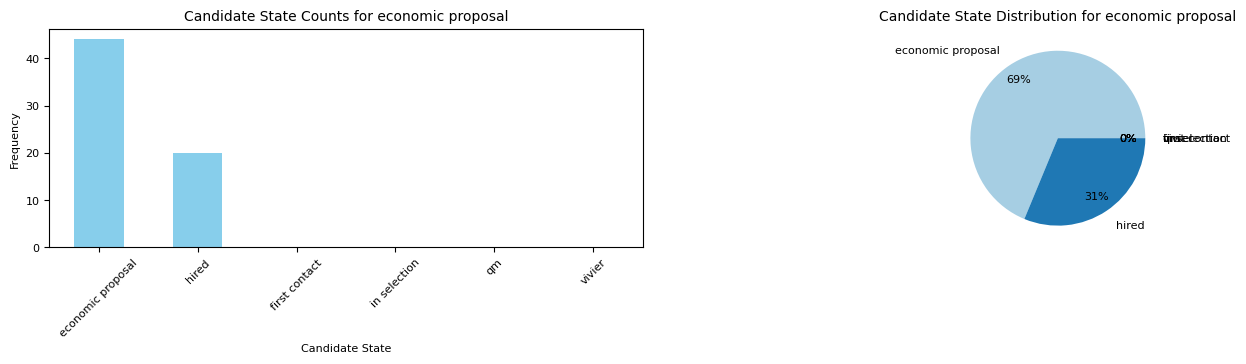

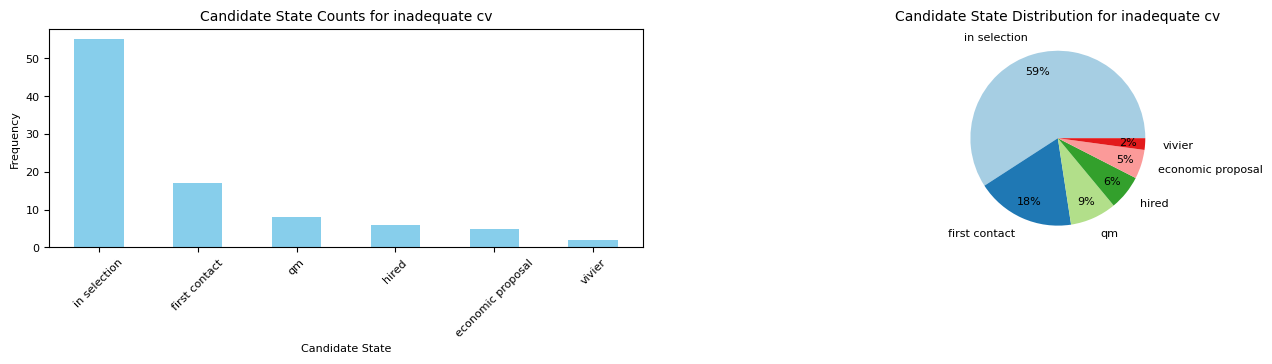

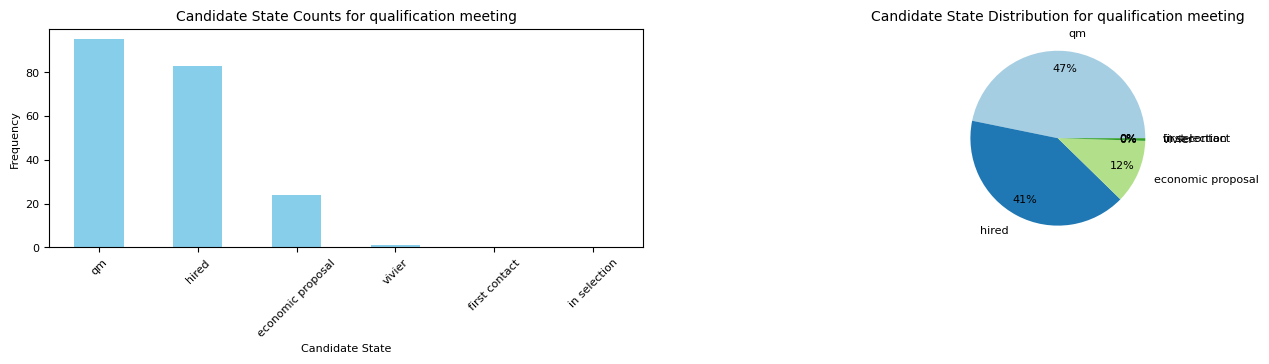

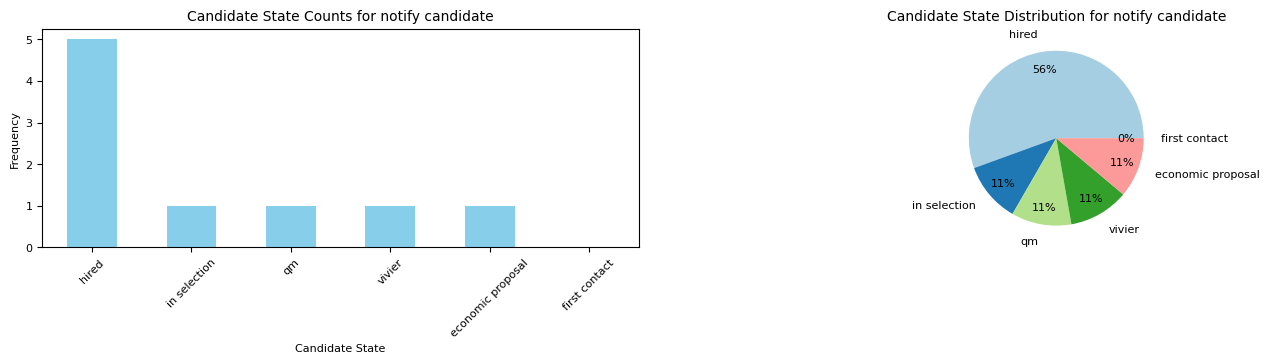

In [506]:
for etv in df['Event_Type__Val'].unique():
  filtered_df = df.loc[df['Event_Type__Val'] == etv]
  plot_graphs(filtered_df, 'Candidate State', etv)

###Cleaning
For now we will discard candidates with 'Vivier' and 'Economic Proposal' as `Candidate State` and all the candidates with `Event_Feedback` such as 'ok (other candidate)', 'ko (retired)', 'ko (ral)'...
We will not discard candidates with final stages of recruiting .

In [507]:
cand_states = ['vivier, economic proposal']
feedbacks = ['ok (other candidate)', 'ko (retired)', 'ko (ral)', 'ko (opportunity closed)',
             'ko (proposed renunciation)', 'ok (waiting for departure)', 'ko (lost availability)', 'ok (hired)']

In [508]:
df_filtered = df[df['Candidate State'] != 'hired']

df_filtered = df_filtered[
    (df_filtered['Event_Feedback'].isin(feedbacks)) |
    (df_filtered['Candidate State'].isin(cand_states))
]

ids_to_drop = df_filtered['Id'].unique()

In [509]:
df = df[~df['Id'].isin(ids_to_drop)]
candidates = df['Id'].unique().tolist()

We can now discard `Event_Type__Val` and `Event_Feedback` as they aren't useful for the model training, since they wouldn't be available in the first place.

In [510]:
df = df.drop(columns=['Event_Type__Val', 'Event_Feedback'])

In [511]:
df = df.drop_duplicates()

###Export

In [512]:
df.to_excel(candidates_file_path, index=False)

In [513]:
destination_path = drive_dir + candidates_file_path
!cp "$candidates_file_path" "$destination_path"

###Candidates + Job Positions

In [23]:
df = pd.read_excel(drive_dir + candidates_file_path)

#### Target Column: **Hired**
A new column `Hired` is added to label (candidate-position) pairs.
This column will be used as **TARGET** in the training phase.

In [24]:
df['Hired'] = 0
df.loc[df['Candidate State'] == 'hired', 'Hired'] = 1

We need to assign a unique ID for each job position in the jobs dataset, in order to create unique negative (candidate-position) pairs.

In [25]:
job_df = pd.read_excel(drive_dir + job_file_path)
job_df = job_df.reset_index(drop=True)
job_df['ID'] = job_df.index
job_df = job_df[['ID'] + [col for col in job_df.columns if col != 'ID']]

In [26]:
job_df.head()

ID                              Recruitment Request  \
0   0                              front-end developer   
1   1                  powertrain calibration engineer   
2   2                                    not specified   
3   3              rs19.0865 -team procurement - milan   
4   4  hardware, software, networking mos&tggs support   

  Assumption Headquarters            Job Family Hiring   Job Title Hiring  \
0                 bologna  tech consulting & solutions         consultant   
1                  modena                  engineering  junior consultant   
2                  modena                  engineering         consultant   
3                   milan                  engineering      not specified   
4                   turin                  engineering         consultant   

                                     Job Description  \
0  web developer – 03/06/23 • have 2+ years of ex...   
1  for our pwt team in the emilia area we are loo...   
2                                      not specified   
3        1 coordinator 1 senior buyer 1 junior buyer   
4  a. configuration of hardware, middleware, soft...   

                                   Candidate Profile Years Experience.1  \
0  web developer – 03/06/23 • have 2+ years of ex...              [1-3]   
1  ideal candidates have a master's degree in mec...              [0-1]   
2                                      not specified      not specified   
3        1 coordinator 1 senior buyer 1 junior buyer                [0]   
4  vmware vsphere, redhat linux os knowledge of n...              [3-5]   

     Minimum Ral    Ral Maximum                 Study Level  \
0         22-24k         28-30k           three-year degree   
1  not specified         24-26k            five-year degree   
2  not specified  not specified               not specified   
3  not specified  not specified  professional qualification   
4         28-30k         32-34k           three-year degree   

             Study Area.1  
0             informatics  
1  automotive engineering  
2           not specified  
3           not specified  
4    computer engineering

We can now add a `Job Id` column and fill the right value for each position already specified.

In [27]:
df.loc[df['Candidate State'] == 'hired', 'Job ID'] = df[df['Candidate State'] == 'hired'].apply(lambda row: job_id_finder(row, job_df), axis=1)

For each hired candidate we add **k-1** more rows with negative pairs of (candidate-job), labeled with `Hired` = 0.

In [28]:
k = 3
hired_candidates = df[df['Candidate State'] == 'hired']
job_ids = job_df['ID'].tolist()
negative_rows = []

for _, candidate in hired_candidates.iterrows():
    remaining_job_ids = [job_id for job_id in job_ids if job_id != candidate['Job ID']]
    random_job_ids = np.random.choice(remaining_job_ids, size=k-1, replace=False)


    for random_job_id in random_job_ids:
        negative_row = candidate.copy()
        negative_row['Job ID'] = random_job_id
        negative_row['Hired'] = 0
        for col in job_df.columns:
          if col != 'ID':
            negative_row[col] = job_df[job_df['ID'] == random_job_id][col].values[0]
        negative_rows.append(negative_row)

negative_df = pd.DataFrame(negative_rows)
df_with_negatives = pd.concat([df, negative_df], ignore_index=True)

print(df_with_negatives)


         Id Candidate State      Age Range     Sex Protected Category  \
0        41   first contact  31 - 35 years    male                 no   
1        47   first contact  36 - 40 years    male                 no   
2        84   first contact  26 - 30 years    male                 no   
3       134   first contact  40 - 45 years    male                 no   
4       137    in selection     < 20 years  female                 no   
...     ...             ...            ...     ...                ...   
5726  81278           hired  26 - 30 years    male                 no   
5727  81452           hired  26 - 30 years    male                 no   
5728  81452           hired  26 - 30 years    male                 no   
5729  81510           hired  26 - 30 years  female                 no   
5730  81510           hired  26 - 30 years  female                 no   

                                                   Tag  \
0                                        not specified   
1      

For each candidate with `Candidate State` != 'Hired' we add **k** rows with **k** random job positions, labeled with `Hired` = 0. The original rows with no position specified are removed.

In [29]:
k = 3
not_hired_candidates = df[df['Candidate State'] != 'hired']
job_ids = job_df['ID'].tolist()
negative_rows = []

for _, candidate in not_hired_candidates.iterrows():
    random_job_ids = np.random.choice(job_ids, size=k, replace=False)


    for random_job_id in random_job_ids:
        negative_row = candidate.copy()
        negative_row['Job ID'] = random_job_id
        negative_row['Hired'] = 0
        for col in job_df.columns:
          if col != 'ID':
            negative_row[col] = job_df[job_df['ID'] == random_job_id][col].values[0]
        negative_rows.append(negative_row)

negative_df = pd.DataFrame(negative_rows)
df_with_negatives = df_with_negatives[~df_with_negatives['Id'].isin(not_hired_candidates['Id'].tolist())]
df_with_negatives_2 = pd.concat([df_with_negatives, negative_df], ignore_index=True)

print(df_with_negatives_2)


          Id Candidate State      Age Range     Sex Protected Category  \
0        165           hired  26 - 30 years    male                 no   
1        369           hired  26 - 30 years  female                 no   
2        423           hired  36 - 40 years    male                 no   
3       1006           hired     > 45 years    male                 no   
4       1038           hired  26 - 30 years    male                 no   
...      ...             ...            ...     ...                ...   
14608  81627   first contact  26 - 30 years    male                 no   
14609  81627   first contact  26 - 30 years    male                 no   
14610  81630    in selection  20 - 25 years    male                 no   
14611  81630    in selection  20 - 25 years    male                 no   
14612  81630    in selection  20 - 25 years    male                 no   

                                                     Tag  \
0                                   angular, javasc

In [30]:
df = df_with_negatives_2

In [31]:
df.to_excel(final_file_path, index=False)
destination_path = drive_dir + final_file_path
!cp "$final_file_path" "$destination_path"

The `Tag` column has NaN values. We check in the original dataset and then we can replace with 'Not Specified'.

In [32]:
for col in df.columns:
  num = df.loc[df[col].isna()].shape[0]
  if num > 0:
    print(f"{col}: {num}")

Tag: 3


In [149]:
original_df = pd.read_excel(drive_dir + original_file_path)

In [159]:
ids = df.loc[df['Tag'].isna(), 'Id'].unique().tolist()
print(original_df.loc[original_df['ID'].isin(ids)])

         ID  Candidate State      Age Range  \
6634  50822    First contact  26 - 30 years   
6635  50822    First contact  26 - 30 years   
6636  50822    First contact  26 - 30 years   
6637  50822    First contact  26 - 30 years   
7362  50822         Imported  26 - 30 years   

                                Residence     Sex  Protected category     TAG  \
6634             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6635             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6636             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
6637             TURIN » Turin ~ Piedmont  Female                 NaN  N/A, X   
7362  MAZARA DEL VALLO » Trapani ~ Sicily  Female                 NaN     NaN   

                Study area       Study Title  Years Experience  ...  \
6634  chemical engineering  Five-year degree             [0-1]  ...   
6635  chemical engineering  Five-year degree             [0-1]  ...   
6636  chemical en

In [33]:
 df['Tag'] = df['Tag'].fillna('not specified')

### Columns to drop
Some columns should not be used by the model:
- `Id`: not relevant for the suitability of a candidate
- `Candidate State`: not known
- `Year Of Insertion`: not relevant to the suitability of a candidate
- `Year Of Recruitment`: not known
- `Akkodis Headquarters`: not relevant to the suitability of a candidate


In [34]:
col_to_drop = ['Id', 'Candidate State', 'Year Of Insertion', 'Year Of Recruitment', 'Akkodis Headquarters']

In [35]:
df = df.drop(columns=col_to_drop)

In [165]:
df.head()

Age Range     Sex Protected Category  \
0  26 - 30 years    male                 no   
1  26 - 30 years  female                 no   
2  36 - 40 years    male                 no   
3     > 45 years    male                 no   
4  26 - 30 years    male                 no   

                                                 Tag              Study Area  \
0                               angular, javascript.             informatics   
1                                             matlab  mechanical engineering   
2  blood lines, medical device, medical devices d...             informatics   
3                                      not specified                   other   
4                                      not specified             informatics   

              Study Title Years Experience         Sector  \
0       three-year degree            [1-3]        telecom   
1       three-year degree            [1-3]     automotive   
2  high school graduation            [+10]  life sciences   
3  high school graduation            [+10]         energy   
4  high school graduation            [1-3]     consulting   

             Last Role                              Recruitment Request  ...  \
0  front-end developer                              front-end developer  ...   
1                 none                  powertrain calibration engineer  ...   
2     technical leader                                    not specified  ...   
3         senior buyer              rs19.0865 -team procurement - milan  ...   
4      system engineer  hardware, software, networking mos&tggs support  ...   

  Communication Maturity Dynamism Mobility English Residence Country  \
0             3        3        3        1       3             italy   
1             3        2        2        2       3             italy   
2             3        3        2        1       2             italy   
3             2        2        2        2       2             italy   
4             2        3        2        2       3             italy   

  Residence Italian Region European Residence Hired Job ID  
0                  tuscany           european     1    0.0  
1                 lombardy           european     1    1.0  
2           emilia romagna           european     1    2.0  
3                 lombardy           european     1    3.0  
4                 piedmont           european     1    4.0  

[5 rows x 35 columns]

### New columns

#### Distance
With Residence and Assumption Headquarters we can estimate the distance, through their coordinates.

`it_df` is a dataset that contains coordinates for italian cities.

In [36]:
it_df = pd.read_csv(drive_dir + it_csv_path)

In [37]:
region_to_coords = {
    row['admin_name']: (row['lat'], row['lng'])
    for _, row in it_df[it_df['capital'].isin(['primary', 'admin'])].iterrows()
}

def get_coords(region):
    return region_to_coords.get(region, (None, None))

df['Residence_coord'] = df['Residence Italian Region'].apply(get_coords)

In [38]:
city_to_coords = {
    row['city']: (row['lat'], row['lng'])
    for _, row in it_df.iterrows()
}

def get_city_coords(region):
    return city_to_coords.get(region, (None, None))

df['Assumption_coord'] = df['Assumption Headquarters'].apply(get_city_coords)

`countries_df` is a dataset that contains coordinates for countries.

In [39]:
countries_df = pd.read_csv(drive_dir + countries_csv_path)

In [40]:
for country in df['Residence Country'].unique():
  if country.title() not in countries_df['name'].unique():
    print(f"{country}: {country.title() in countries_df['name'].unique()}")

yugoslavia: False
serbia and montenegro: False


In [41]:
country_coords = {
    row['name'].lower(): (row['latitude'], row['longitude'])
    for _, row in countries_df.iterrows()
}

def get_residence_coord(row):
    if row['Residence Country'] == 'italy':
      return row['Residence_coord']
    elif row['Residence Country'] in ['yugoslavia', 'serbia and montenegro']:
        return (44.787197, 20.457273)
    return country_coords.get(row['Residence Country'], None)

df['Residence_coord'] = df.apply(get_residence_coord, axis=1)


In [42]:
df['Distance (km)'] = df.apply(calculate_distance, axis=1)

#### Similarity_Score
The similarity score between candidate's descriptive columns and job offer's descriptive columns can be obtained through the cosine_similarity.

In [43]:
stop_words = set(ENGLISH_STOP_WORDS)

candidate_columns = ['Tag', 'Study Area', 'Sector', 'Last Role']
position_columns = ['Recruitment Request', 'Job Family Hiring', 'Job Title Hiring', 'Job Description', 'Candidate Profile', 'Study Area.1']

df['Candidate_Info'] = df[candidate_columns].apply(lambda x: ' '.join(clean_text(str(v)) for v in x), axis=1)
df['Candidate_Info'] = df['Candidate_Info'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

df['Position_Info'] = df[position_columns].apply(lambda x: ' '.join(clean_text(str(v)) for v in x), axis=1)
df['Position_Info'] = df['Position_Info'].apply(lambda x: ' '.join(dict.fromkeys(x.split())))

In [44]:
combined_info = pd.concat([df['Candidate_Info'], df['Position_Info']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(df)]
position_tfidf = combined_tfidf[len(df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

df['Similarity_Score'] = [round(similarity[i, i], 2) for i in range(len(df))]

In [45]:
df_sorted = df.sort_values(by='Similarity_Score', ascending=False)

top_n = 10
print(df_sorted[['Candidate_Info', 'Position_Info', 'Similarity_Score']].head(top_n))

                                          Candidate_Info  \
97                                   economic statistics   
4758                                 economic statistics   
239                                  economic statistics   
105                                  economic statistics   
10186                    computer engineering consultant   
259    navigation algorithms, robotics automationmech...   
266                           accounting cobol developer   
13345                economic statistics project manager   
8719              economic statistics software developer   
138    aeronauticalaerospaceastronautics engineering ...   

                                           Position_Info  Similarity_Score  
97     internship controlling support economic statis...              0.61  
4758   internship controlling support economic statis...              0.61  
239              controllers support economic statistics              0.60  
105              controllers su

#### Similarity_Score_Study_Area

In [46]:
df['Similarity_Score_Study_Area'] = 0

filtered_df = df.loc[
    (df['Study Area'] != 'not specified') &
    (df['Study Area'] != 'other') &
    (df['Study Area.1'] != 'not specified')
]

combined_info = pd.concat([filtered_df['Study Area'], filtered_df['Study Area.1']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(filtered_df)]
position_tfidf = combined_tfidf[len(filtered_df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

similarity_scores = [round(similarity[i, i], 2) for i in range(len(filtered_df))]

df.loc[filtered_df.index, 'Similarity_Score_Study_Area'] = similarity_scores


<ipython-input-46-eb48c0b39e5a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.0, 0.12, 0.0, 0.08, 1.0, 0.0, 1.0, 1.0, 0.0, 0.06, 0.07, 1.0, 0.1, 0.05, 1.0, 0.08, 0.08, 0.0, 0.07, 0.08, 0.12, 0.0, 0.0, 1.0, 0.03, 1.0, 0.08, 1.0, 0.07, 1.0, 1.0, 0.15, 0.0, 0.08, 0.12, 0.0, 0.0, 1.0, 0.13, 0.15, 0.06, 0.12, 0.06, 1.0, 0.0, 1.0, 0.07, 0.15, 1.0, 1.0, 0.09, 1.0, 1.0, 0.05, 1.0, 0.15, 1.0, 0.08, 1.0, 1.0, 1.0, 0.0, 0.05, 0.0, 1.0, 0.12, 0.06, 0.11, 1.0, 0.07, 0.07, 0.06, 0.0, 1.0, 1.0, 1.0, 0.07, 0.1, 0.0, 1.0, 0.08, 0.0, 0.07, 0.12, 0.0, 0.0, 0.12, 1.0, 0.1, 0.0, 0.12, 0.12, 1.0, 1.0, 0.05, 0.0, 0.07, 0.06, 0.0, 0.15, 1.0, 1.0, 0.06, 0.08, 1.0, 0.0, 0.05, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.15, 0.0, 1.0, 1.0, 0.12, 1.0, 0.0, 0.12, 0.0, 0.0, 1.0, 0.08, 0.12, 0.0, 0.07, 0.09, 0.15, 1.0, 0.07, 0.13, 0.15, 0.0, 0.15, 0.08, 0.07, 1.0, 1.0, 0.06, 1.0, 1.0, 0.12, 0.12, 1.0, 1.0, 0.13, 0.11, 0.13, 0.0, 1.0, 1.0, 0

In [47]:
df_sorted = df.sort_values(by='Similarity_Score_Study_Area', ascending=True)

top_n = 15000
print(df_sorted[['Study Area', 'Study Area.1', 'Similarity_Score_Study_Area']].head(top_n))


                                            Study Area  \
14612                                      informatics   
11727                                            other   
6347                                       informatics   
6346                                       informatics   
6345                                       informatics   
...                                                ...   
4223                            mechanical engineering   
12687                                      informatics   
4226                              computer engineering   
3556   aeronautical/aerospace/astronautics engineering   
0                                          informatics   

                                          Study Area.1  \
14612                                       psychology   
11727  aeronautical/aerospace/astronautics engineering   
6347                            electronic engineering   
6346                            mechanical engineering   
6345         

#### Study_Title_Score

In [48]:
#Study title score
study_title_order = {
    'middle school diploma': 1,
    'high school graduation': 2,
    'professional qualification': 3,
    'three-year degree': 4,
    'five-year degree': 5,
    'master\'s degree': 6,
    'doctorate': 7}

In [49]:
df['Study_Title_Score'] = df.apply(lambda row: check_study_title(row['Study Level'].lower(), row['Study Title'].lower()), axis=1)

In [50]:
df_sorted = df.sort_values(by='Study_Title_Score', ascending=True)

top_n = 15000
print(df_sorted[['Study Title', 'Study Level', 'Study_Title_Score']].head(top_n))


                  Study Title             Study Level  Study_Title_Score
13638  high school graduation               doctorate              -0.71
7909   high school graduation               doctorate              -0.71
13204  high school graduation               doctorate              -0.71
10417  high school graduation               doctorate              -0.71
10369  high school graduation               doctorate              -0.71
...                       ...                     ...                ...
247                 doctorate  high school graduation               0.71
8025                doctorate  high school graduation               0.71
14319               doctorate   middle school diploma               0.86
7639                doctorate   middle school diploma               0.86
12056               doctorate   middle school diploma               0.86

[14613 rows x 3 columns]


#### Similarity_Score_Last_Role
A new column that define the similarity between the candidate's last role and the new role proposed by the job offer.

In [51]:
df['Similarity_Score_Last_Role'] = 0

filtered_df = df.loc[
    (df['Job Title Hiring'] != 'not specified') &
    (df['Last Role'] != 'not specified') &
    (df['Last Role'] != 'none')
]

combined_info = pd.concat([filtered_df['Job Title Hiring'], filtered_df['Last Role']])

tfidf = TfidfVectorizer()
combined_tfidf = tfidf.fit_transform(combined_info)

candidate_tfidf = combined_tfidf[:len(filtered_df)]
position_tfidf = combined_tfidf[len(filtered_df):]

similarity = cosine_similarity(candidate_tfidf, position_tfidf)

similarity_scores = [round(similarity[i, i], 2) for i in range(len(filtered_df))]

df.loc[filtered_df.index, 'Similarity_Score_Last_Role'] = similarity_scores


<ipython-input-51-931631ce9e9d>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0, 0.0, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.89, 0.0, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 0.54, 0.0, 0.29, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.59, 0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [52]:
df_sorted = df.sort_values(by='Similarity_Score_Last_Role', ascending=False)

top_n = 100
print(df_sorted[['Last Role', 'Job Title Hiring', 'Similarity_Score_Last_Role']].head(top_n))

             Last Role      Job Title Hiring  Similarity_Score_Last_Role
6947        consultant            consultant                         1.0
3424        consultant            consultant                         1.0
5488        consultant            consultant                         1.0
5256        consultant            consultant                         1.0
13769       consultant            consultant                         1.0
...                ...                   ...                         ...
11560  project manager      business manager                         0.4
13160  project manager      business manager                         0.4
13158  project manager      business manager                         0.4
255         consultant  qualified consultant                         0.4
5243        consultant  qualified consultant                         0.4

[100 rows x 3 columns]


####Years_Exp_Score
You can assign a score to the difference between the candidate's years of experience and those required by the job position.

In [55]:
years_exp_order = {
    '[0]': 0,
    '[0-1]': 0.5,
    '[1-3]': 2,
    '[3-5]': 4,
    '[5-7]': 6,
    '[7-10]': 8.5,
    '[+10]': 20
}

In [56]:
df['Years_Exp_Score'] = df.apply(lambda row: check_years_exp(row['Years Experience.1'], row['Years Experience']), axis=1)


In [57]:
df_sorted = df.sort_values(by='Years_Exp_Score', ascending=False)

top_n = 5000
print(df_sorted[df_sorted['Years Experience.1'] != 'not specified'][['Years Experience', 'Years Experience.1', 'Years_Exp_Score']].head(top_n))

      Years Experience Years Experience.1  Years_Exp_Score
14222            [+10]                [0]             2.86
4771             [+10]                [0]             2.86
11984            [+10]                [0]             2.86
5997             [+10]                [0]             2.86
2755             [+10]                [0]             2.86
...                ...                ...              ...
13564            [1-3]                [0]             0.29
13563            [1-3]                [0]             0.29
6251             [5-7]              [3-5]             0.29
13562            [1-3]                [0]             0.29
2502             [5-7]              [3-5]             0.29

[5000 rows x 3 columns]


#### Ral_Score

In [58]:
ral_order = {
     '-20k': 10,
     '20-22k': 21,
     '22-24k': 23,
     '24-26k': 25,
     '26-28k': 27,
     '28-30k': 29,
     '30-32k': 31,
     '32-34k': 33,
     '34-36k': 35,
     '36-38k': 37,
     '38-40k': 39,
     '40-42k': 41,
     '42-44k': 43,
     '44-46k': 45,
     '46-48k': 47,
     '48-50k': 49,
     '+50k': 70,
}

In [59]:
df['Ral_Score'] = df.apply(lambda row: check_ral(row['Minimum Ral'], row['Expected Ral']), axis=1)

In [60]:
df_sorted = df.sort_values(by='Ral_Score', ascending=False)

top_n = 5000
print(df_sorted[(df_sorted['Minimum Ral'] != 'not specified') & (df_sorted['Expected Ral'] != 'not specified')][['Expected Ral', 'Minimum Ral', 'Ral_Score']].head(top_n))

      Expected Ral Minimum Ral  Ral_Score
8859        24-26k        +50k       2.65
2081        30-32k        +50k       2.29
578         34-36k        +50k       2.06
6633        34-36k        +50k       2.06
10775       34-36k        +50k       2.06
...            ...         ...        ...
659           +50k        -20k      -3.53
4388          +50k        -20k      -3.53
6004          +50k        -20k      -3.53
5822          +50k        -20k      -3.53
11356         +50k        -20k      -3.53

[993 rows x 3 columns]


###Export

In [61]:
df.to_excel(final_file_path, index=False)

In [62]:
destination_path = drive_dir + final_file_path
!cp "$final_file_path" "$destination_path"

In [63]:
df.columns

Index(['Age Range', 'Sex', 'Protected Category', 'Tag', 'Study Area',
       'Study Title', 'Years Experience', 'Sector', 'Last Role',
       'Recruitment Request', 'Assumption Headquarters', 'Job Family Hiring',
       'Job Title Hiring', 'Overall', 'Job Description', 'Candidate Profile',
       'Years Experience.1', 'Minimum Ral', 'Ral Maximum', 'Study Level',
       'Study Area.1', 'Current Ral', 'Expected Ral', 'Technical Skills',
       'Standing/Position', 'Communication', 'Maturity', 'Dynamism',
       'Mobility', 'English', 'Residence Country', 'Residence Italian Region',
       'European Residence', 'Hired', 'Job ID', 'Residence_coord',
       'Assumption_coord', 'Distance (km)', 'Candidate_Info', 'Position_Info',
       'Similarity_Score', 'Similarity_Score_Study_Area', 'Study_Title_Score',
       'Similarity_Score_Last_Role', 'Years_Exp_Score', 'Ral_Score'],
      dtype='object')